In [1]:
from imblearn.over_sampling import SMOTENC
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import pandas as pd
import seaborn as sns
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import bernoulli
from sklearn.impute import SimpleImputer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.manifold import MDS
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm
from typing import Literal


numpyro.set_platform('cpu')
numpyro.set_host_device_count(16)

In [2]:
kaggle_submission = False
run_cv = True

# Logistic Regression with Tree-based Features Selection and Sampler

In this experiment,
I'll try perform uncorrelated features removal
and Bayesian logistic regression.

## Data

In [3]:
if kaggle_submission:
    train_path = '/kaggle/input/icr-identify-age-related-conditions/train.csv'
    test_path = '/kaggle/input/icr-identify-age-related-conditions/test.csv'
else:
    train_path = '../data/train.csv'
    test_path = '../data/test.csv'

train_df = pd.read_csv(train_path)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

In [4]:
test_df = pd.read_csv(test_path)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 57 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      5 non-null      object 
 1   AB      5 non-null      float64
 2   AF      5 non-null      float64
 3   AH      5 non-null      float64
 4   AM      5 non-null      float64
 5   AR      5 non-null      float64
 6   AX      5 non-null      float64
 7   AY      5 non-null      float64
 8   AZ      5 non-null      float64
 9   BC      5 non-null      float64
 10  BD      5 non-null      float64
 11  BN      5 non-null      float64
 12  BP      5 non-null      float64
 13  BQ      5 non-null      float64
 14  BR      5 non-null      float64
 15  BZ      5 non-null      float64
 16  CB      5 non-null      float64
 17  CC      5 non-null      float64
 18  CD      5 non-null      float64
 19  CF      5 non-null      float64
 20  CH      5 non-null      float64
 21  CL      5 non-null      float64
 22  CR    

### Data Preprocessing

In [5]:
imputer = SimpleImputer(strategy='median')
preprocessing = Pipeline([
    # ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

In [6]:
X_df = train_df.drop(columns=['Id', 'Class', 'EJ'])
y = train_df['Class']
ej = train_df['EJ'].astype('category')

X_df = pd.DataFrame(
    imputer.fit_transform(X_df),
    columns=X_df.columns,
    index=X_df.index)
y = y.values

### Interaction Terms

In [7]:
def create_interaction_terms_between(df: pd.DataFrame, features: list[str]):
    assert all(f in df.columns for f in features)

    interactions = dict()

    for i, fst in enumerate(features):
        for snd in features[i+1:]:
            interactions[f'{fst}*{snd}'] = df[fst] * df[snd]

    return pd.DataFrame(interactions)

### Quadratic Terms

In [8]:
def create_quadratic_terms(df: pd.DataFrame, features: list[str]):
    assert all(f in df.columns for f in features)

    return X_df[features].pow(2.).rename(columns={
        f: f'{f}^2' for f in features
    })

In [9]:
Xinteractions_df = create_interaction_terms_between(X_df, X_df.columns)
X2_df = create_quadratic_terms(X_df, X_df.columns)

Xtrain_df = pd.concat([X_df, Xinteractions_df, X2_df], axis=1)
# Xtrain_df['EJ'] = ej.cat.codes

### Correlations Removal

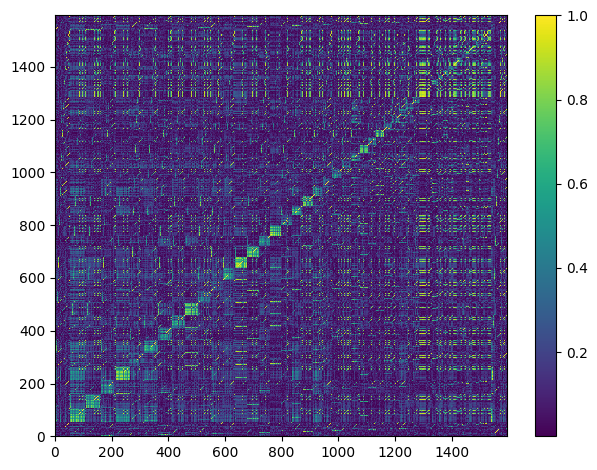

In [10]:
corr = Xtrain_df.corr('spearman')

fig, ax = plt.subplots()
cs = ax.pcolormesh(corr.abs())
fig.colorbar(cs, ax=ax)
fig.tight_layout()

/home/beekill/bin/mambaforge/envs/age/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


<Axes: >

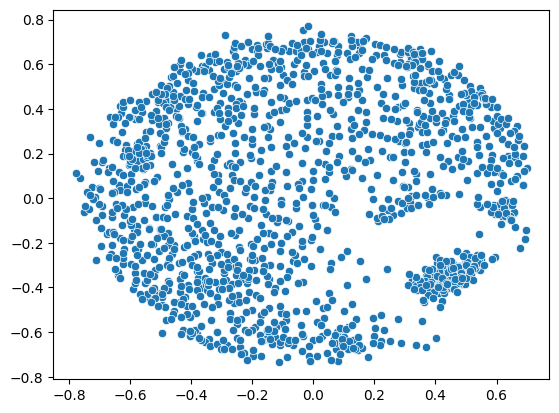

In [11]:
# Convert the correlation matrix into dissimilarity matrix,
# to be used with MDS.
distance = 1. - np.abs(corr)
mds = MDS(n_components=2, dissimilarity='precomputed')
embeddings = mds.fit_transform(distance)

# Show the results.
sns.scatterplot(x=embeddings[:, 0], y=embeddings[:, 1])

Clusters: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 22

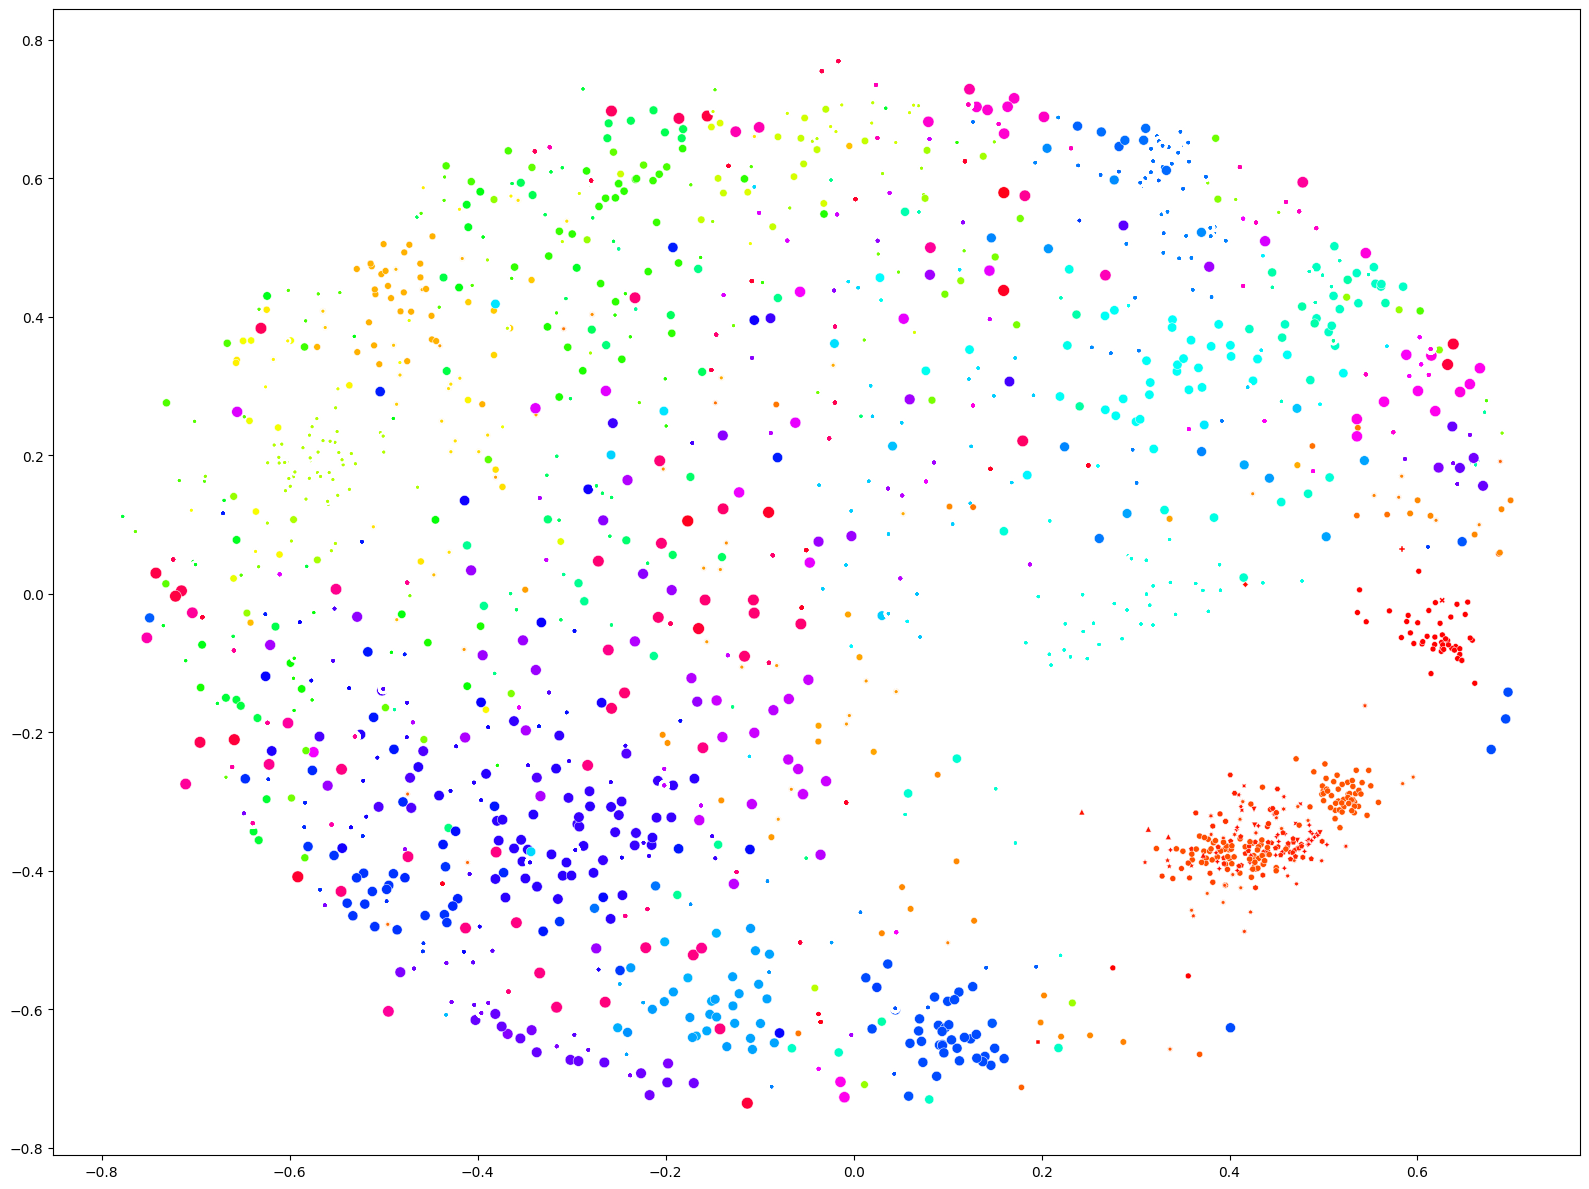

In [12]:
# Now, we can use clustering on the MDS's result
# to identify the clusters.
# clustering = DBSCAN(eps=0.1, min_samples=2, metric='precomputed')
# clusters = clustering.fit_predict(distance)
dist_linkage = hierarchy.ward(squareform(distance))
clusters = hierarchy.fcluster(dist_linkage, 0.3, criterion='distance')
unique_clusters = list(np.unique(clusters))
print(f'Clusters: {unique_clusters}')

# Plot the results.
fig, ax = plt.subplots(figsize=(16, 12))
sns.scatterplot(x=embeddings[:, 0],
                y=embeddings[:, 1],
                hue=clusters,
                style=clusters,
                size=clusters*100,
                palette='hsv',
                legend=False,
                ax=ax)
fig.tight_layout()

In [13]:
# Show the correlation in these clusters.
for cluster in unique_clusters:
    features_in_cluster = Xtrain_df.columns[clusters == cluster]
    X_in_cluster = Xtrain_df[features_in_cluster]
    corr_in_cluster = X_in_cluster.corr('spearman')
    corrs = 1 - squareform(1 - np.abs(corr_in_cluster))
    if len(features_in_cluster) > 1:
        print(f'{cluster=}, nb_features={len(features_in_cluster)}, '
              f'min={np.min(corrs)}, '
              f'max={np.max(corrs)}, mean={np.mean(corrs)}')
    else:
        print(f'{cluster=} has only 1 member.')

cluster=1, nb_features=47, min=0.6610663651465527, max=1.0, mean=0.8717003420133187
cluster=2 has only 1 member.
cluster=3 has only 1 member.
cluster=4 has only 1 member.
cluster=5 has only 1 member.
cluster=6, nb_features=33, min=0.853831339617906, max=1.0, mean=0.9147167073736575
cluster=7, nb_features=4, min=0.8476433715440829, max=0.9202469309244384, mean=0.8927511749537262
cluster=8, nb_features=4, min=0.8597206563102028, max=0.9462443710818355, mean=0.8991774649290855
cluster=9, nb_features=4, min=0.8537912907015649, max=0.9543980205027024, mean=0.902209830135333
cluster=10, nb_features=4, min=0.8893661261708603, max=0.9679051630992845, mean=0.927570034830481
cluster=11, nb_features=4, min=0.8697644756967174, max=0.958440050588756, mean=0.9072027141381702
cluster=12, nb_features=4, min=0.8761722038651139, max=0.9565649215041385, mean=0.9171461688673465
cluster=13, nb_features=38, min=0.8617061212929099, max=1.0, mean=0.925144595261086
cluster=14, nb_features=4, min=0.833351758802

Now, we can use these steps to extract the uncorrelated features.

In [14]:
def filter_in_uncorrelated_features(X_df: pd.DataFrame,
                                    correlation_threshold: float = 0.7):
    # Calculate Spearman's correlation, and then convert to
    # distances matrix.
    corr = X_df.corr('spearman')
    distances = 1. - corr.abs()

    # Perform clustering using Agglomerative Clustering.
    dist_linkage = hierarchy.ward(squareform(distances))
    clusters = hierarchy.fcluster(dist_linkage,
                                  1. - correlation_threshold,
                                  criterion='distance')

    # Choose a feature from each cluster.
    features = []
    for cluster in np.unique(clusters):
        features_in_cluster = X_df.columns[cluster == clusters]

        # TODO: Here, we use the first feature,
        # but it can be other choices.
        chosen_feature = features_in_cluster[0]
        features.append(chosen_feature)

    # Return a new dataframe with the chosen features.
    return X_df[features]

## Model
### Neural Network Classifier

In [15]:
class NNClassifier(nn.Module):
    def __init__(self, input_shape: int) -> None:
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_shape, 1024),
            nn.ReLU(),
            nn.Dropout(),
            nn.LayerNorm(1024),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(),
            nn.LayerNorm(512),

            nn.Linear(512, 64),
            # nn.Tanh(),
        )

        self.output = nn.Sequential(
            # nn.Dropout(),
            nn.LayerNorm(64),
            # nn.Dropout(),
            nn.Linear(64, 1),
        )

    def forward(self, x, *,
                mode: Literal['encoder', 'output', 'full'] = 'full',
                logit: bool = False):
        if mode == 'encoder':
            return self.encoder(x)
        elif mode == 'output':
            x = self.output(x)
            return x if logit else torch.sigmoid(x)
        elif mode == 'full':
            x = self.encoder(x)
            x = self.output(x)
            return x if logit else torch.sigmoid(x)

        raise ValueError(f'Unknown mode={mode}')


def create_training_and_evaluation_step(
        model: nn.Module,
        lr=1e-3,
        weight_decay=1e-5,
        regularization_weight=1e-2):

    loss_fn = nn.BCEWithLogitsLoss()

    optimizer = torch.optim.Adam(
        model.parameters(), lr=lr, weight_decay=weight_decay)

    # Init weights before training.
    def init_weights(m: nn.Module):
        strategy_fn = nn.init.xavier_normal_
        if type(m) in [nn.Linear, nn.LazyLinear]:
            strategy_fn(m.weight)

    model.apply(lambda m: init_weights(m))

    def encoder_regularization_loss(x: torch.Tensor):
        """
        Calculate regularization loss of the encoder's output.

        x should have shape (nb_batches, nb_features)
        """
        # First, the output should be normally distributed.
        l1 = torch.mean(torch.sum(x**2, axis=1))

        # Second, features should not be correlated.
        cov = torch.t(x) @ x
        cov = cov - torch.diag(torch.diag(cov))
        l2 = torch.mean(torch.abs(cov))

        return l1 + l2

    def train_step(dataloader: DataLoader, *,
                   device: str, epoch: int, progress: bool = True,
                   train_noise: float = 0.0):
        model.train()

        train_loss = 0
        regularization_loss = 0

        num_batches = len(dataloader)
        bar = (tqdm(
            enumerate(dataloader), total=num_batches, desc=f'Epoch {epoch}')
            if progress
            else enumerate(dataloader))
        for i, (X, y) in bar:
            X, y = X.to(device), y.to(device)

            # Add noise to the training.
            X = X + train_noise * torch.rand_like(X)

            # Make prediction and calculate loss.
            encoder_output = model(X, mode='encoder')
            pred = model(encoder_output, mode='output', logit=True)

            # Losses.
            encoder_loss = encoder_regularization_loss(encoder_output)
            classification_loss = loss_fn(pred, y)

            loss = regularization_weight * encoder_loss + classification_loss
            regularization_loss += encoder_loss.item()
            train_loss += loss.item()

            # Back-propagation step.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Show the MSE.
            if progress:
                bar.set_postfix_str(
                    f'Loss: {(train_loss / (i + 1)):.4f}'
                    f'- Encoder loss: {regularization_loss / (i + 1):.4f}')

        return train_loss / num_batches, regularization_loss / num_batches

    def evaluate_step(dataloader: DataLoader, device: str):
        num_batches = len(dataloader)
        model.eval()

        test_loss = 0
        regularization_loss = 0

        with torch.no_grad():
            for i, (X, y) in enumerate(dataloader):
                X, y = X.to(device), y.to(device)

                encoder_output = model(X, mode='encoder')
                pred = model(encoder_output, mode='output', logit=True)

                encoder_loss = encoder_regularization_loss(
                    encoder_output).item()
                regularization_loss += encoder_loss
                test_loss += (loss_fn(pred, y).item()
                              + regularization_weight * encoder_loss)

        test_loss /= num_batches
        return test_loss, regularization_loss / num_batches

    return train_step, evaluate_step


def train(model: nn.Module,
          *,
          train_ds: DataLoader,
          val_ds: DataLoader,
          epochs: int,
          train_noise: float = 0.0,
          early_stopping_patience: int = 100,
          device: str = 'cpu',
          lr: float = 1e-3,
          weight_decay: float = 1e-2,
          regularization_weight: float = 1.0):
    def save_checkpoint(model, path):
        torch.save(model.state_dict(), path)

    def load_checkpoint(model, path):
        model.load_state_dict(torch.load(path))
        return model

    model = model.to(device)

    train_step, val_step = create_training_and_evaluation_step(
        model,
        lr=lr,
        weight_decay=weight_decay,
        regularization_weight=regularization_weight)
    train_losses = []
    val_losses = []

    tmp_path = 'tmp_autoencoder.pth'

    patience = 0
    bar = tqdm(range(epochs), total=epochs, desc='Training')
    for epoch in bar:
        train_loss, train_regu_loss = train_step(
            train_ds, device=device, epoch=epoch, progress=False,
            train_noise=train_noise)
        train_losses.append(train_loss)

        val_loss, val_regu_loss = val_step(val_ds, device)
        val_losses.append(val_loss)

        bar.set_postfix_str(
            f'Train: {train_loss:.4f} - Val: {val_loss:.4f}'
            f'-Train Reg: {train_regu_loss:.4f} - Val Reg:{val_regu_loss:.4f}')

        patience += 1
        if val_loss <= np.min(val_losses):
            save_checkpoint(model, tmp_path)
            patience = 0
        else:
            if patience > early_stopping_patience:
                print(f'The validation does not improve for the last {patience} epochs. '
                      'Early stopping!')
                break

    # Best validation score and corresponding train score.
    best_val_idx = np.argmin(val_losses)
    print(
        f'Train: {train_losses[best_val_idx]:.4f} '
        f'- Val: {val_losses[best_val_idx]:.4f} at epoch {best_val_idx}.')

    # Restore the best model.
    print('Restore the best model.')
    return (load_checkpoint(model, tmp_path),
            dict(train_loss=train_losses,
                 val_loss=val_losses,
                 best_epoch=best_val_idx))

### Features Selection

In [16]:
def select_important_features(
        X, y, *, n_estimators: int = 50, important_thresholds: float = 0.5):
    model = ExtraTreesClassifier(n_estimators=n_estimators)
    model.fit(X, y)
    print(model.feature_importances_)
    selector = SelectFromModel(
        model,
        prefit=True,
        threshold=important_thresholds)
    x = selector.fit_transform(X, y)
    return pd.DataFrame(x, columns=selector.get_feature_names_out())

### Oversampling

In [17]:
def sampling(X, y):
    ros = SMOTENC(['ej'], sampling_strategy='all', random_state=0)
    columns = X.columns
    x, y = ros.fit_resample(X, y)
    return pd.DataFrame(x, columns=columns), y

### Cross Validation


-- Fold # 1/10 -Repeat #1/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  83


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1432 - Val: 0.2789 at epoch 347.
Restore the best model.


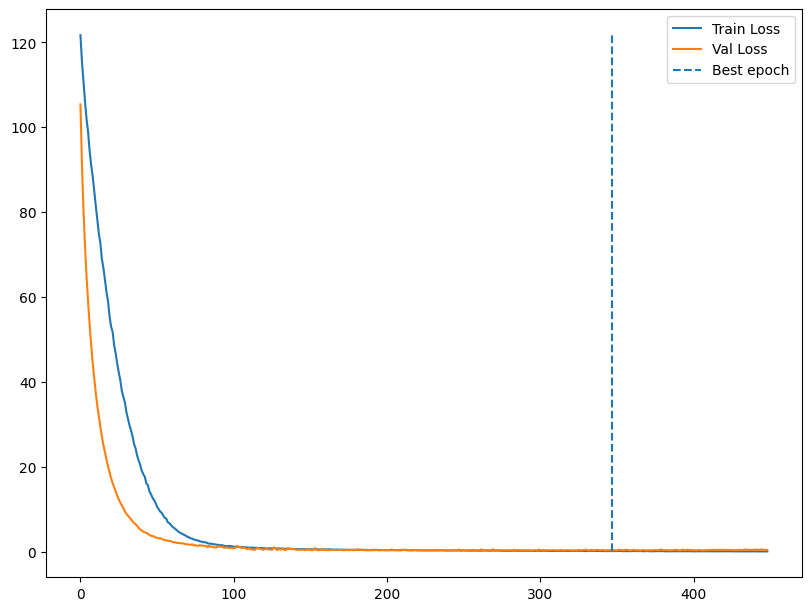

(20000, 555)
(20000,)
Train - f1=0.9897 recall=0.9897 precision=0.9897 log-loss=0.0253 opt-log-loss=0.0249
(20000, 62)
(20000,)
Test  - f1=0.7273 recall=0.7273 precision=0.7273 log-loss=0.3965 opt-log-loss=0.2679

-- Fold # 1/10 -Repeat #2/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  83


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1736 - Val: 0.2038 at epoch 326.
Restore the best model.


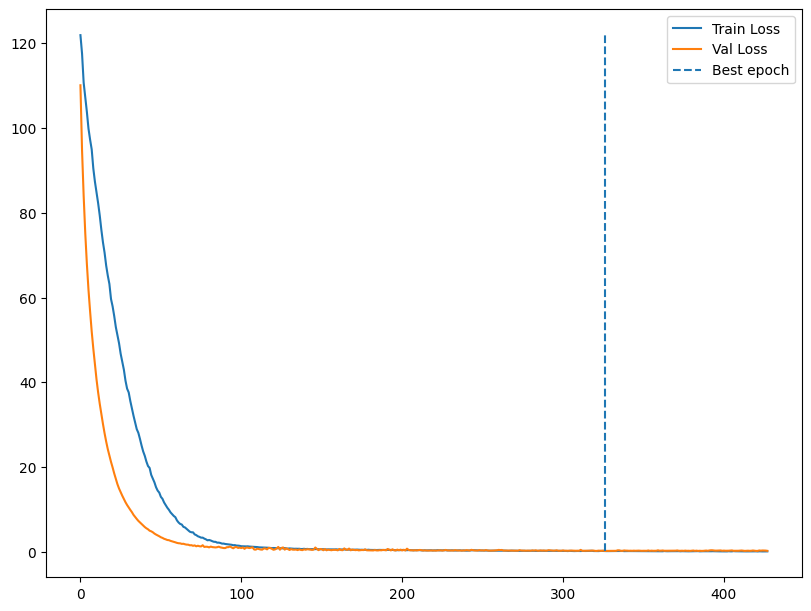

(20000, 555)
(20000,)
Train - f1=0.9746 recall=0.9897 precision=0.9600 log-loss=0.0412 opt-log-loss=0.0363
(20000, 62)
(20000,)
Test  - f1=0.9091 recall=0.9091 precision=0.9091 log-loss=0.2013 opt-log-loss=0.1581

-- Fold # 1/10 -Repeat #3/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  83


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1941 - Val: 0.2666 at epoch 291.
Restore the best model.


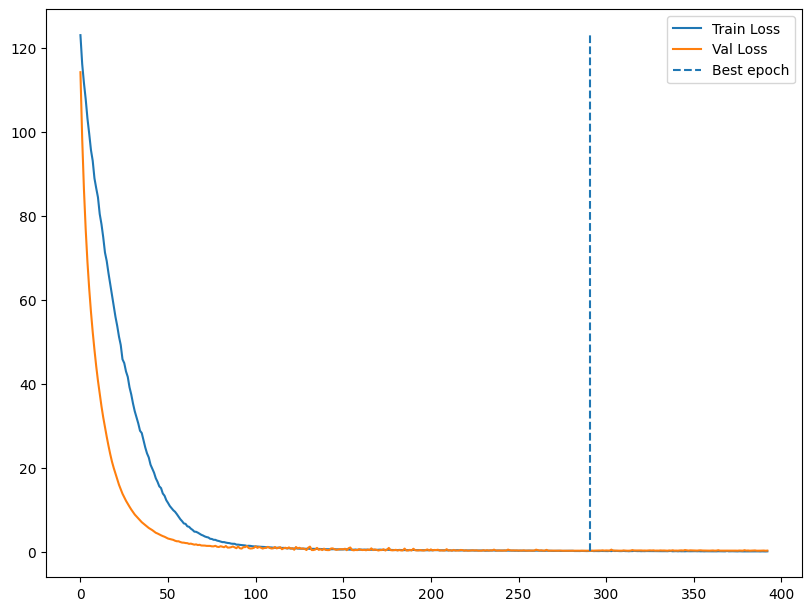

(20000, 555)
(20000,)
Train - f1=0.9648 recall=0.9897 precision=0.9412 log-loss=0.0451 opt-log-loss=0.0494
(20000, 62)
(20000,)
Test  - f1=0.8182 recall=0.8182 precision=0.8182 log-loss=0.2247 opt-log-loss=0.1864

-- Fold # 1/10 -Repeat #4/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  83


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1375 - Val: 0.3050 at epoch 360.
Restore the best model.


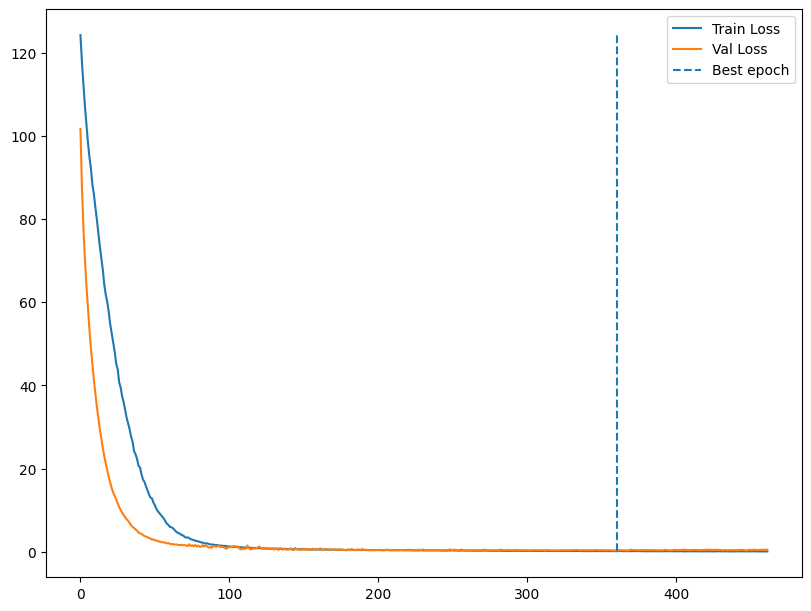

(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.0170 opt-log-loss=0.0143
(20000, 62)
(20000,)
Test  - f1=0.7619 recall=0.7273 precision=0.8000 log-loss=0.4240 opt-log-loss=0.2958

-- Fold # 1/10 -Repeat #5/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  83


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2096 - Val: 0.2590 at epoch 291.
Restore the best model.


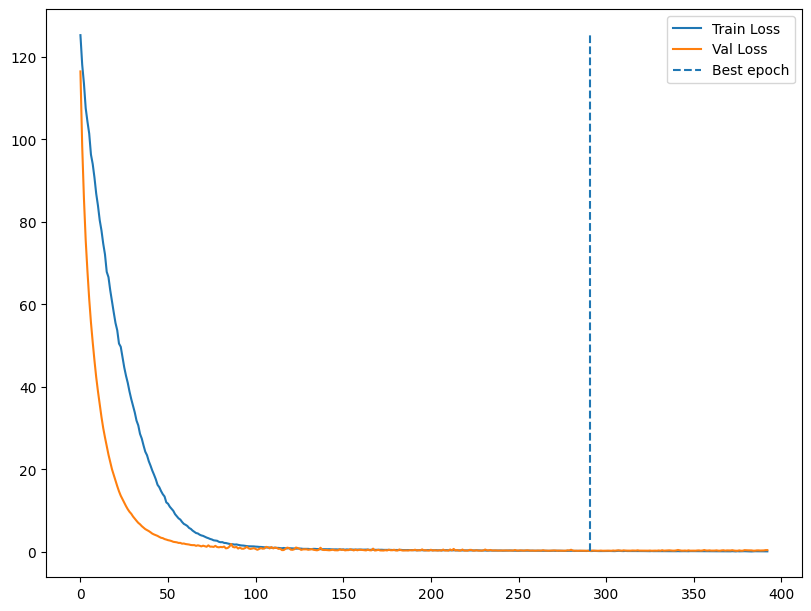

(20000, 555)
(20000,)
Train - f1=0.9746 recall=0.9897 precision=0.9600 log-loss=0.0519 opt-log-loss=0.0602
(20000, 62)
(20000,)
Test  - f1=0.6667 recall=0.6364 precision=0.7000 log-loss=0.2815 opt-log-loss=0.2147

-- Fold # 1/10 -Repeat #6/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  83


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2578 - Val: 0.2698 at epoch 264.
Restore the best model.


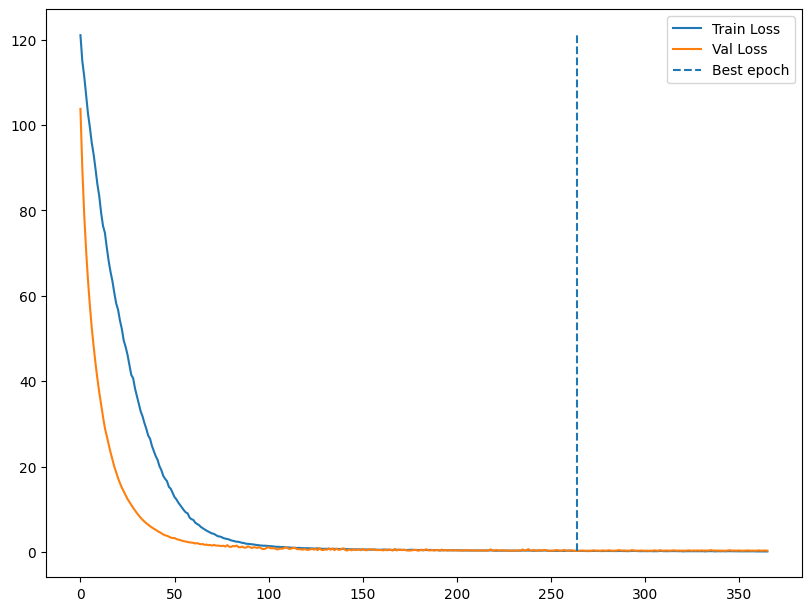

(20000, 555)
(20000,)
Train - f1=0.9588 recall=0.9588 precision=0.9588 log-loss=0.0945 opt-log-loss=0.0788
(20000, 62)
(20000,)
Test  - f1=0.6667 recall=0.6364 precision=0.7000 log-loss=0.3289 opt-log-loss=0.2151

-- Fold # 1/10 -Repeat #7/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  83


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1249 - Val: 0.2375 at epoch 377.
Restore the best model.


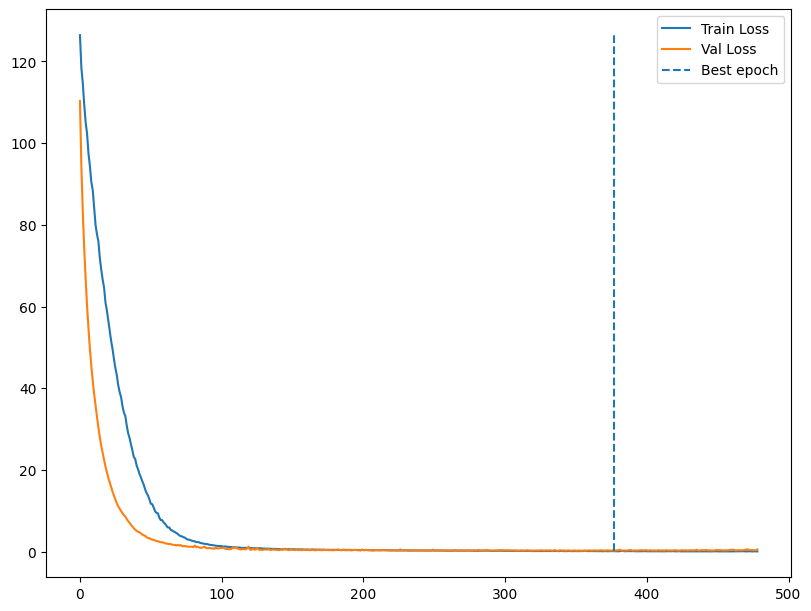

(20000, 555)
(20000,)
Train - f1=0.9949 recall=1.0000 precision=0.9898 log-loss=0.0256 opt-log-loss=0.0190
(20000, 62)
(20000,)
Test  - f1=0.8000 recall=0.7273 precision=0.8889 log-loss=0.3153 opt-log-loss=0.1964

-- Fold # 1/10 -Repeat #8/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  83


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1968 - Val: 0.2476 at epoch 318.
Restore the best model.


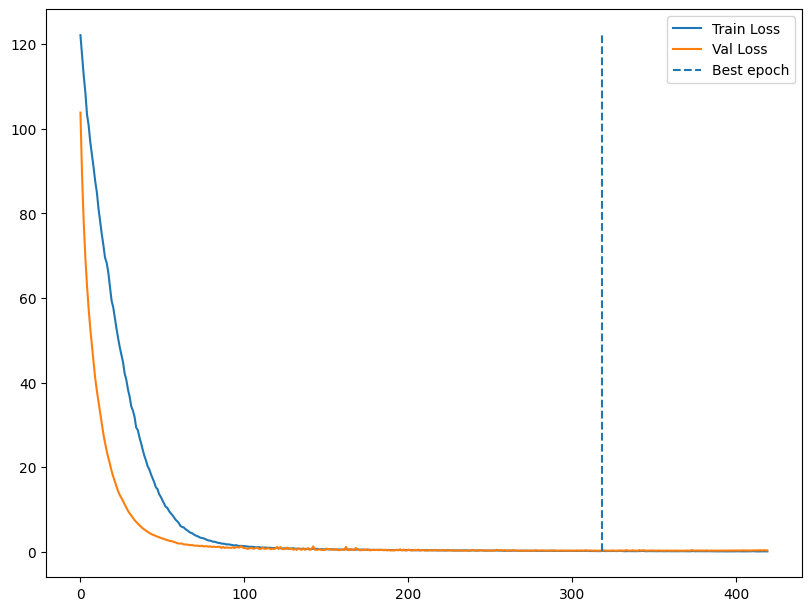

(20000, 555)
(20000,)
Train - f1=0.9897 recall=0.9897 precision=0.9897 log-loss=0.0298 opt-log-loss=0.0240
(20000, 62)
(20000,)
Test  - f1=0.7273 recall=0.7273 precision=0.7273 log-loss=0.3338 opt-log-loss=0.2181

-- Fold # 1/10 -Repeat #9/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  83


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1713 - Val: 0.2405 at epoch 317.
Restore the best model.


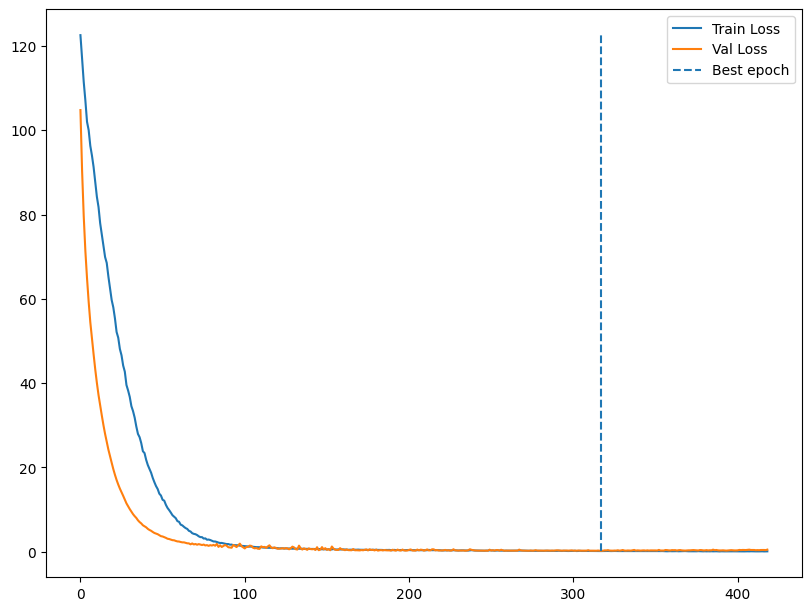

(20000, 555)
(20000,)
Train - f1=0.9798 recall=1.0000 precision=0.9604 log-loss=0.0258 opt-log-loss=0.0428
(20000, 62)
(20000,)
Test  - f1=0.7826 recall=0.8182 precision=0.7500 log-loss=0.2290 opt-log-loss=0.1970

-- Fold # 1/10 -Repeat #10/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  83


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.0470 - Val: 0.2430 at epoch 598.
Restore the best model.


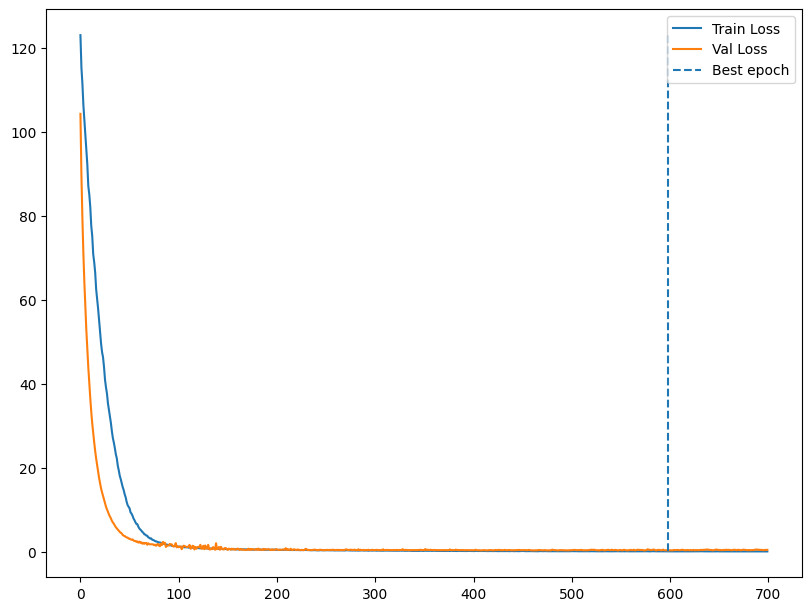

(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.0022 opt-log-loss=0.0043
(20000, 62)
(20000,)
Test  - f1=0.8000 recall=0.7273 precision=0.8889 log-loss=0.3609 opt-log-loss=0.2545

-- Fold # 2/10 -Repeat #1/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3909 - Val: 0.3113 at epoch 200.
Restore the best model.


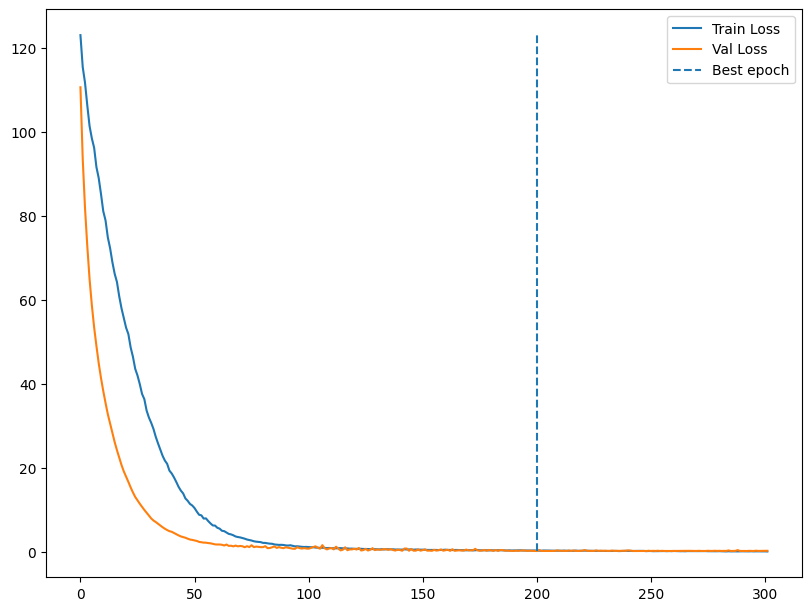

(20000, 555)
(20000,)
Train - f1=0.8856 recall=0.9175 precision=0.8558 log-loss=0.1716 opt-log-loss=0.1735
(20000, 62)
(20000,)
Test  - f1=0.6364 recall=0.6364 precision=0.6364 log-loss=0.4147 opt-log-loss=0.3233

-- Fold # 2/10 -Repeat #2/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1848 - Val: 0.2649 at epoch 299.
Restore the best model.


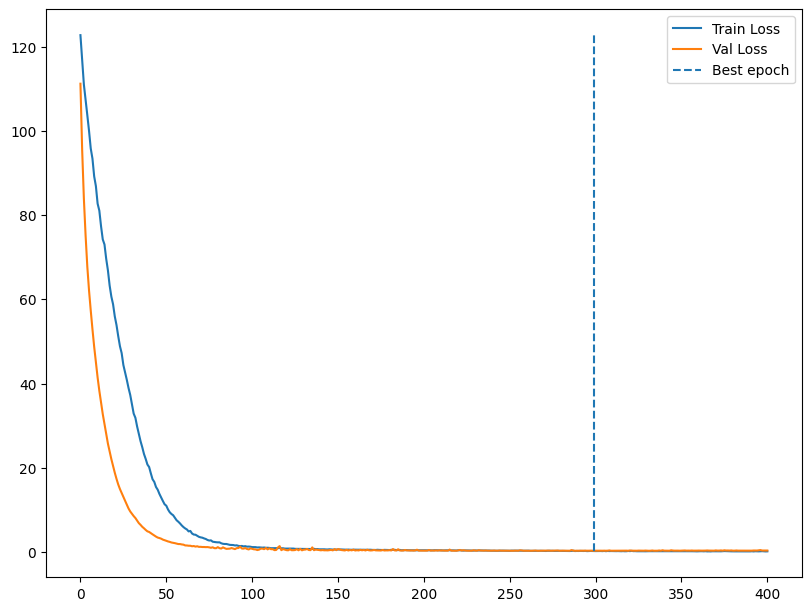

(20000, 555)
(20000,)
Train - f1=0.9749 recall=1.0000 precision=0.9510 log-loss=0.0237 opt-log-loss=0.0444
(20000, 62)
(20000,)
Test  - f1=0.9091 recall=0.9091 precision=0.9091 log-loss=0.3278 opt-log-loss=0.2759

-- Fold # 2/10 -Repeat #3/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2471 - Val: 0.2657 at epoch 272.
Restore the best model.


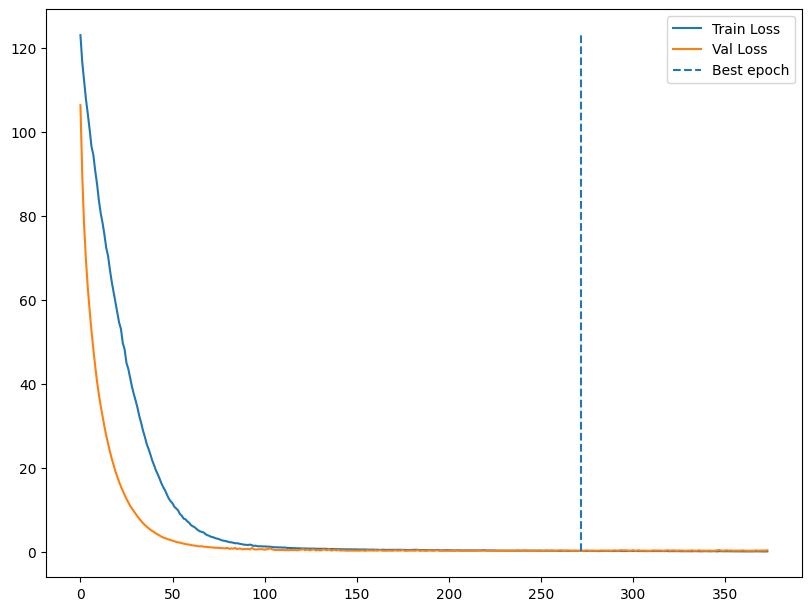

(20000, 555)
(20000,)
Train - f1=0.9458 recall=0.9897 precision=0.9057 log-loss=0.0522 opt-log-loss=0.0718
(20000, 62)
(20000,)
Test  - f1=0.8571 recall=0.8182 precision=0.9000 log-loss=0.3146 opt-log-loss=0.2440

-- Fold # 2/10 -Repeat #4/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1741 - Val: 0.2797 at epoch 318.
Restore the best model.


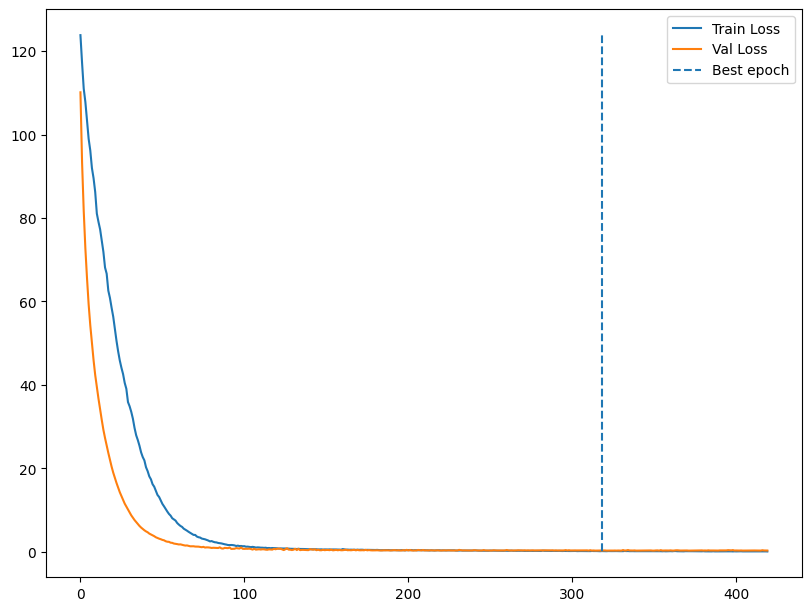

(20000, 555)
(20000,)
Train - f1=0.9949 recall=1.0000 precision=0.9898 log-loss=0.0308 opt-log-loss=0.0234
(20000, 62)
(20000,)
Test  - f1=0.8571 recall=0.8182 precision=0.9000 log-loss=0.4195 opt-log-loss=0.3435

-- Fold # 2/10 -Repeat #5/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3763 - Val: 0.3102 at epoch 216.
Restore the best model.


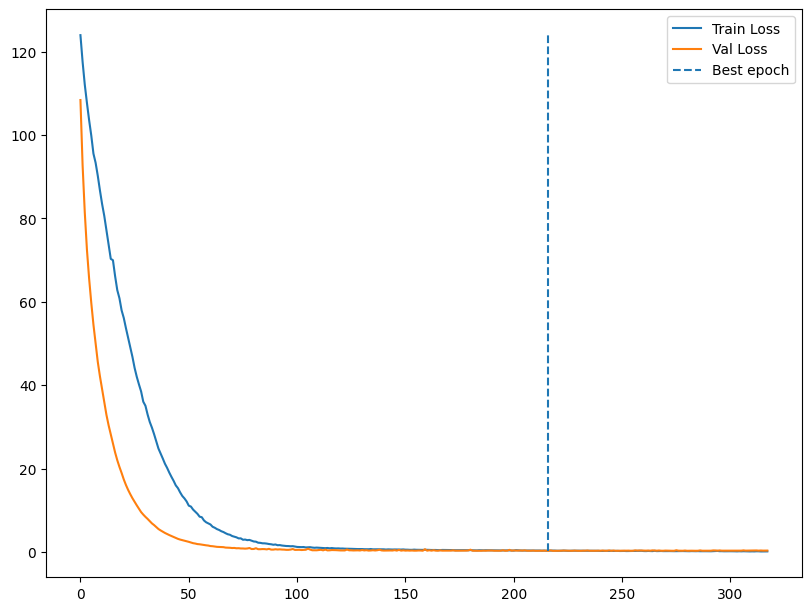

(20000, 555)
(20000,)
Train - f1=0.8611 recall=0.9588 precision=0.7815 log-loss=0.1252 opt-log-loss=0.1561
(20000, 62)
(20000,)
Test  - f1=0.8000 recall=0.9091 precision=0.7143 log-loss=0.3412 opt-log-loss=0.2983

-- Fold # 2/10 -Repeat #6/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1891 - Val: 0.2921 at epoch 321.
Restore the best model.


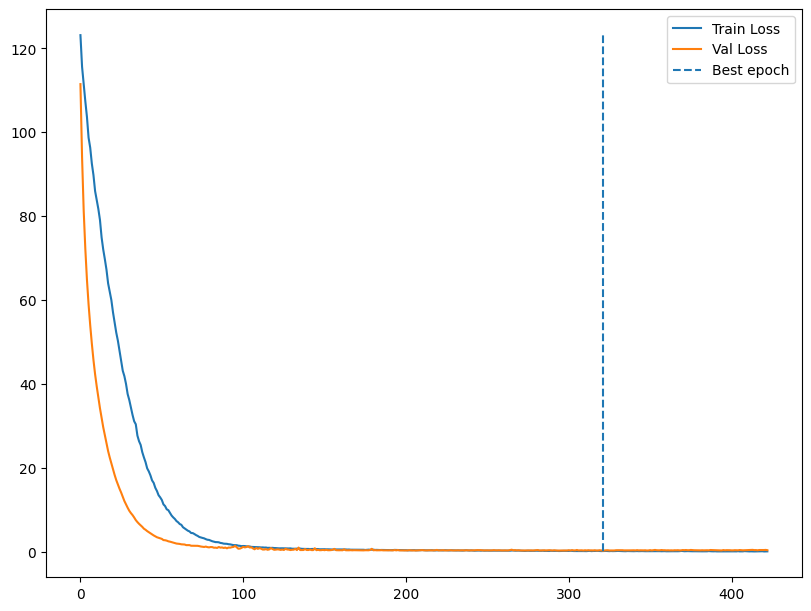

(20000, 555)
(20000,)
Train - f1=0.9898 recall=1.0000 precision=0.9798 log-loss=0.0187 opt-log-loss=0.0283
(20000, 62)
(20000,)
Test  - f1=0.8182 recall=0.8182 precision=0.8182 log-loss=0.3944 opt-log-loss=0.3198

-- Fold # 2/10 -Repeat #7/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2988 - Val: 0.2904 at epoch 236.
Restore the best model.


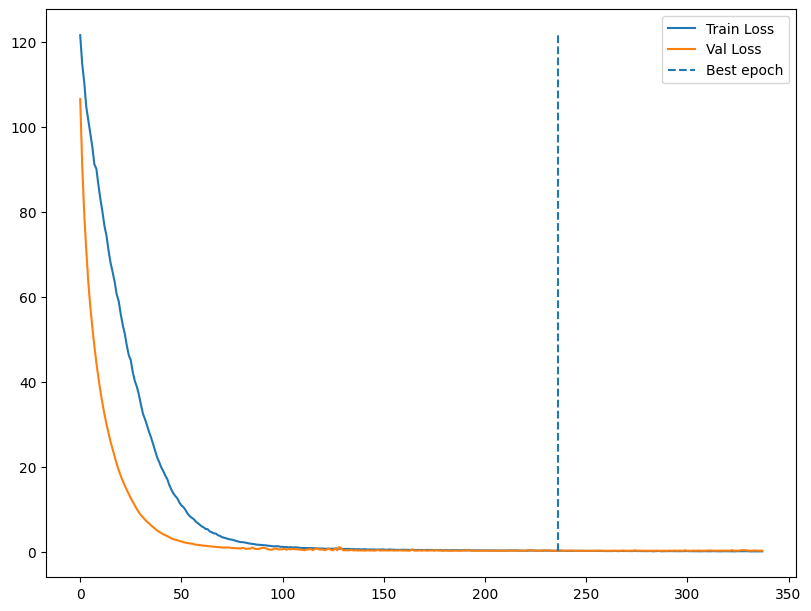

(20000, 555)
(20000,)
Train - f1=0.8818 recall=1.0000 precision=0.7886 log-loss=0.0749 opt-log-loss=0.1289
(20000, 62)
(20000,)
Test  - f1=0.8696 recall=0.9091 precision=0.8333 log-loss=0.3817 opt-log-loss=0.3368

-- Fold # 2/10 -Repeat #8/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3314 - Val: 0.2246 at epoch 224.
Restore the best model.


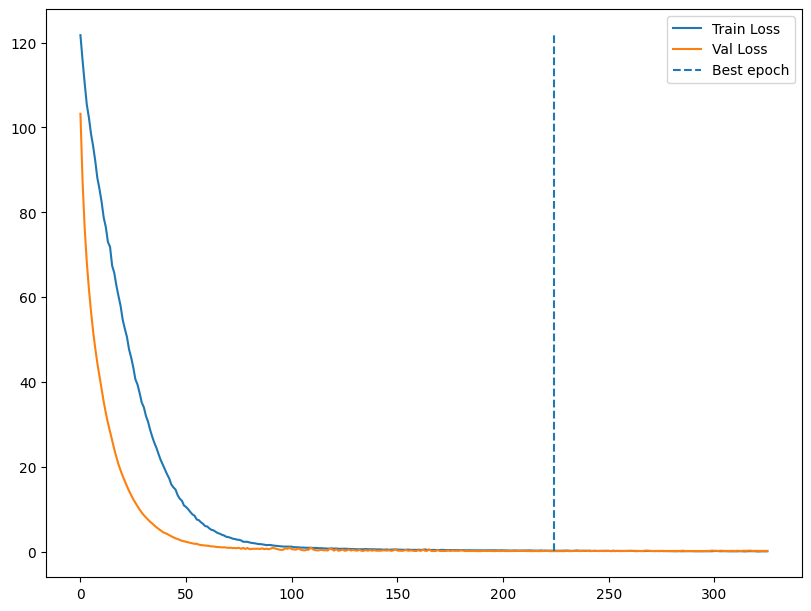

(20000, 555)
(20000,)
Train - f1=0.8889 recall=0.9485 precision=0.8364 log-loss=0.1338 opt-log-loss=0.1375
(20000, 62)
(20000,)
Test  - f1=0.8333 recall=0.9091 precision=0.7692 log-loss=0.2484 opt-log-loss=0.1947

-- Fold # 2/10 -Repeat #9/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3424 - Val: 0.2604 at epoch 225.
Restore the best model.


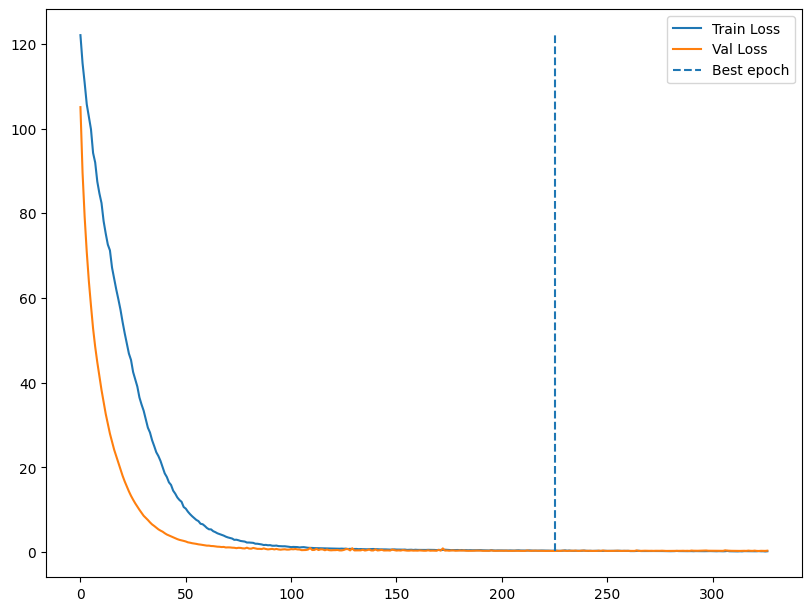

(20000, 555)
(20000,)
Train - f1=0.8837 recall=0.9794 precision=0.8051 log-loss=0.1042 opt-log-loss=0.1429
(20000, 62)
(20000,)
Test  - f1=0.8182 recall=0.8182 precision=0.8182 log-loss=0.3157 opt-log-loss=0.2361

-- Fold # 2/10 -Repeat #10/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3339 - Val: 0.2544 at epoch 229.
Restore the best model.


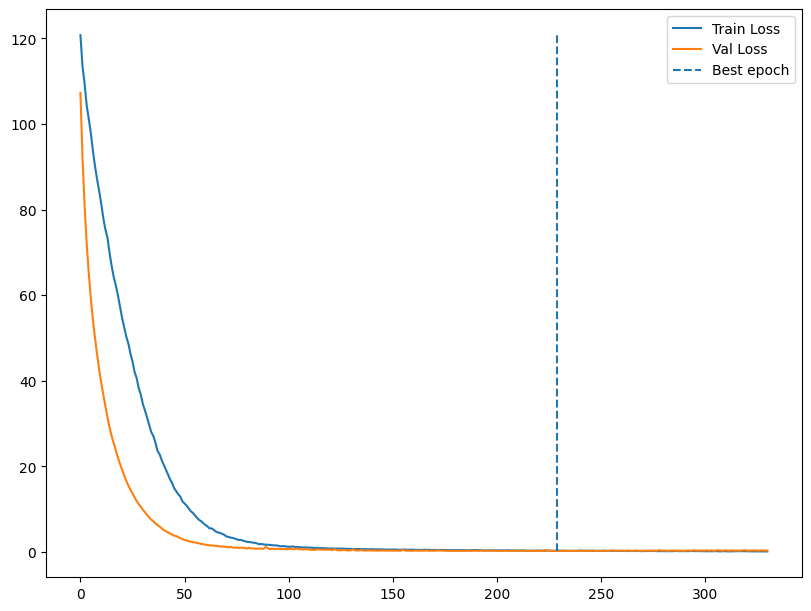

(20000, 555)
(20000,)
Train - f1=0.8610 recall=0.9897 precision=0.7619 log-loss=0.1067 opt-log-loss=0.1518
(20000, 62)
(20000,)
Test  - f1=0.8333 recall=0.9091 precision=0.7692 log-loss=0.2516 opt-log-loss=0.2345

-- Fold # 3/10 -Repeat #1/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2168 - Val: 0.2607 at epoch 294.
Restore the best model.


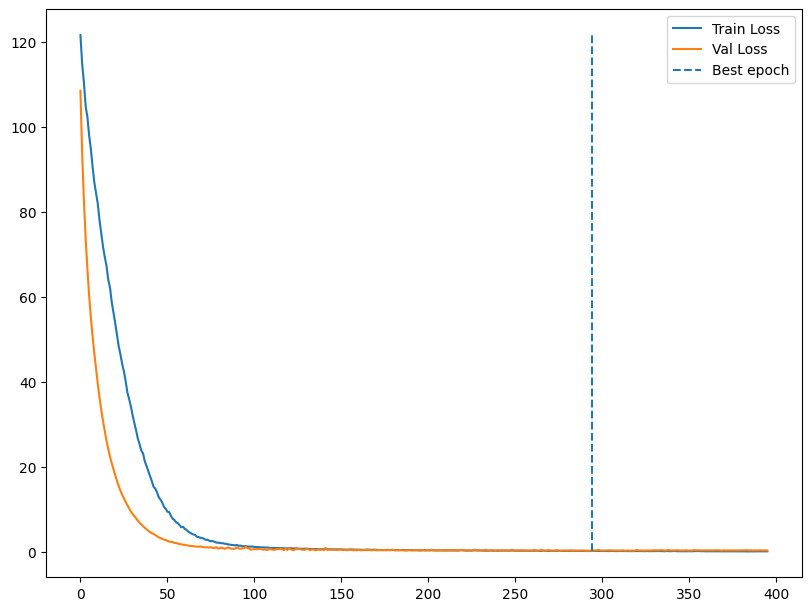

(20000, 555)
(20000,)
Train - f1=0.9794 recall=0.9794 precision=0.9794 log-loss=0.0768 opt-log-loss=0.0591
(20000, 62)
(20000,)
Test  - f1=0.7500 recall=0.8182 precision=0.6923 log-loss=0.2396 opt-log-loss=0.1958

-- Fold # 3/10 -Repeat #2/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1737 - Val: 0.3301 at epoch 340.
Restore the best model.


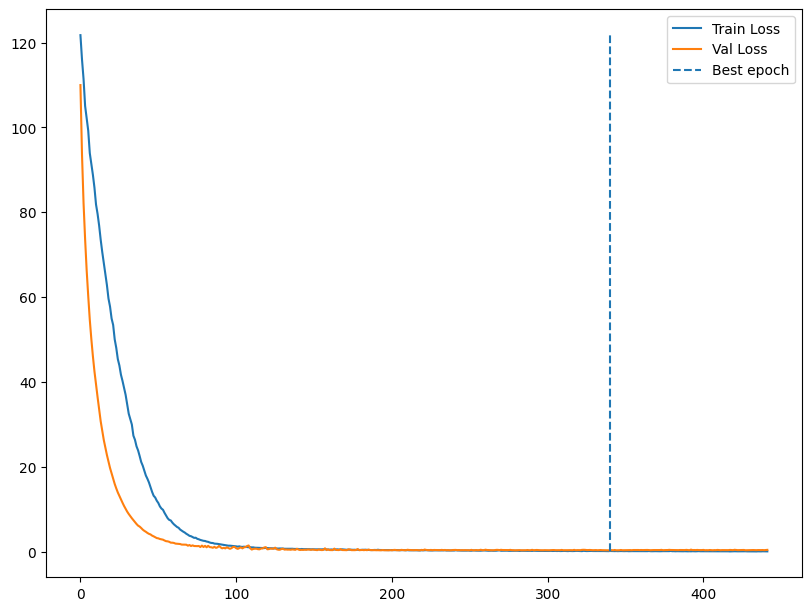

(20000, 555)
(20000,)
Train - f1=0.9896 recall=0.9794 precision=1.0000 log-loss=0.0359 opt-log-loss=0.0199
(20000, 62)
(20000,)
Test  - f1=0.7826 recall=0.8182 precision=0.7500 log-loss=0.3887 opt-log-loss=0.2904

-- Fold # 3/10 -Repeat #3/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1522 - Val: 0.2846 at epoch 357.
Restore the best model.


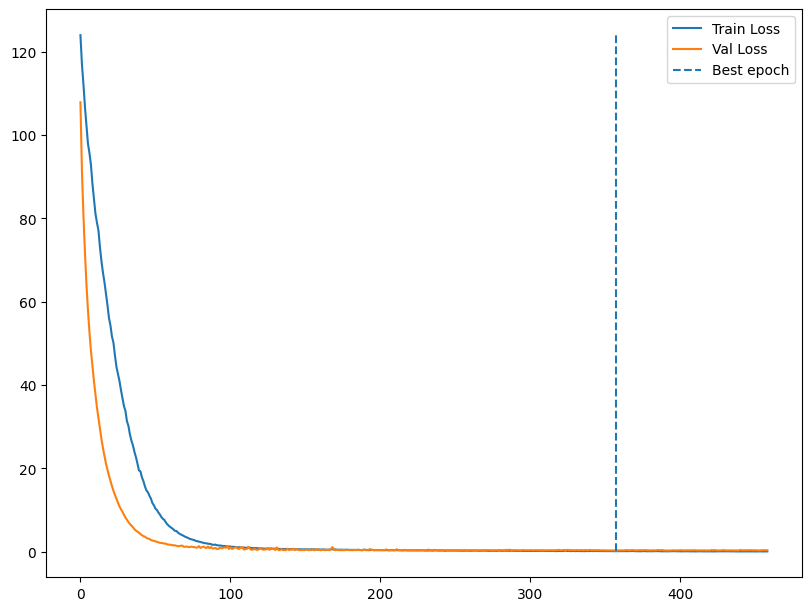

(20000, 555)
(20000,)
Train - f1=0.9896 recall=0.9794 precision=1.0000 log-loss=0.0506 opt-log-loss=0.0200
(20000, 62)
(20000,)
Test  - f1=0.8000 recall=0.7273 precision=0.8889 log-loss=0.4359 opt-log-loss=0.2719

-- Fold # 3/10 -Repeat #4/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1862 - Val: 0.3066 at epoch 305.
Restore the best model.


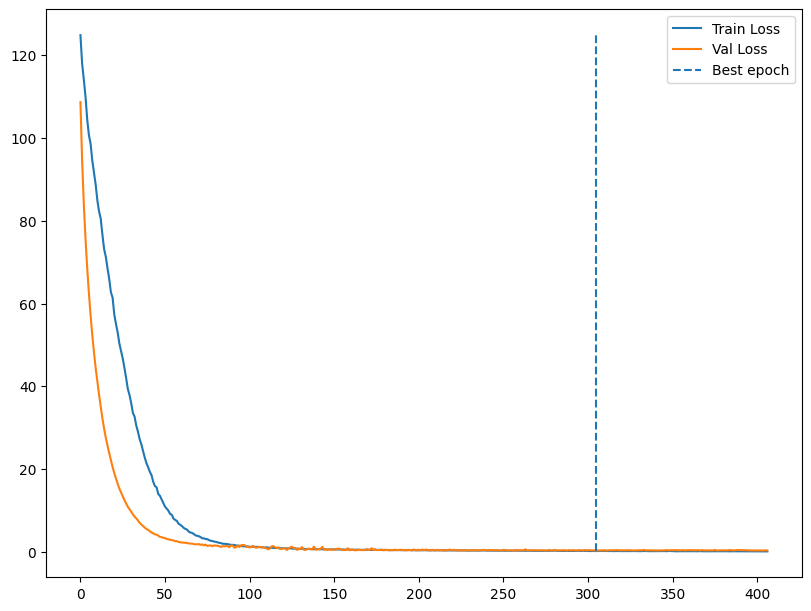

(20000, 555)
(20000,)
Train - f1=0.9897 recall=0.9897 precision=0.9897 log-loss=0.0251 opt-log-loss=0.0304
(20000, 62)
(20000,)
Test  - f1=0.7500 recall=0.8182 precision=0.6923 log-loss=0.3728 opt-log-loss=0.3008

-- Fold # 3/10 -Repeat #5/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2495 - Val: 0.2793 at epoch 260.
Restore the best model.


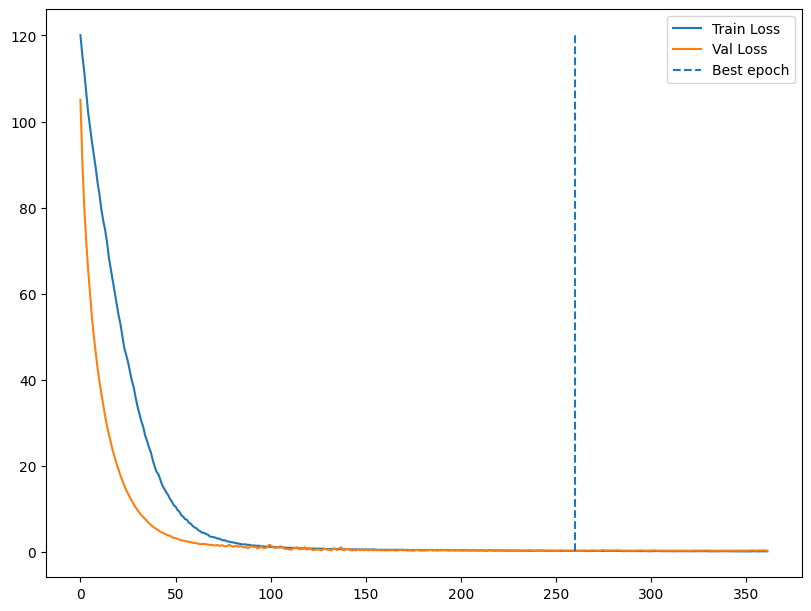

(20000, 555)
(20000,)
Train - f1=0.9794 recall=0.9794 precision=0.9794 log-loss=0.0937 opt-log-loss=0.0772
(20000, 62)
(20000,)
Test  - f1=0.6667 recall=0.6364 precision=0.7000 log-loss=0.3677 opt-log-loss=0.2507

-- Fold # 3/10 -Repeat #6/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3603 - Val: 0.2818 at epoch 217.
Restore the best model.


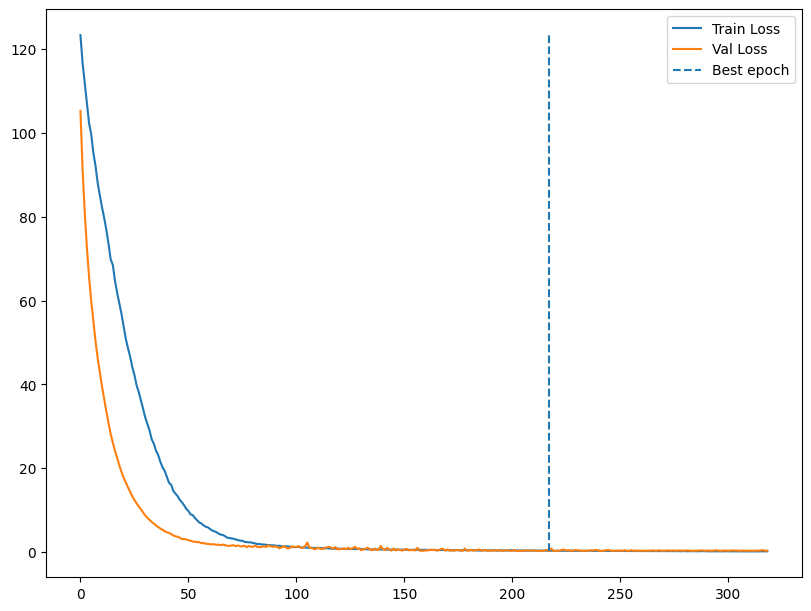

(20000, 555)
(20000,)
Train - f1=0.9005 recall=0.9794 precision=0.8333 log-loss=0.1249 opt-log-loss=0.1369
(20000, 62)
(20000,)
Test  - f1=0.7273 recall=0.7273 precision=0.7273 log-loss=0.3649 opt-log-loss=0.2853

-- Fold # 3/10 -Repeat #7/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.0362 - Val: 0.2686 at epoch 616.
Restore the best model.


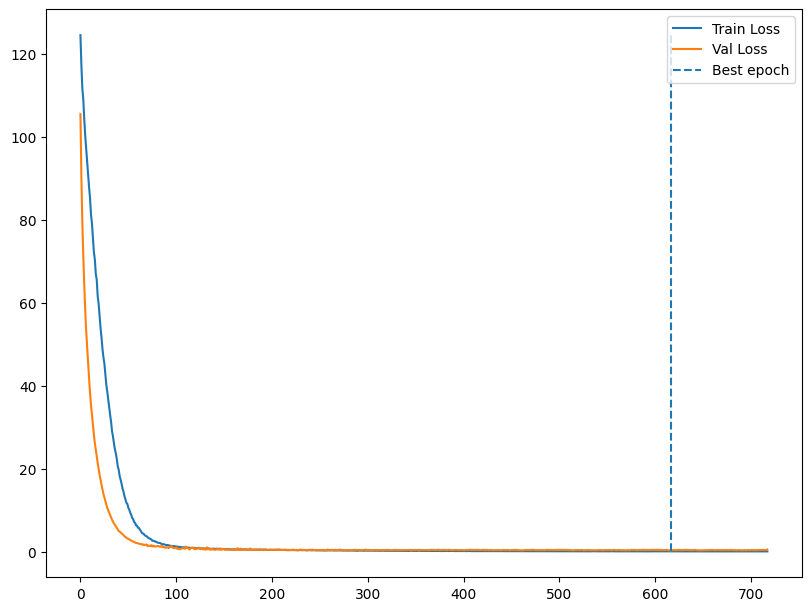

(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.0049 opt-log-loss=0.0043
(20000, 62)
(20000,)
Test  - f1=0.7368 recall=0.6364 precision=0.8750 log-loss=0.5277 opt-log-loss=0.3460

-- Fold # 3/10 -Repeat #8/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2896 - Val: 0.3195 at epoch 236.
Restore the best model.


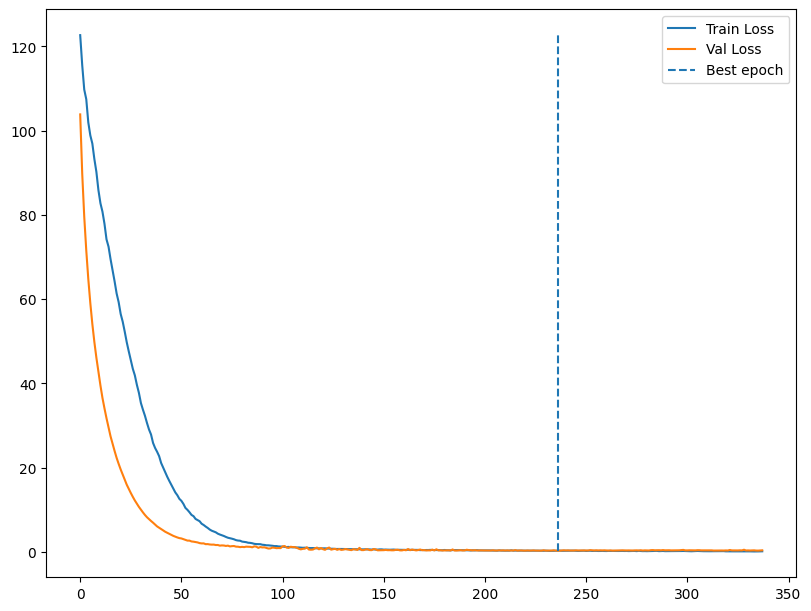

(20000, 555)
(20000,)
Train - f1=0.9543 recall=0.9691 precision=0.9400 log-loss=0.1022 opt-log-loss=0.0937
(20000, 62)
(20000,)
Test  - f1=0.6957 recall=0.7273 precision=0.6667 log-loss=0.3750 opt-log-loss=0.2879

-- Fold # 3/10 -Repeat #9/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3227 - Val: 0.3004 at epoch 218.
Restore the best model.


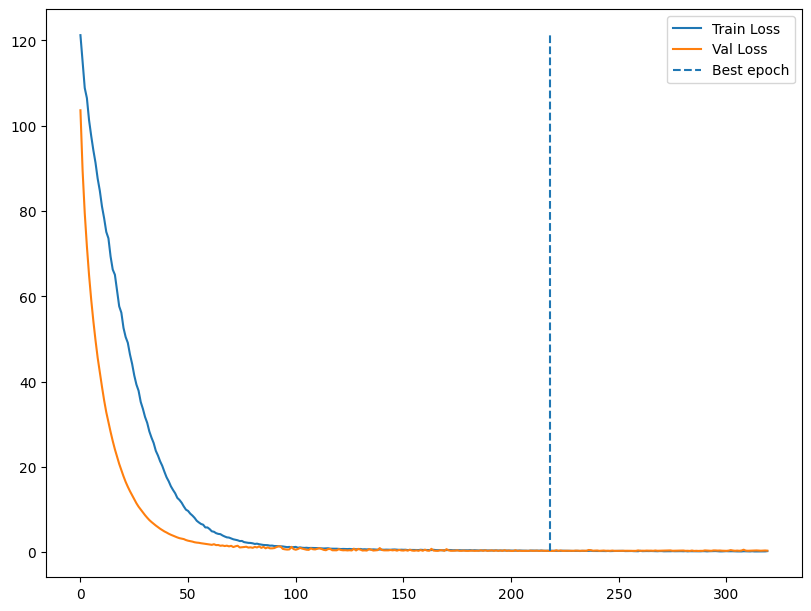

(20000, 555)
(20000,)
Train - f1=0.9254 recall=0.9588 precision=0.8942 log-loss=0.1374 opt-log-loss=0.1166
(20000, 62)
(20000,)
Test  - f1=0.6364 recall=0.6364 precision=0.6364 log-loss=0.3848 opt-log-loss=0.2846

-- Fold # 3/10 -Repeat #10/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3867 - Val: 0.3093 at epoch 212.
Restore the best model.


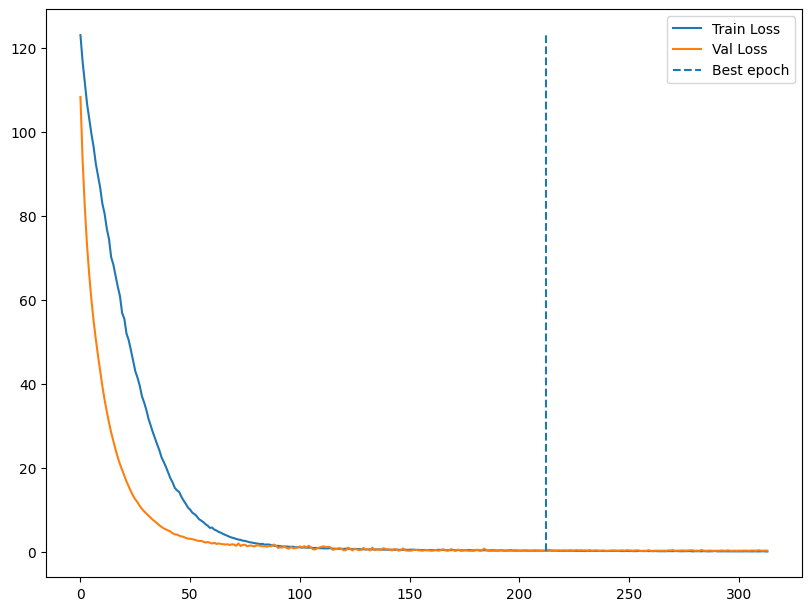

(20000, 555)
(20000,)
Train - f1=0.9246 recall=0.9485 precision=0.9020 log-loss=0.1614 opt-log-loss=0.1279
(20000, 62)
(20000,)
Test  - f1=0.5714 recall=0.5455 precision=0.6000 log-loss=0.3884 opt-log-loss=0.2718

-- Fold # 4/10 -Repeat #1/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2780 - Val: 0.2396 at epoch 231.
Restore the best model.


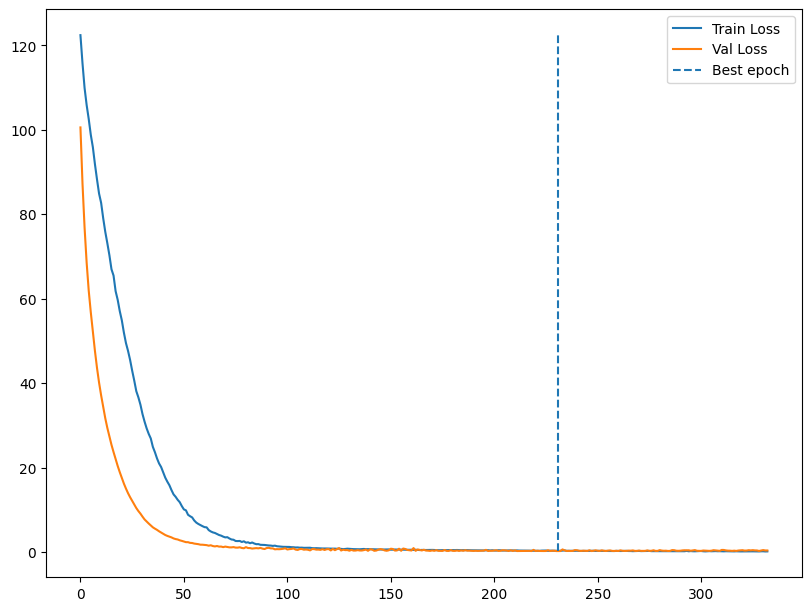

(20000, 555)
(20000,)
Train - f1=0.9293 recall=0.9485 precision=0.9109 log-loss=0.1647 opt-log-loss=0.1177
(20000, 62)
(20000,)
Test  - f1=0.7500 recall=0.8182 precision=0.6923 log-loss=0.3102 opt-log-loss=0.2234

-- Fold # 4/10 -Repeat #2/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.4956 - Val: 0.2569 at epoch 169.
Restore the best model.


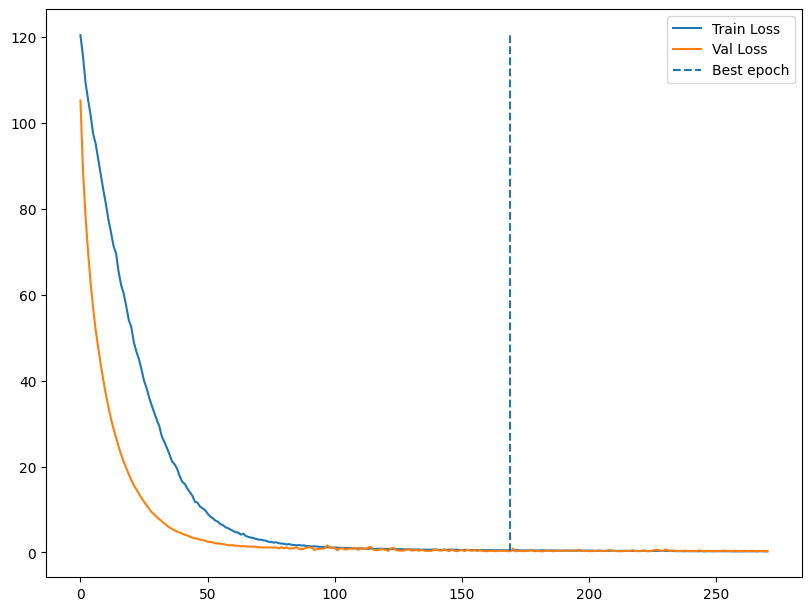

(20000, 555)
(20000,)
Train - f1=0.7895 recall=0.7732 precision=0.8065 log-loss=0.3257 opt-log-loss=0.2344
(20000, 62)
(20000,)
Test  - f1=0.8182 recall=0.8182 precision=0.8182 log-loss=0.3316 opt-log-loss=0.2824

-- Fold # 4/10 -Repeat #3/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3356 - Val: 0.2533 at epoch 233.
Restore the best model.


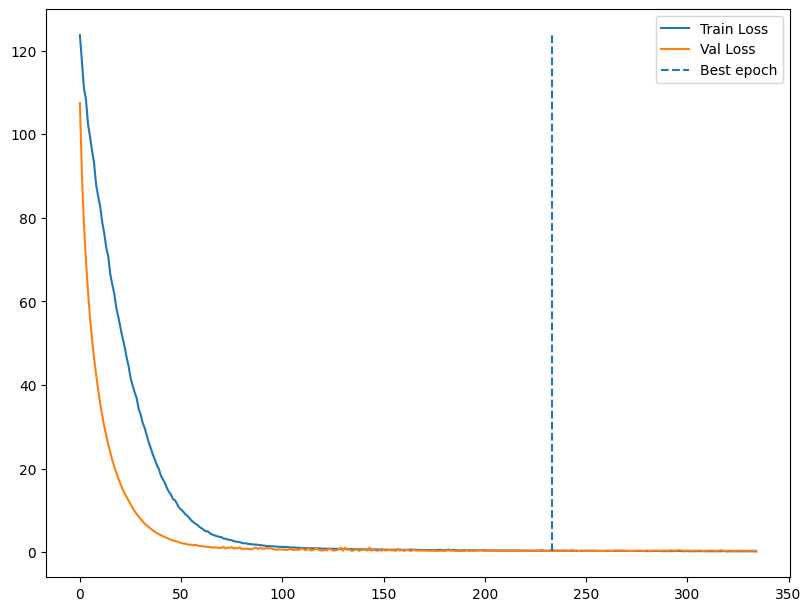

(20000, 555)
(20000,)
Train - f1=0.9208 recall=0.9588 precision=0.8857 log-loss=0.1442 opt-log-loss=0.1370
(20000, 62)
(20000,)
Test  - f1=0.7826 recall=0.8182 precision=0.7500 log-loss=0.2514 opt-log-loss=0.2153

-- Fold # 4/10 -Repeat #4/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3214 - Val: 0.2498 at epoch 224.
Restore the best model.


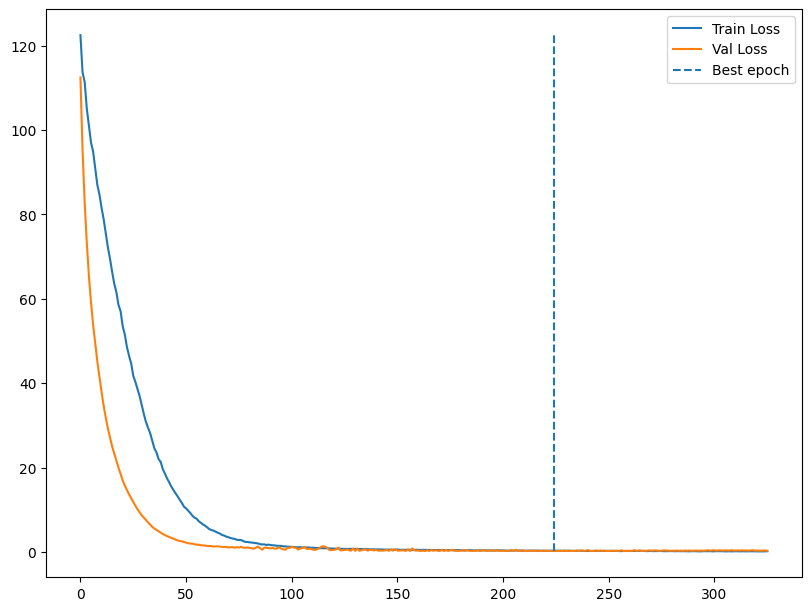

(20000, 555)
(20000,)
Train - f1=0.9184 recall=0.9278 precision=0.9091 log-loss=0.1512 opt-log-loss=0.1175
(20000, 62)
(20000,)
Test  - f1=0.7826 recall=0.8182 precision=0.7500 log-loss=0.2364 opt-log-loss=0.1954

-- Fold # 4/10 -Repeat #5/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3627 - Val: 0.2305 at epoch 208.
Restore the best model.


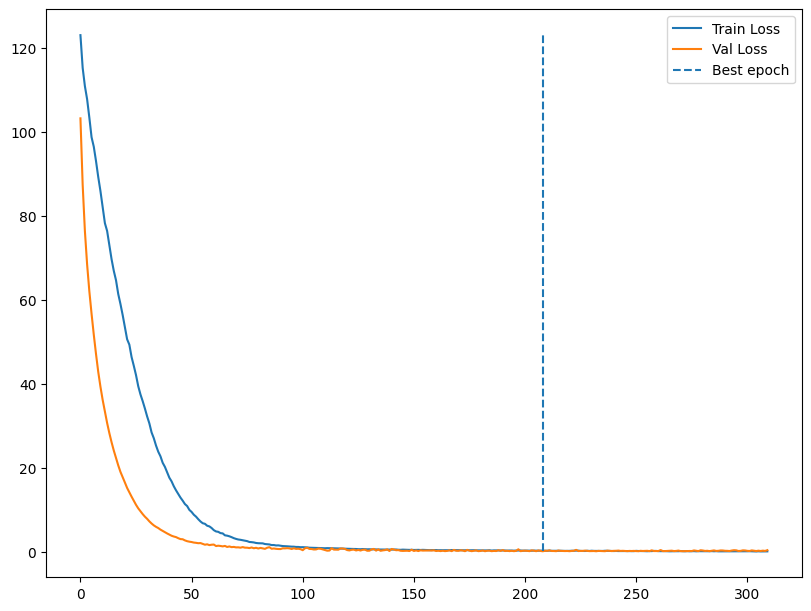

(20000, 555)
(20000,)
Train - f1=0.8256 recall=0.7320 precision=0.9467 log-loss=0.3327 opt-log-loss=0.1612
(20000, 62)
(20000,)
Test  - f1=0.8182 recall=0.8182 precision=0.8182 log-loss=0.2887 opt-log-loss=0.1887

-- Fold # 4/10 -Repeat #6/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.4163 - Val: 0.2469 at epoch 182.
Restore the best model.


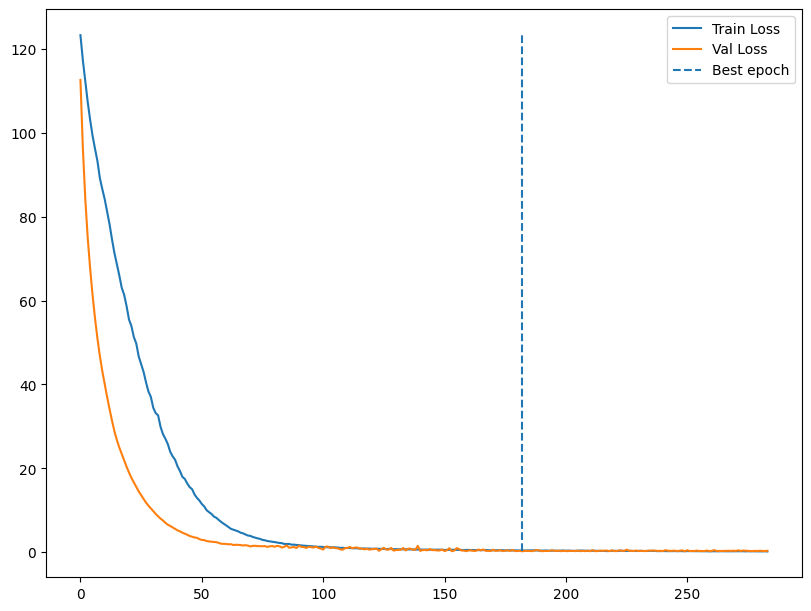

(20000, 555)
(20000,)
Train - f1=0.8444 recall=0.7835 precision=0.9157 log-loss=0.3312 opt-log-loss=0.1981
(20000, 62)
(20000,)
Test  - f1=0.8696 recall=0.9091 precision=0.8333 log-loss=0.3209 opt-log-loss=0.2497

-- Fold # 4/10 -Repeat #7/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3240 - Val: 0.3109 at epoch 223.
Restore the best model.


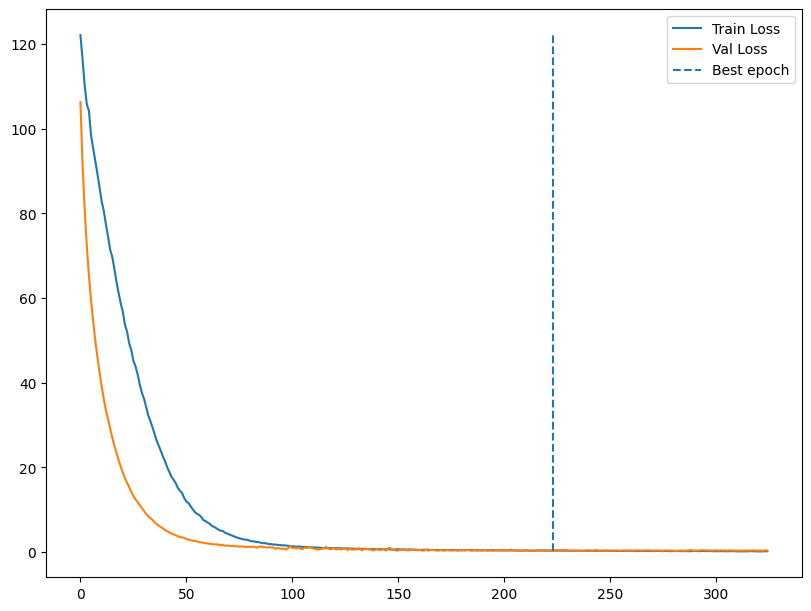

(20000, 555)
(20000,)
Train - f1=0.8984 recall=0.8660 precision=0.9333 log-loss=0.2115 opt-log-loss=0.1321
(20000, 62)
(20000,)
Test  - f1=0.7619 recall=0.7273 precision=0.8000 log-loss=0.4048 opt-log-loss=0.2862

-- Fold # 4/10 -Repeat #8/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.4339 - Val: 0.2501 at epoch 190.
Restore the best model.


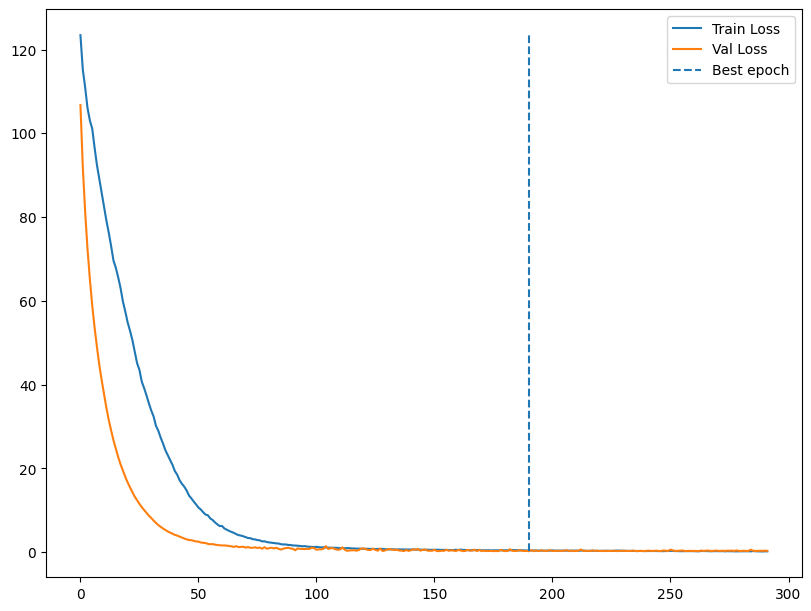

(20000, 555)
(20000,)
Train - f1=0.8649 recall=0.8247 precision=0.9091 log-loss=0.2714 opt-log-loss=0.1668
(20000, 62)
(20000,)
Test  - f1=0.7619 recall=0.7273 precision=0.8000 log-loss=0.3124 opt-log-loss=0.2185

-- Fold # 4/10 -Repeat #9/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.4100 - Val: 0.2436 at epoch 191.
Restore the best model.


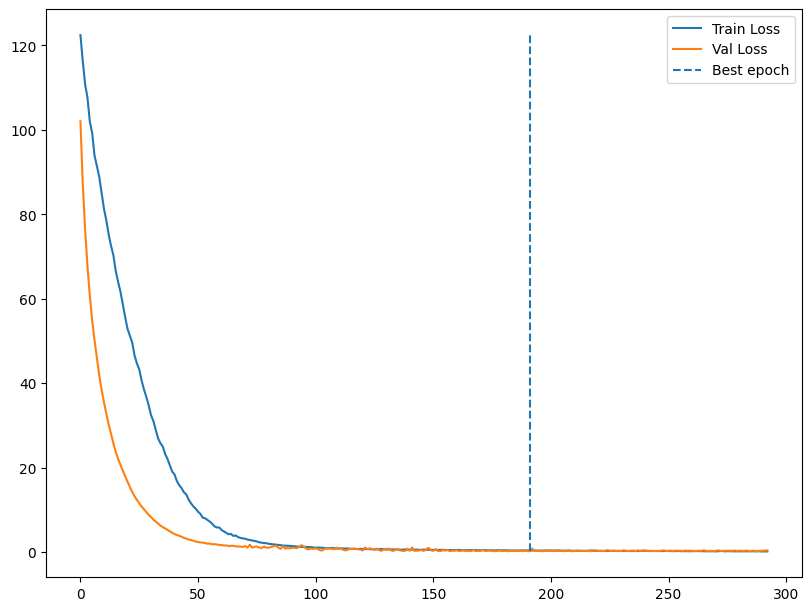

(20000, 555)
(20000,)
Train - f1=0.9215 recall=0.9072 precision=0.9362 log-loss=0.1991 opt-log-loss=0.1414
(20000, 62)
(20000,)
Test  - f1=0.7826 recall=0.8182 precision=0.7500 log-loss=0.3022 opt-log-loss=0.2252

-- Fold # 4/10 -Repeat #10/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2846 - Val: 0.2569 at epoch 266.
Restore the best model.


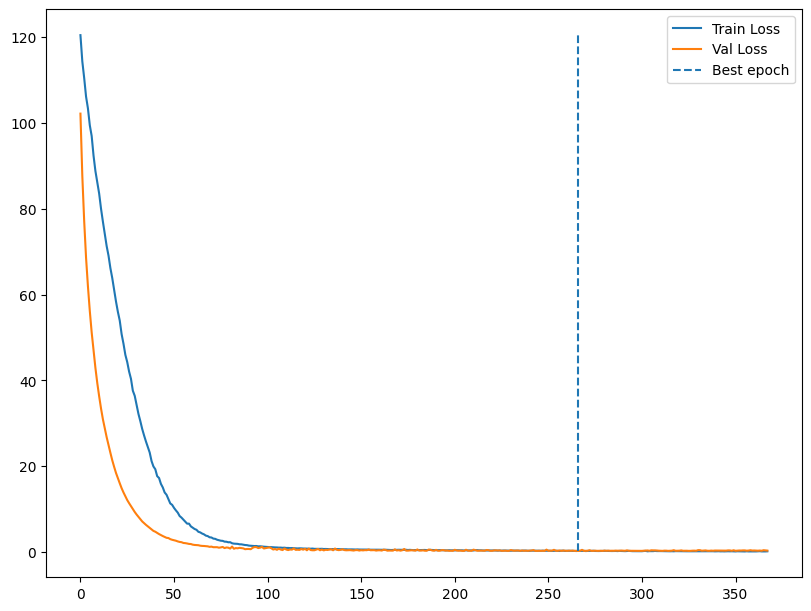

(20000, 555)
(20000,)
Train - f1=0.9694 recall=0.9794 precision=0.9596 log-loss=0.1265 opt-log-loss=0.0757
(20000, 62)
(20000,)
Test  - f1=0.7826 recall=0.8182 precision=0.7500 log-loss=0.3215 opt-log-loss=0.2499

-- Fold # 5/10 -Repeat #1/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3663 - Val: 0.2028 at epoch 212.
Restore the best model.


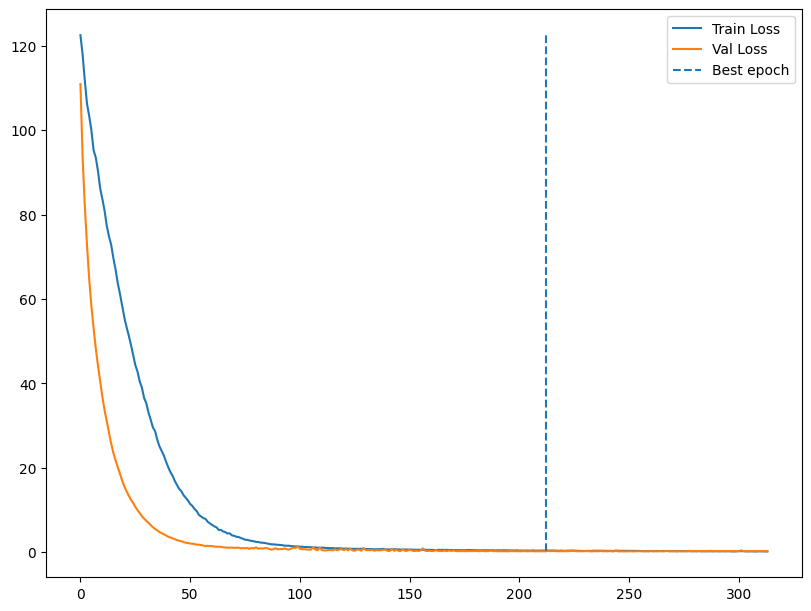

(20000, 555)
(20000,)
Train - f1=0.8716 recall=0.9794 precision=0.7851 log-loss=0.1150 opt-log-loss=0.1447
(20000, 62)
(20000,)
Test  - f1=0.8000 recall=0.7273 precision=0.8889 log-loss=0.2610 opt-log-loss=0.1849

-- Fold # 5/10 -Repeat #2/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2126 - Val: 0.2050 at epoch 289.
Restore the best model.


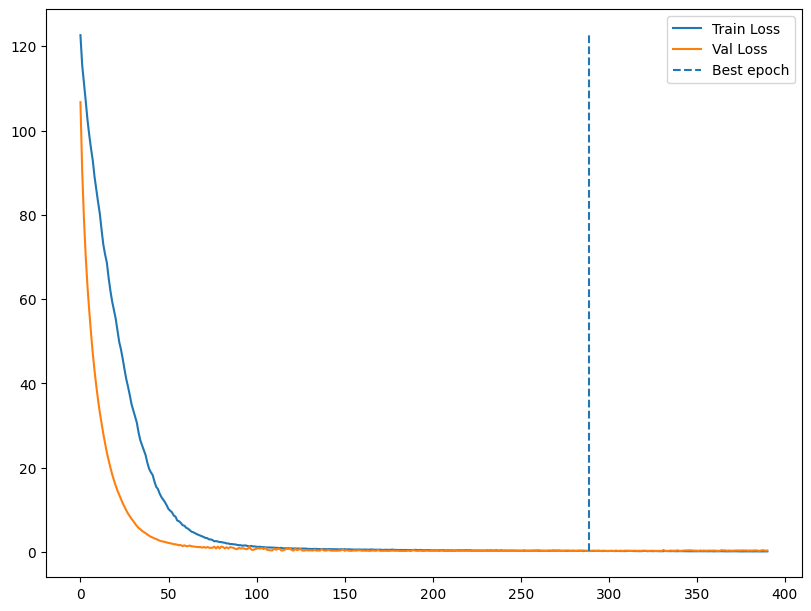

(20000, 555)
(20000,)
Train - f1=0.9600 recall=0.9897 precision=0.9320 log-loss=0.0409 opt-log-loss=0.0636
(20000, 62)
(20000,)
Test  - f1=0.9091 recall=0.9091 precision=0.9091 log-loss=0.2127 opt-log-loss=0.1683

-- Fold # 5/10 -Repeat #3/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2293 - Val: 0.1527 at epoch 272.
Restore the best model.


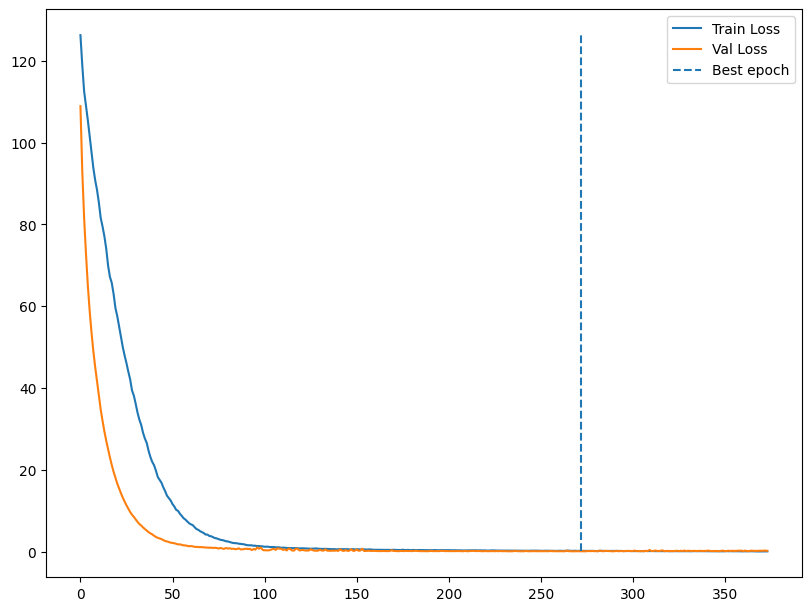

(20000, 555)
(20000,)
Train - f1=0.9652 recall=1.0000 precision=0.9327 log-loss=0.0454 opt-log-loss=0.0677
(20000, 62)
(20000,)
Test  - f1=0.9091 recall=0.9091 precision=0.9091 log-loss=0.1978 opt-log-loss=0.1308

-- Fold # 5/10 -Repeat #4/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3222 - Val: 0.2119 at epoch 238.
Restore the best model.


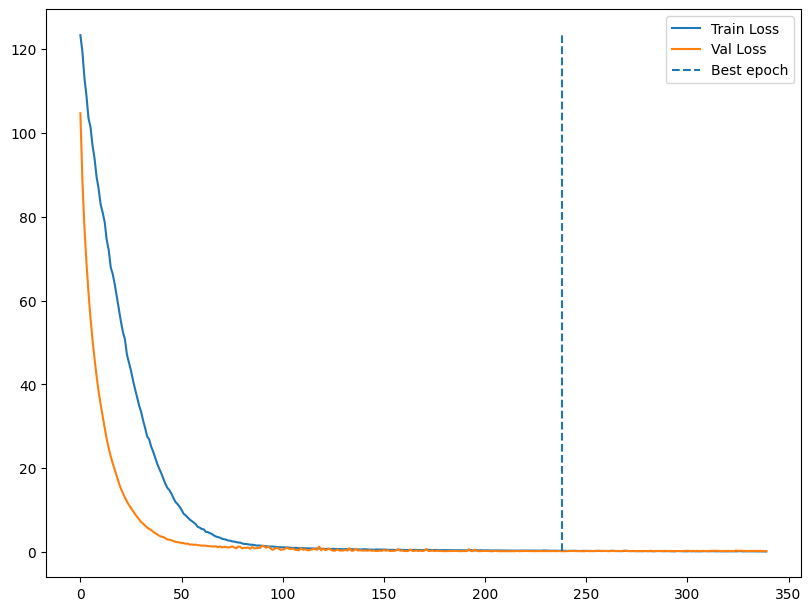

(20000, 555)
(20000,)
Train - f1=0.9065 recall=1.0000 precision=0.8291 log-loss=0.0757 opt-log-loss=0.1236
(20000, 62)
(20000,)
Test  - f1=0.8571 recall=0.8182 precision=0.9000 log-loss=0.2050 opt-log-loss=0.1739

-- Fold # 5/10 -Repeat #5/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2971 - Val: 0.2061 at epoch 237.
Restore the best model.


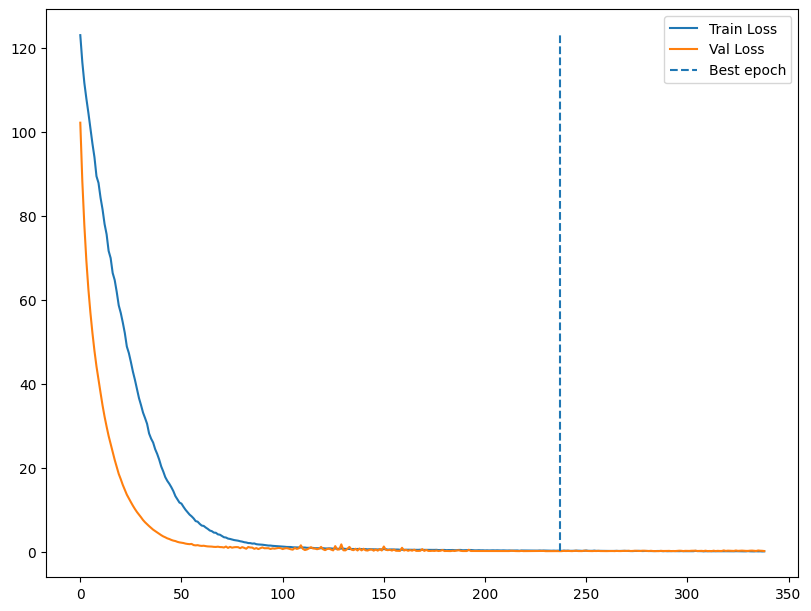

(20000, 555)
(20000,)
Train - f1=0.9057 recall=0.9897 precision=0.8348 log-loss=0.0831 opt-log-loss=0.1180
(20000, 62)
(20000,)
Test  - f1=0.8333 recall=0.9091 precision=0.7692 log-loss=0.2118 opt-log-loss=0.1637

-- Fold # 5/10 -Repeat #6/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2274 - Val: 0.2167 at epoch 290.
Restore the best model.


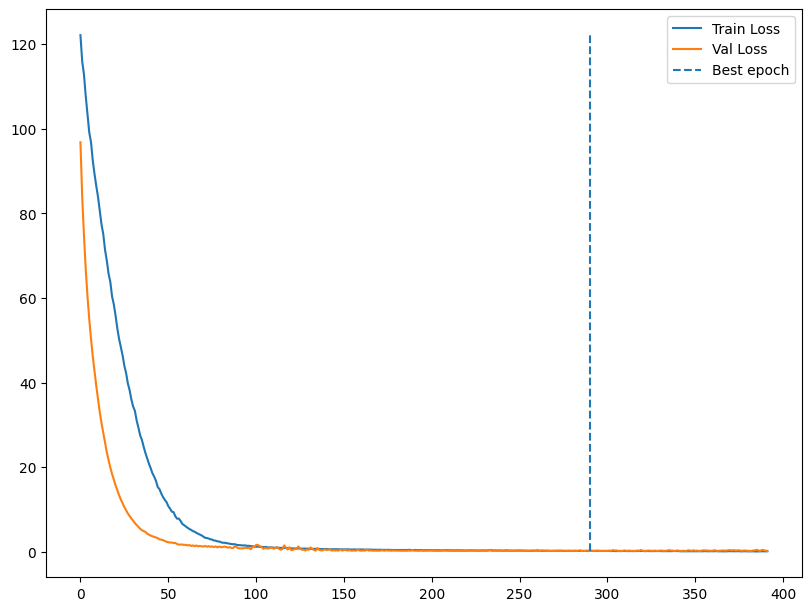

(20000, 555)
(20000,)
Train - f1=0.9652 recall=1.0000 precision=0.9327 log-loss=0.0491 opt-log-loss=0.0793
(20000, 62)
(20000,)
Test  - f1=0.8182 recall=0.8182 precision=0.8182 log-loss=0.2165 opt-log-loss=0.1769

-- Fold # 5/10 -Repeat #7/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3404 - Val: 0.1957 at epoch 236.
Restore the best model.


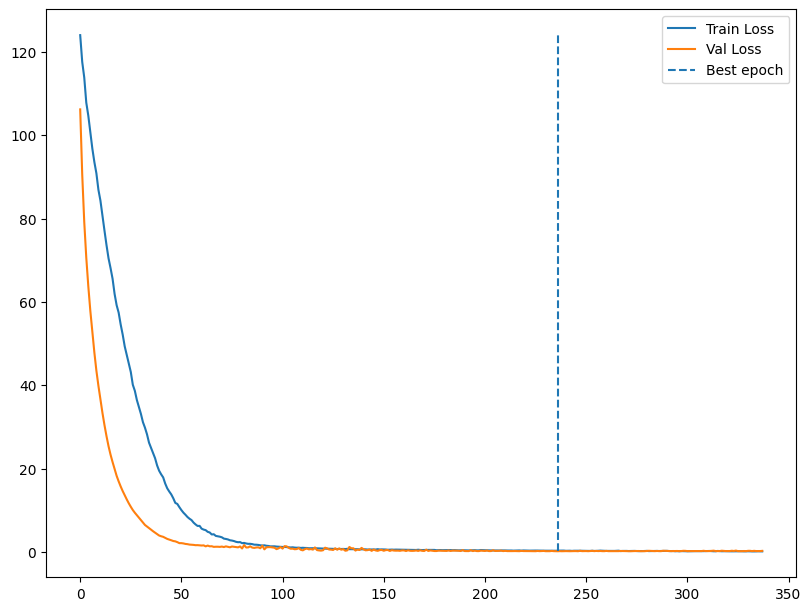

(20000, 555)
(20000,)
Train - f1=0.9293 recall=0.9485 precision=0.9109 log-loss=0.1101 opt-log-loss=0.1129
(20000, 62)
(20000,)
Test  - f1=0.7619 recall=0.7273 precision=0.8000 log-loss=0.2696 opt-log-loss=0.1847

-- Fold # 5/10 -Repeat #8/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1403 - Val: 0.1558 at epoch 338.
Restore the best model.


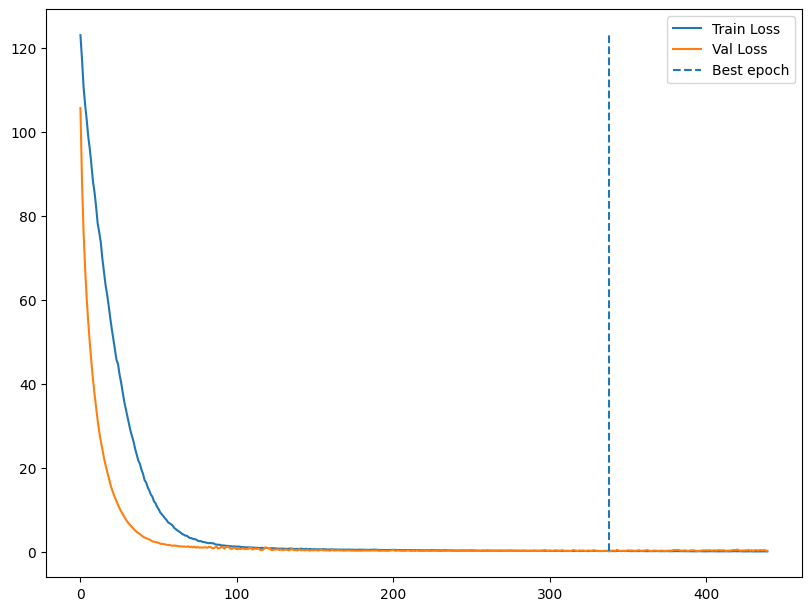

(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.0191 opt-log-loss=0.0263
(20000, 62)
(20000,)
Test  - f1=0.8571 recall=0.8182 precision=0.9000 log-loss=0.1940 opt-log-loss=0.1101

-- Fold # 5/10 -Repeat #9/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1853 - Val: 0.2066 at epoch 312.
Restore the best model.


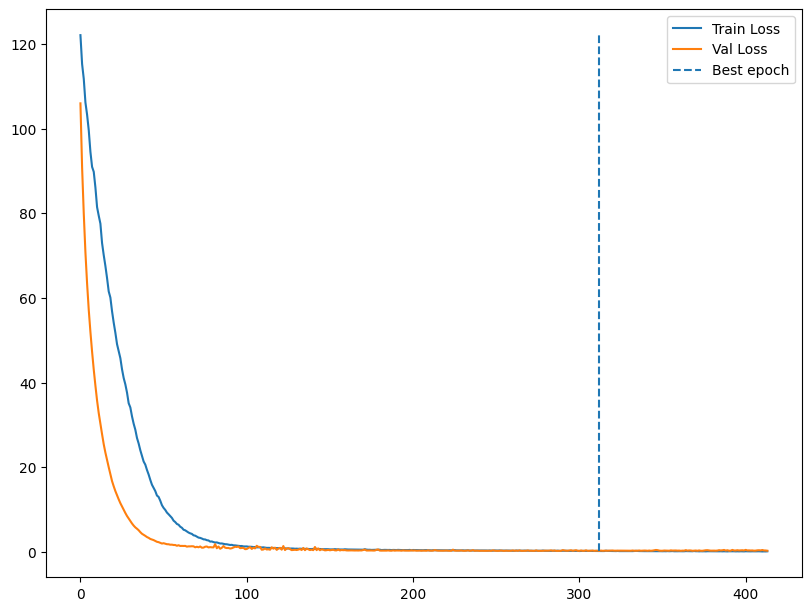

(20000, 555)
(20000,)
Train - f1=0.9949 recall=1.0000 precision=0.9898 log-loss=0.0243 opt-log-loss=0.0389
(20000, 62)
(20000,)
Test  - f1=0.8000 recall=0.7273 precision=0.8889 log-loss=0.2657 opt-log-loss=0.1649

-- Fold # 5/10 -Repeat #10/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2068 - Val: 0.2123 at epoch 370.
Restore the best model.


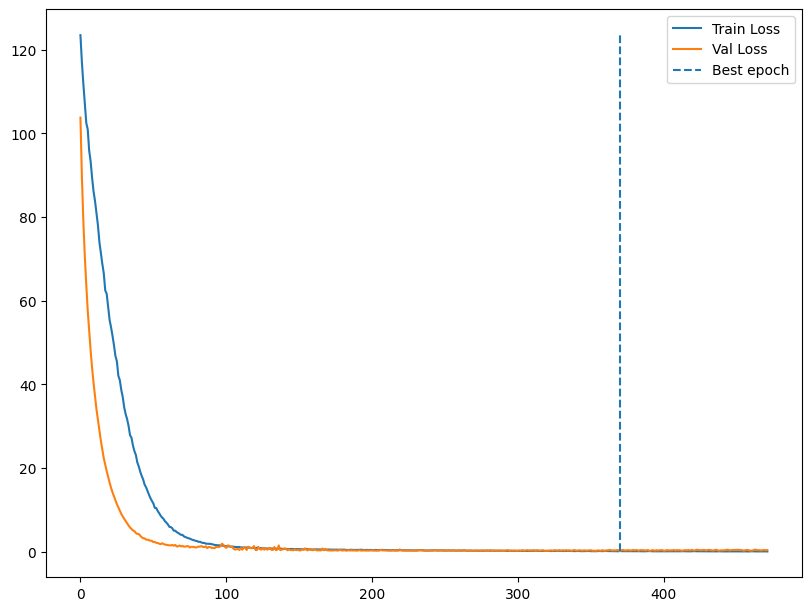

(20000, 555)
(20000,)
Train - f1=0.9949 recall=1.0000 precision=0.9898 log-loss=0.0109 opt-log-loss=0.0218
(20000, 62)
(20000,)
Test  - f1=0.7619 recall=0.7273 precision=0.8000 log-loss=0.2683 opt-log-loss=0.1814

-- Fold # 6/10 -Repeat #1/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2205 - Val: 0.4001 at epoch 265.
Restore the best model.


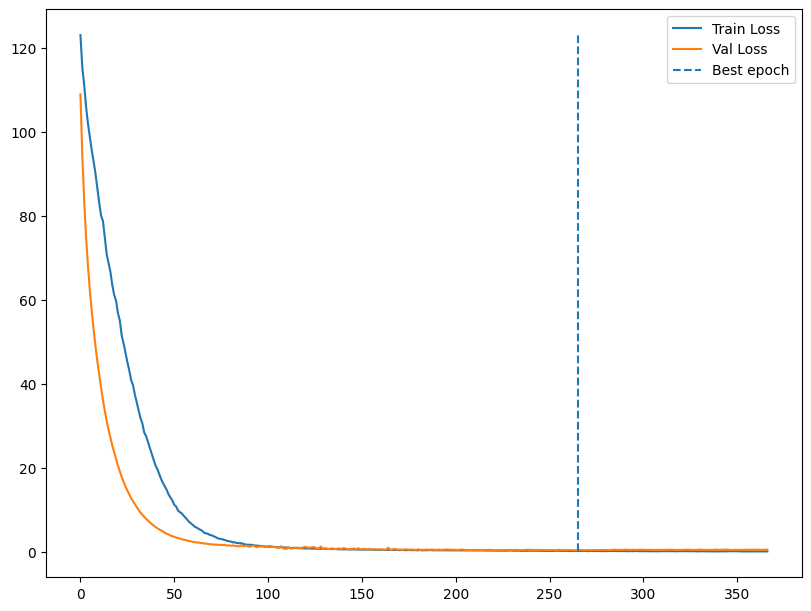

(20000, 555)
(20000,)
Train - f1=0.9592 recall=0.9691 precision=0.9495 log-loss=0.0960 opt-log-loss=0.0816
(20000, 62)
(20000,)
Test  - f1=0.6364 recall=0.6364 precision=0.6364 log-loss=0.5543 opt-log-loss=0.4173

-- Fold # 6/10 -Repeat #2/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1644 - Val: 0.3825 at epoch 310.
Restore the best model.


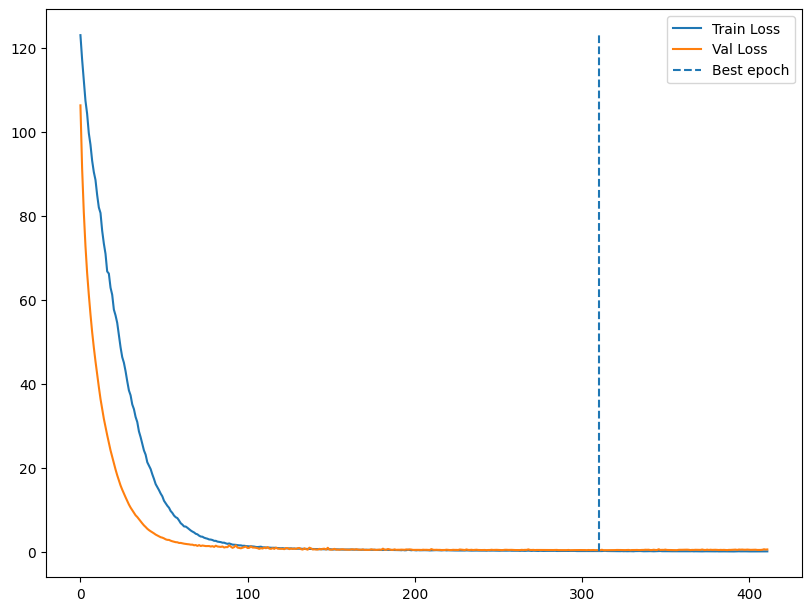

(20000, 555)
(20000,)
Train - f1=0.9792 recall=0.9691 precision=0.9895 log-loss=0.0912 opt-log-loss=0.0435
(20000, 62)
(20000,)
Test  - f1=0.6000 recall=0.5455 precision=0.6667 log-loss=0.6249 opt-log-loss=0.4528

-- Fold # 6/10 -Repeat #3/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2931 - Val: 0.4478 at epoch 242.
Restore the best model.


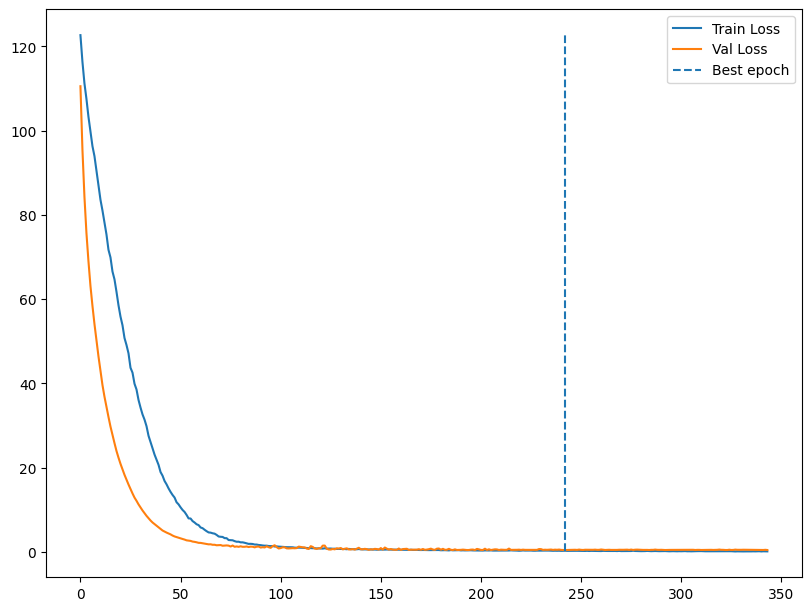

(20000, 555)
(20000,)
Train - f1=0.9485 recall=0.9485 precision=0.9485 log-loss=0.1309 opt-log-loss=0.0942
(20000, 62)
(20000,)
Test  - f1=0.5455 recall=0.5455 precision=0.5455 log-loss=0.6822 opt-log-loss=0.5151

-- Fold # 6/10 -Repeat #4/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3679 - Val: 0.4621 at epoch 216.
Restore the best model.


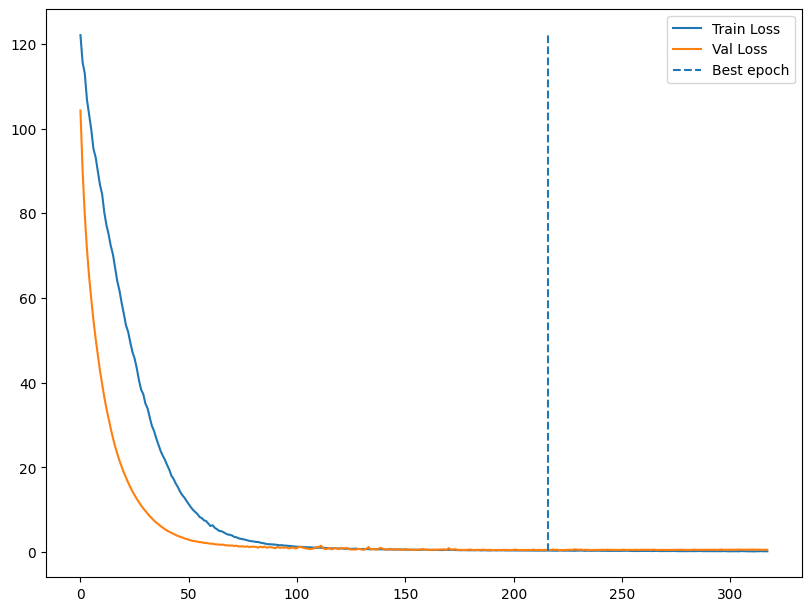

(20000, 555)
(20000,)
Train - f1=0.8995 recall=0.9691 precision=0.8393 log-loss=0.1354 opt-log-loss=0.1358
(20000, 62)
(20000,)
Test  - f1=0.6000 recall=0.5455 precision=0.6667 log-loss=0.5866 opt-log-loss=0.4433

-- Fold # 6/10 -Repeat #5/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2310 - Val: 0.4999 at epoch 267.
Restore the best model.


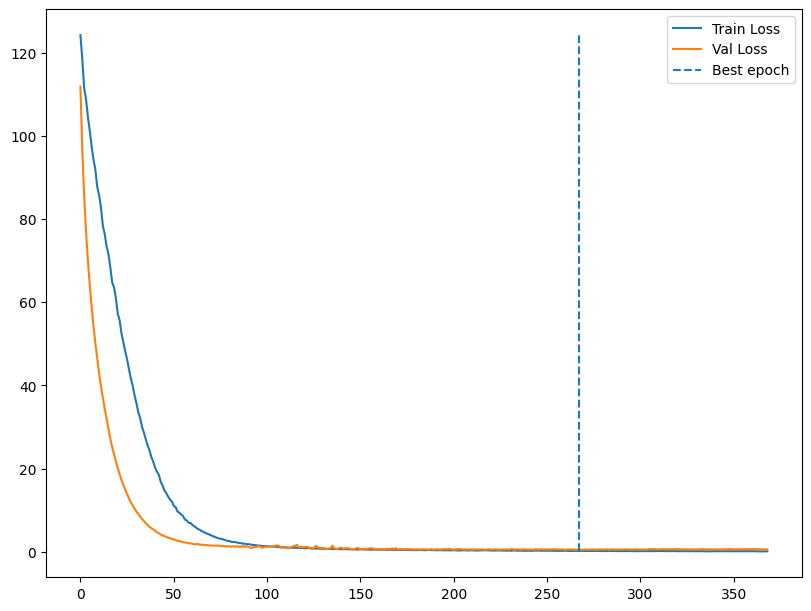

(20000, 555)
(20000,)
Train - f1=0.9458 recall=0.9897 precision=0.9057 log-loss=0.0585 opt-log-loss=0.0832
(20000, 62)
(20000,)
Test  - f1=0.5600 recall=0.6364 precision=0.5000 log-loss=0.6247 opt-log-loss=0.5301

-- Fold # 6/10 -Repeat #6/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2757 - Val: 0.3414 at epoch 265.
Restore the best model.


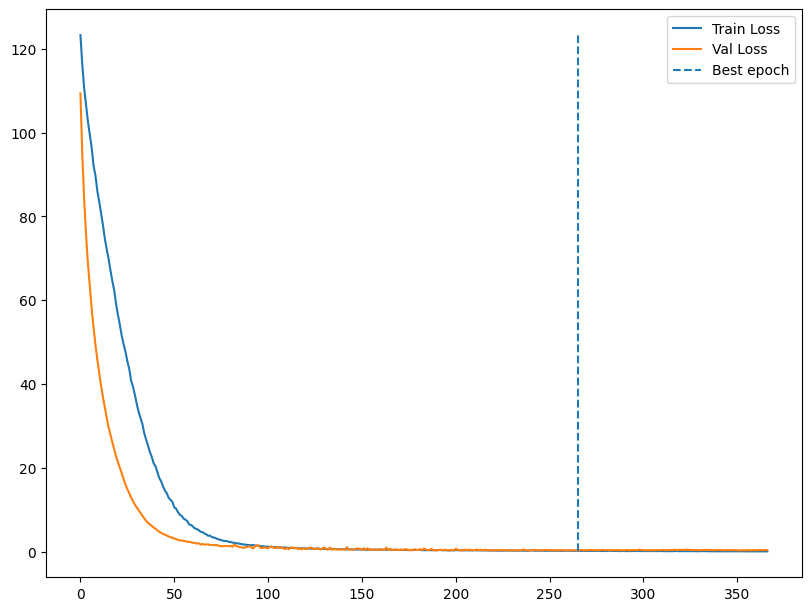

(20000, 555)
(20000,)
Train - f1=0.9645 recall=0.9794 precision=0.9500 log-loss=0.0622 opt-log-loss=0.0680
(20000, 62)
(20000,)
Test  - f1=0.6667 recall=0.6364 precision=0.7000 log-loss=0.4062 opt-log-loss=0.3247

-- Fold # 6/10 -Repeat #7/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.0895 - Val: 0.4918 at epoch 506.
Restore the best model.


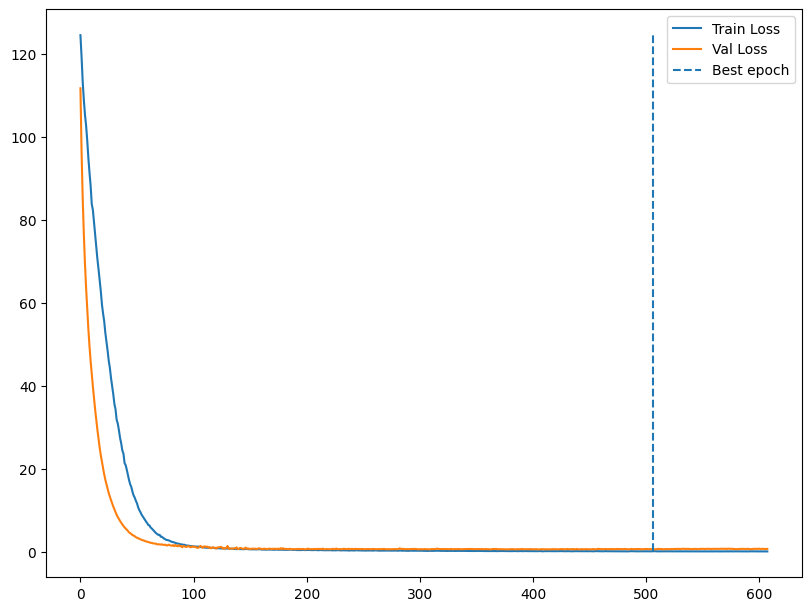

(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.0198 opt-log-loss=0.0103
(20000, 62)
(20000,)
Test  - f1=0.5714 recall=0.5455 precision=0.6000 log-loss=0.9176 opt-log-loss=0.6719

-- Fold # 6/10 -Repeat #8/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2713 - Val: 0.3962 at epoch 253.
Restore the best model.


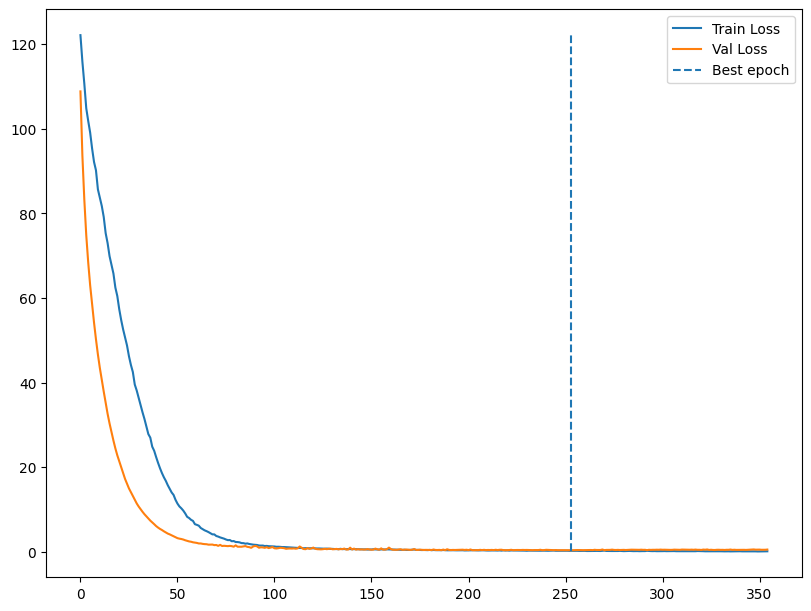

(20000, 555)
(20000,)
Train - f1=0.9548 recall=0.9794 precision=0.9314 log-loss=0.0707 opt-log-loss=0.0789
(20000, 62)
(20000,)
Test  - f1=0.6957 recall=0.7273 precision=0.6667 log-loss=0.4860 opt-log-loss=0.4089

-- Fold # 6/10 -Repeat #9/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.0646 - Val: 0.4288 at epoch 498.
Restore the best model.


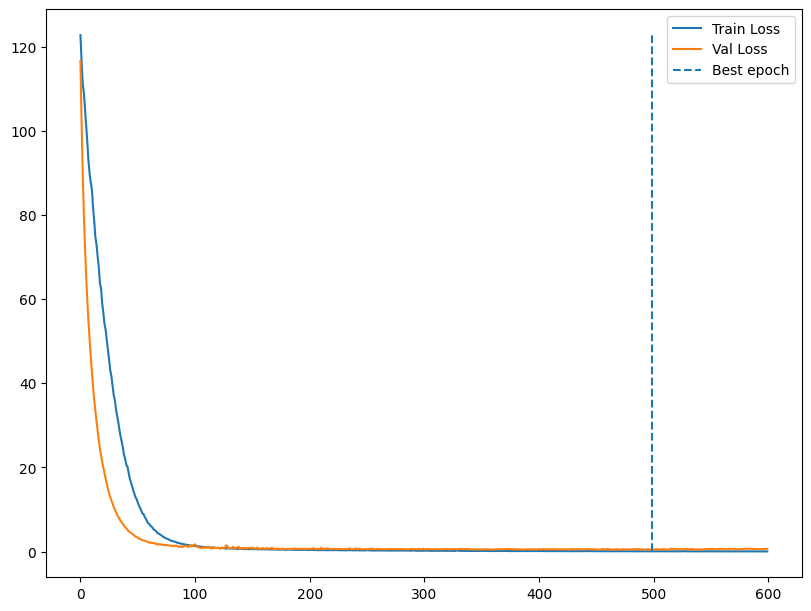

(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.0064 opt-log-loss=0.0158
(20000, 62)
(20000,)
Test  - f1=0.7273 recall=0.7273 precision=0.7273 log-loss=0.6542 opt-log-loss=0.5450

-- Fold # 6/10 -Repeat #10/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.4048 - Val: 0.4105 at epoch 198.
Restore the best model.


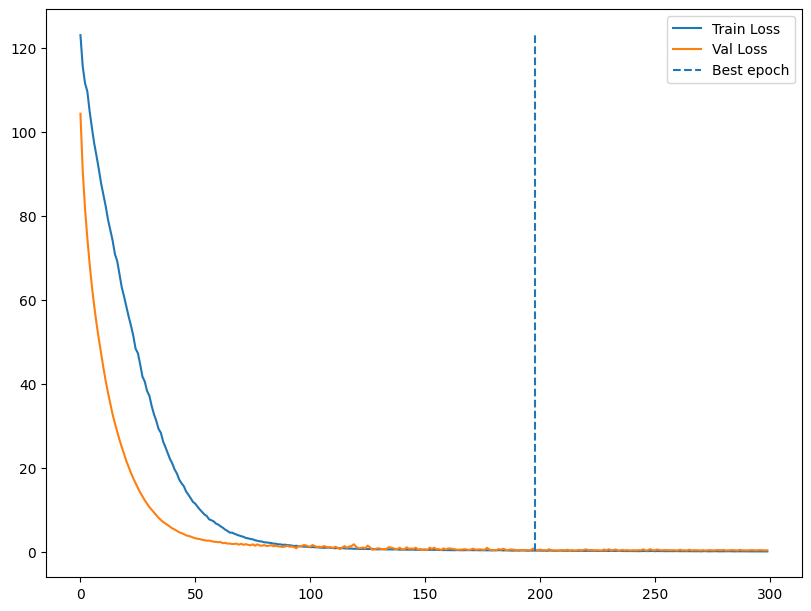

(20000, 555)
(20000,)
Train - f1=0.8619 recall=0.8041 precision=0.9286 log-loss=0.2285 opt-log-loss=0.1494
(20000, 62)
(20000,)
Test  - f1=0.6087 recall=0.6364 precision=0.5833 log-loss=0.4745 opt-log-loss=0.3587

-- Fold # 7/10 -Repeat #1/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.7167 - Val: 0.5030 at epoch 130.
Restore the best model.


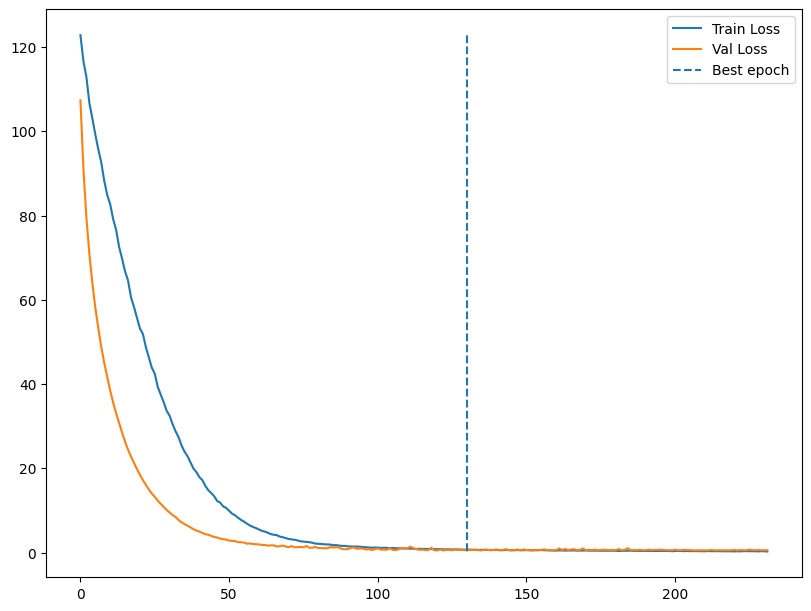

(20000, 555)
(20000,)
Train - f1=0.7772 recall=0.7732 precision=0.7812 log-loss=0.3572 opt-log-loss=0.2934
(20000, 62)
(20000,)
Test  - f1=0.6000 recall=0.5455 precision=0.6667 log-loss=0.7560 opt-log-loss=0.5754

-- Fold # 7/10 -Repeat #2/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3156 - Val: 0.4107 at epoch 223.
Restore the best model.


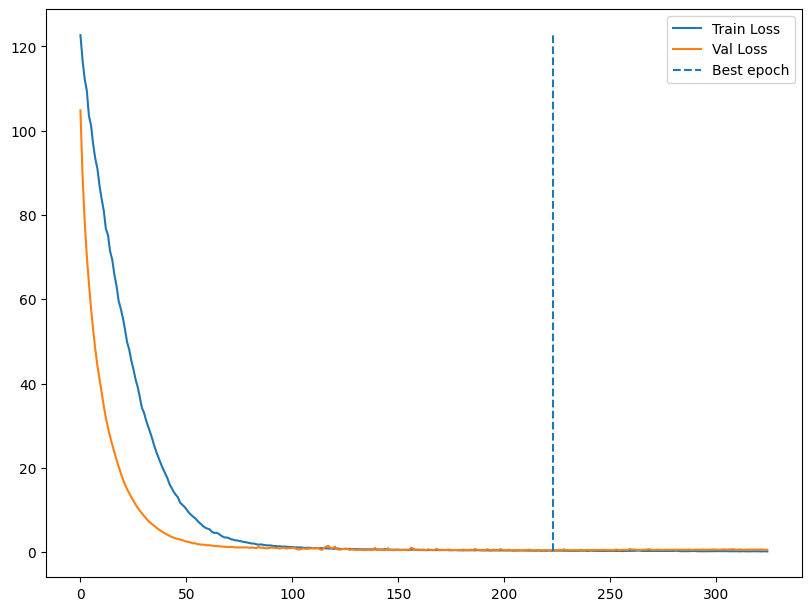

(20000, 555)
(20000,)
Train - f1=0.9442 recall=0.9588 precision=0.9300 log-loss=0.1035 opt-log-loss=0.1039
(20000, 62)
(20000,)
Test  - f1=0.6667 recall=0.6364 precision=0.7000 log-loss=0.6643 opt-log-loss=0.5210

-- Fold # 7/10 -Repeat #3/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.4050 - Val: 0.4708 at epoch 201.
Restore the best model.


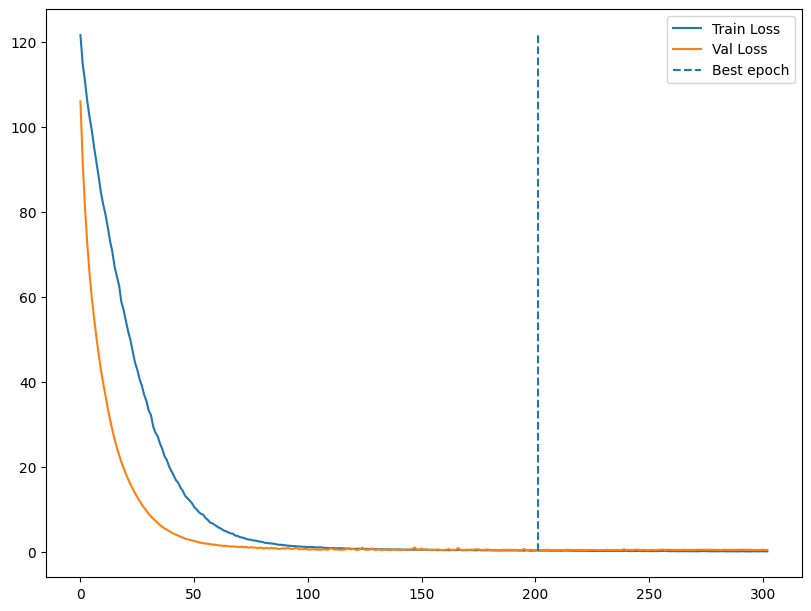

(20000, 555)
(20000,)
Train - f1=0.8942 recall=0.9588 precision=0.8378 log-loss=0.1509 opt-log-loss=0.1515
(20000, 62)
(20000,)
Test  - f1=0.5714 recall=0.5455 precision=0.6000 log-loss=0.7769 opt-log-loss=0.5884

-- Fold # 7/10 -Repeat #4/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3265 - Val: 0.5259 at epoch 258.
Restore the best model.


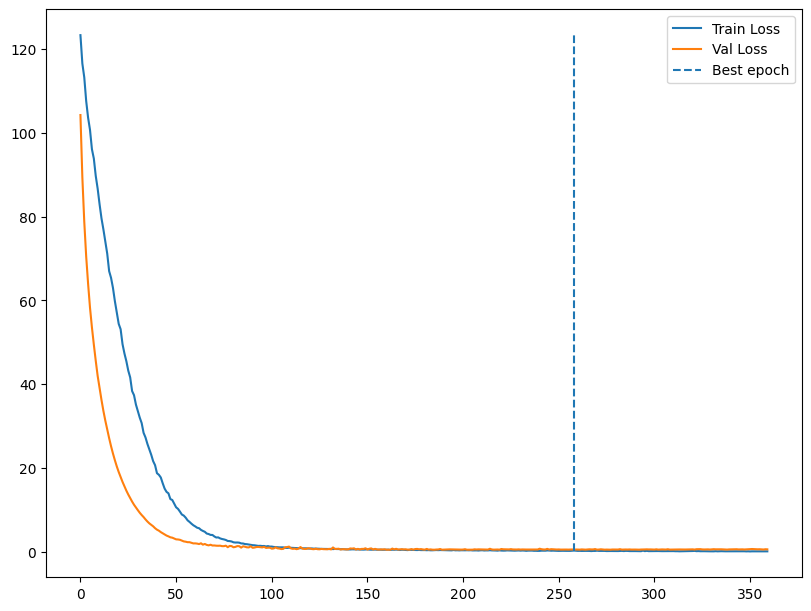

(20000, 555)
(20000,)
Train - f1=0.9744 recall=0.9794 precision=0.9694 log-loss=0.0817 opt-log-loss=0.0778
(20000, 62)
(20000,)
Test  - f1=0.6000 recall=0.5455 precision=0.6667 log-loss=0.9332 opt-log-loss=0.6970

-- Fold # 7/10 -Repeat #5/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3280 - Val: 0.4300 at epoch 240.
Restore the best model.


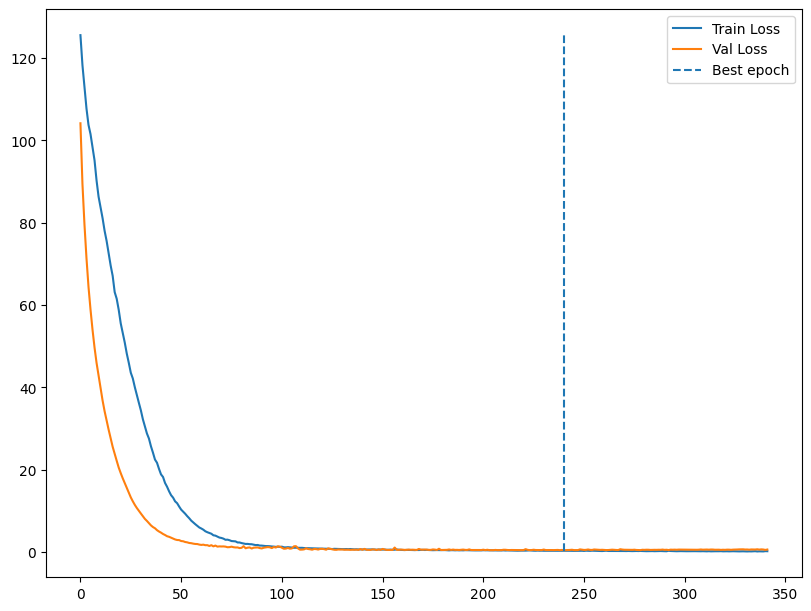

(20000, 555)
(20000,)
Train - f1=0.9485 recall=0.9485 precision=0.9485 log-loss=0.1418 opt-log-loss=0.1012
(20000, 62)
(20000,)
Test  - f1=0.5263 recall=0.4545 precision=0.6250 log-loss=0.8320 opt-log-loss=0.5336

-- Fold # 7/10 -Repeat #6/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.6756 - Val: 0.5409 at epoch 138.
Restore the best model.


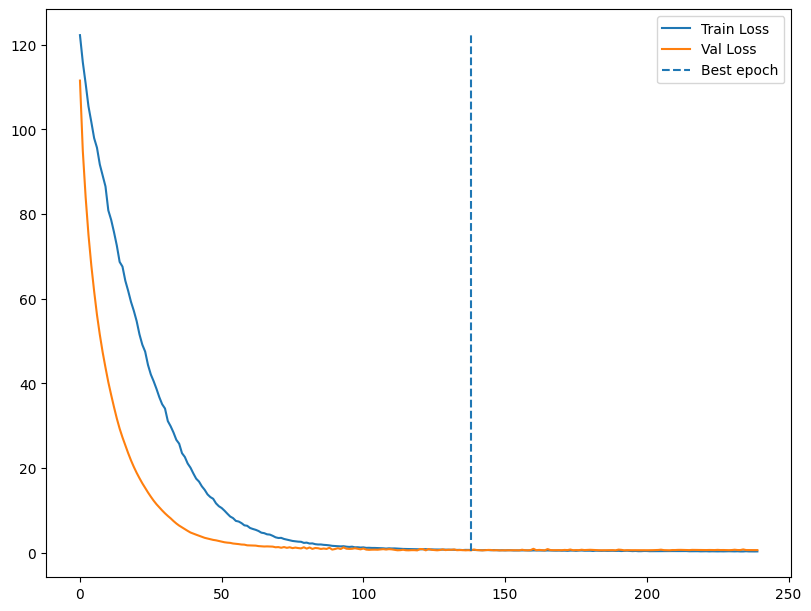

(20000, 555)
(20000,)
Train - f1=0.7636 recall=0.8660 precision=0.6829 log-loss=0.2673 opt-log-loss=0.2663
(20000, 62)
(20000,)
Test  - f1=0.5000 recall=0.4545 precision=0.5556 log-loss=0.9114 opt-log-loss=0.7136

-- Fold # 7/10 -Repeat #7/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.4289 - Val: 0.5972 at epoch 186.
Restore the best model.


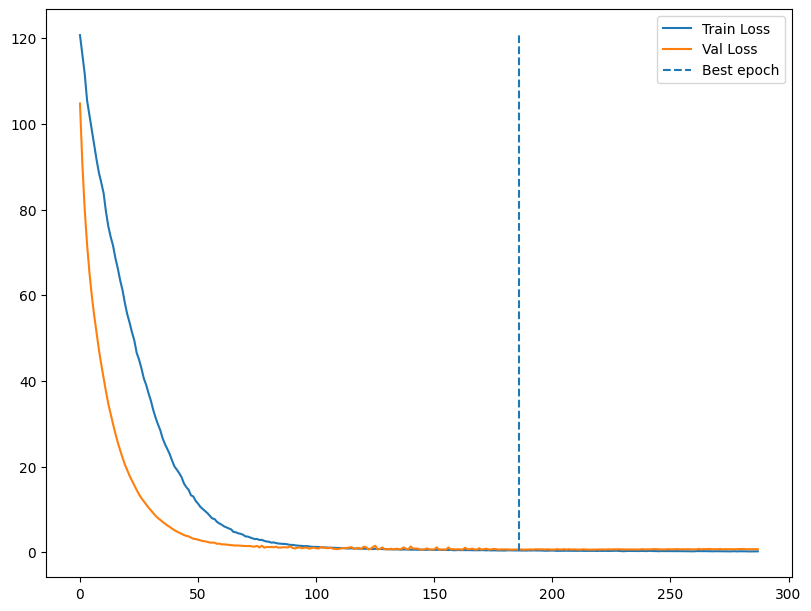

(20000, 555)
(20000,)
Train - f1=0.8651 recall=0.9588 precision=0.7881 log-loss=0.1811 opt-log-loss=0.1762
(20000, 62)
(20000,)
Test  - f1=0.4545 recall=0.4545 precision=0.4545 log-loss=1.0532 opt-log-loss=0.8223

-- Fold # 7/10 -Repeat #8/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.5596 - Val: 0.5305 at epoch 151.
Restore the best model.


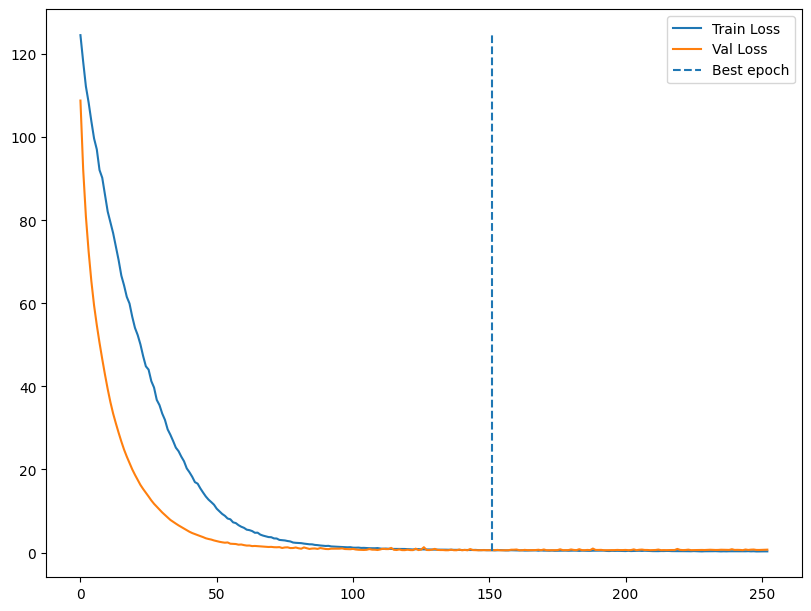

(20000, 555)
(20000,)
Train - f1=0.8148 recall=0.7938 precision=0.8370 log-loss=0.3200 opt-log-loss=0.2309
(20000, 62)
(20000,)
Test  - f1=0.6316 recall=0.5455 precision=0.7500 log-loss=1.0131 opt-log-loss=0.7294

-- Fold # 7/10 -Repeat #9/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.4226 - Val: 0.5478 at epoch 225.
Restore the best model.


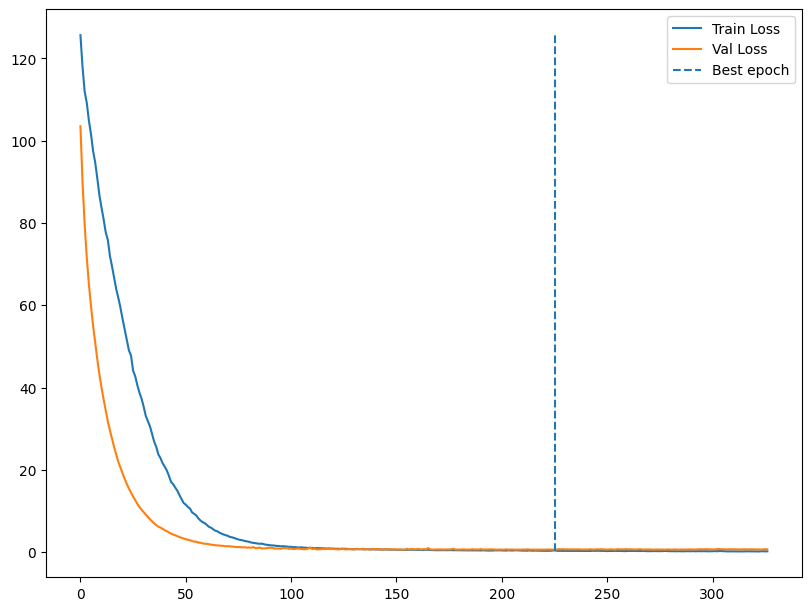

(20000, 555)
(20000,)
Train - f1=0.9254 recall=0.9588 precision=0.8942 log-loss=0.1606 opt-log-loss=0.1389
(20000, 62)
(20000,)
Test  - f1=0.5263 recall=0.4545 precision=0.6250 log-loss=0.9390 opt-log-loss=0.6676

-- Fold # 7/10 -Repeat #10/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.4719 - Val: 0.5118 at epoch 177.
Restore the best model.


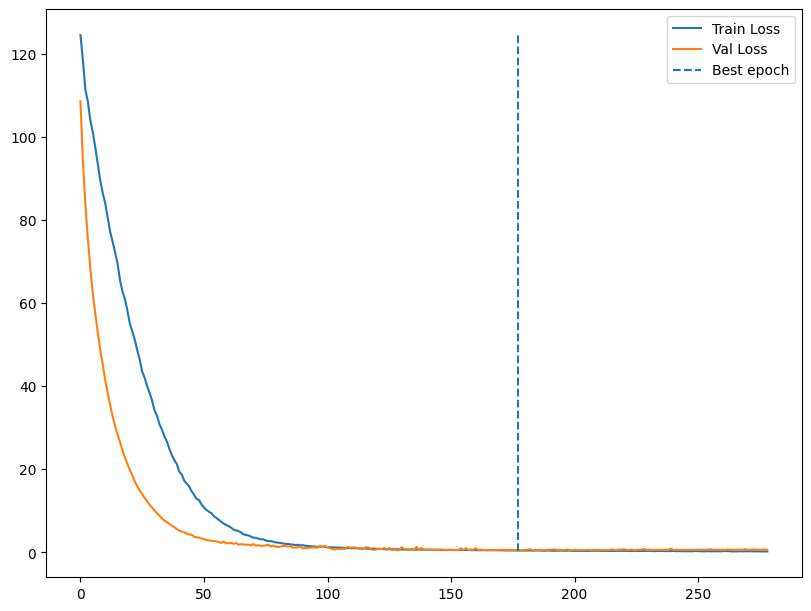

(20000, 555)
(20000,)
Train - f1=0.8585 recall=0.9381 precision=0.7913 log-loss=0.2067 opt-log-loss=0.1952
(20000, 62)
(20000,)
Test  - f1=0.5714 recall=0.5455 precision=0.6000 log-loss=0.8059 opt-log-loss=0.6207

-- Fold # 8/10 -Repeat #1/10:
Before sampling, has 556 sammples,
in which there are 97 positive samples.
After sampling, has 918 sammples,
in which there are 459 positive samples.
Number of important features:  82


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1700 - Val: 0.2785 at epoch 312.
Restore the best model.


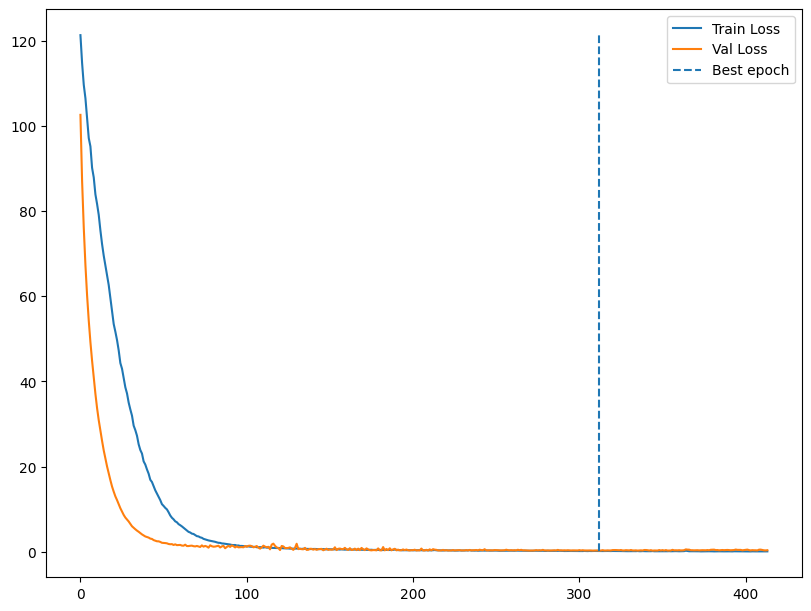

(20000, 556)
(20000,)
Train - f1=0.9846 recall=0.9897 precision=0.9796 log-loss=0.0291 opt-log-loss=0.0247
(20000, 61)
(20000,)
Test  - f1=0.7619 recall=0.7273 precision=0.8000 log-loss=0.3569 opt-log-loss=0.2343

-- Fold # 8/10 -Repeat #2/10:
Before sampling, has 556 sammples,
in which there are 97 positive samples.
After sampling, has 918 sammples,
in which there are 459 positive samples.
Number of important features:  82


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3337 - Val: 0.3487 at epoch 216.
Restore the best model.


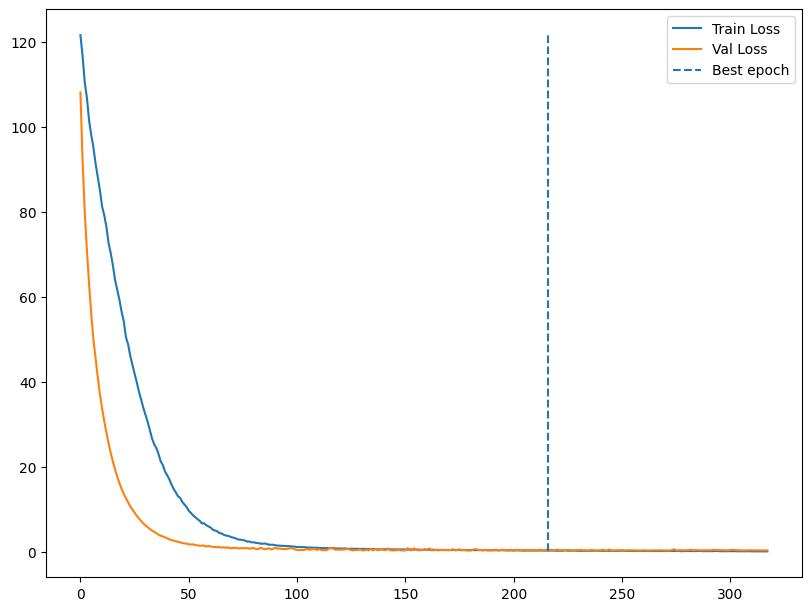

(20000, 556)
(20000,)
Train - f1=0.9347 recall=0.9588 precision=0.9118 log-loss=0.1128 opt-log-loss=0.1062
(20000, 61)
(20000,)
Test  - f1=0.7273 recall=0.7273 precision=0.7273 log-loss=0.3160 opt-log-loss=0.2676

-- Fold # 8/10 -Repeat #3/10:
Before sampling, has 556 sammples,
in which there are 97 positive samples.
After sampling, has 918 sammples,
in which there are 459 positive samples.
Number of important features:  82


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3832 - Val: 0.3369 at epoch 211.
Restore the best model.


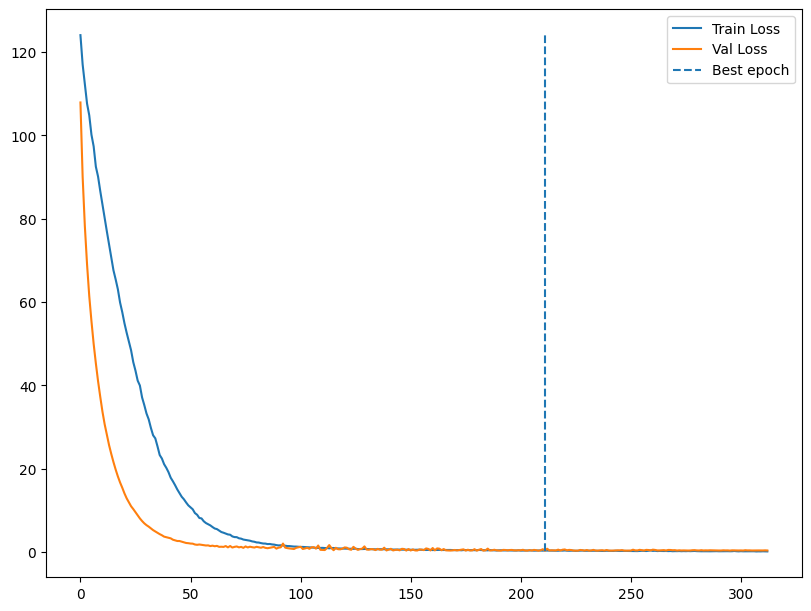

(20000, 556)
(20000,)
Train - f1=0.9091 recall=0.9278 precision=0.8911 log-loss=0.1324 opt-log-loss=0.1172
(20000, 61)
(20000,)
Test  - f1=0.6957 recall=0.7273 precision=0.6667 log-loss=0.3782 opt-log-loss=0.3078

-- Fold # 8/10 -Repeat #4/10:
Before sampling, has 556 sammples,
in which there are 97 positive samples.
After sampling, has 918 sammples,
in which there are 459 positive samples.
Number of important features:  82


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2335 - Val: 0.3309 at epoch 293.
Restore the best model.


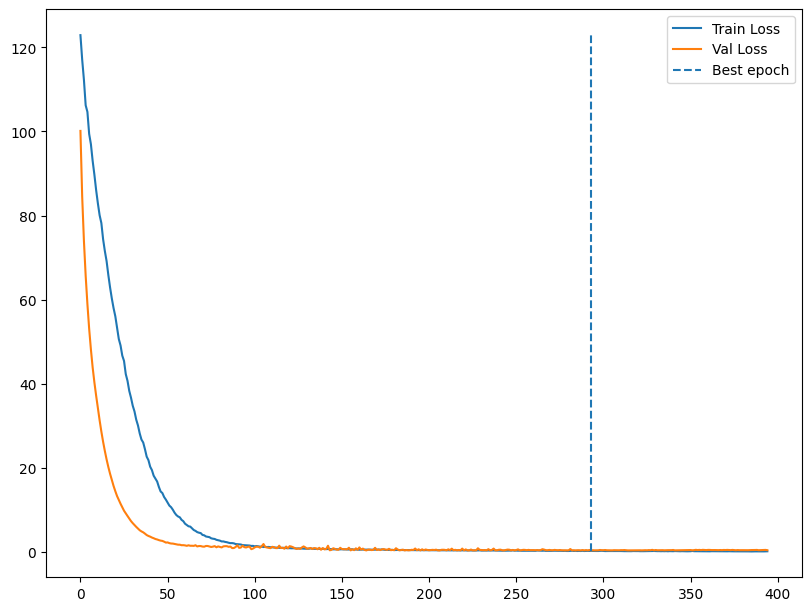

(20000, 556)
(20000,)
Train - f1=0.9746 recall=0.9897 precision=0.9600 log-loss=0.0380 opt-log-loss=0.0449
(20000, 61)
(20000,)
Test  - f1=0.7826 recall=0.8182 precision=0.7500 log-loss=0.3248 opt-log-loss=0.2760

-- Fold # 8/10 -Repeat #5/10:
Before sampling, has 556 sammples,
in which there are 97 positive samples.
After sampling, has 918 sammples,
in which there are 459 positive samples.
Number of important features:  82


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.4231 - Val: 0.3543 at epoch 186.
Restore the best model.


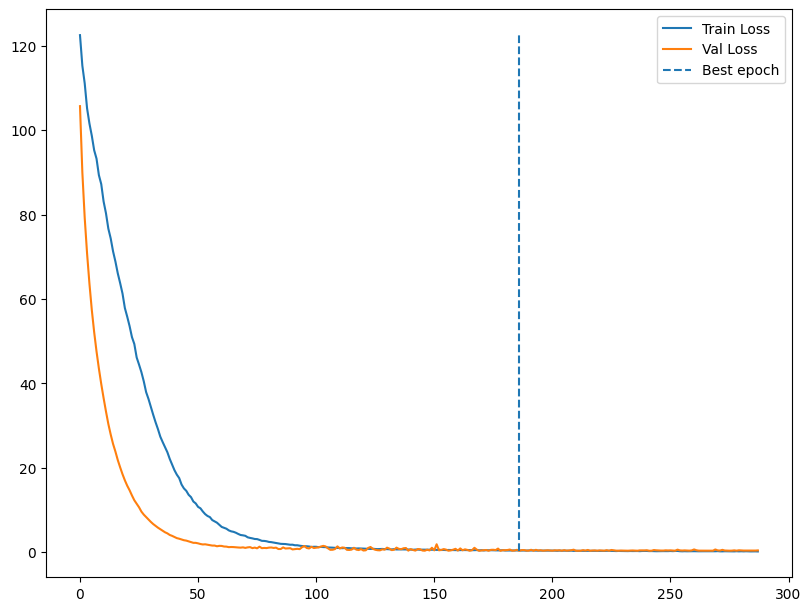

(20000, 556)
(20000,)
Train - f1=0.8857 recall=0.9588 precision=0.8230 log-loss=0.1486 opt-log-loss=0.1466
(20000, 61)
(20000,)
Test  - f1=0.7273 recall=0.7273 precision=0.7273 log-loss=0.3795 opt-log-loss=0.3149

-- Fold # 8/10 -Repeat #6/10:
Before sampling, has 556 sammples,
in which there are 97 positive samples.
After sampling, has 918 sammples,
in which there are 459 positive samples.
Number of important features:  82


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.5043 - Val: 0.4285 at epoch 169.
Restore the best model.


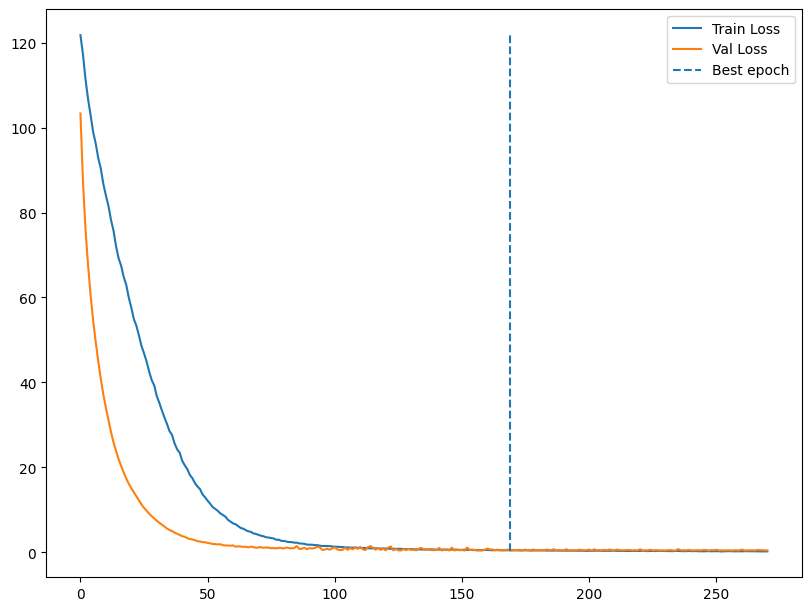

(20000, 556)
(20000,)
Train - f1=0.8268 recall=0.7629 precision=0.9024 log-loss=0.2725 opt-log-loss=0.1670
(20000, 61)
(20000,)
Test  - f1=0.6000 recall=0.5455 precision=0.6667 log-loss=0.6323 opt-log-loss=0.4326

-- Fold # 8/10 -Repeat #7/10:
Before sampling, has 556 sammples,
in which there are 97 positive samples.
After sampling, has 918 sammples,
in which there are 459 positive samples.
Number of important features:  82


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3929 - Val: 0.3141 at epoch 198.
Restore the best model.


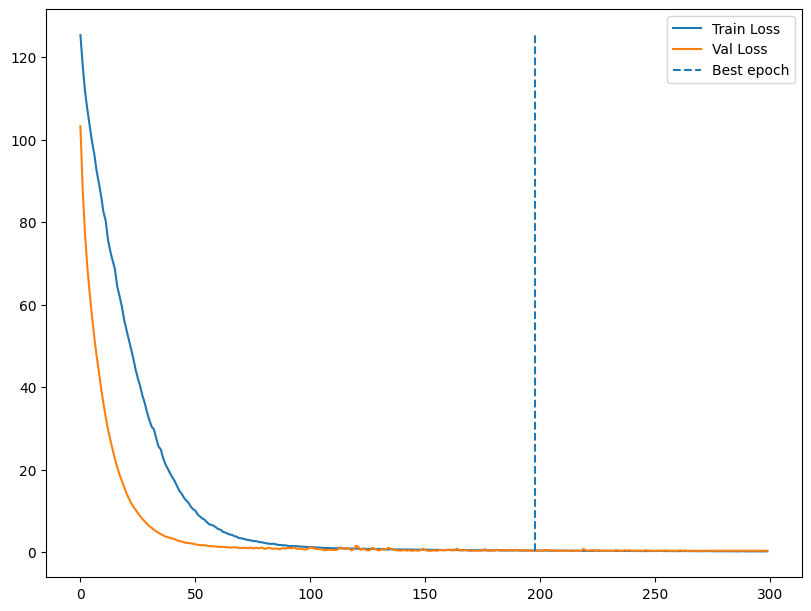

(20000, 556)
(20000,)
Train - f1=0.8923 recall=0.8969 precision=0.8878 log-loss=0.1482 opt-log-loss=0.1212
(20000, 61)
(20000,)
Test  - f1=0.7619 recall=0.7273 precision=0.8000 log-loss=0.4100 opt-log-loss=0.3197

-- Fold # 8/10 -Repeat #8/10:
Before sampling, has 556 sammples,
in which there are 97 positive samples.
After sampling, has 918 sammples,
in which there are 459 positive samples.
Number of important features:  82


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3097 - Val: 0.3108 at epoch 224.
Restore the best model.


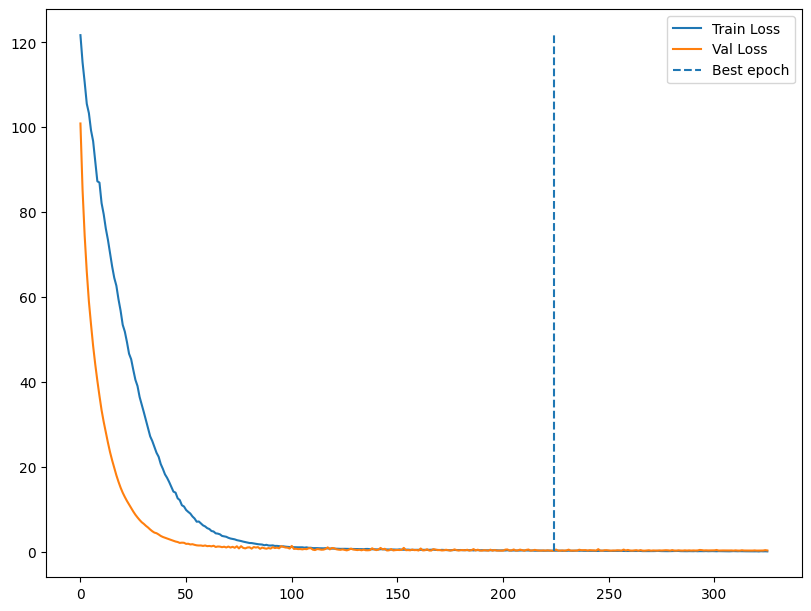

(20000, 556)
(20000,)
Train - f1=0.9548 recall=0.9794 precision=0.9314 log-loss=0.0850 opt-log-loss=0.0840
(20000, 61)
(20000,)
Test  - f1=0.7500 recall=0.8182 precision=0.6923 log-loss=0.2954 opt-log-loss=0.2648

-- Fold # 8/10 -Repeat #9/10:
Before sampling, has 556 sammples,
in which there are 97 positive samples.
After sampling, has 918 sammples,
in which there are 459 positive samples.
Number of important features:  82


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.4635 - Val: 0.3808 at epoch 181.
Restore the best model.


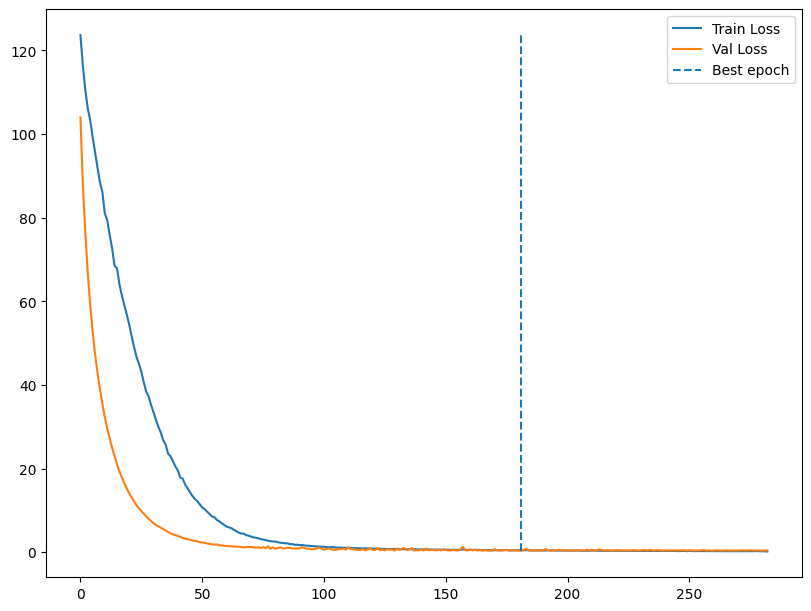

(20000, 556)
(20000,)
Train - f1=0.8612 recall=0.9278 precision=0.8036 log-loss=0.1692 opt-log-loss=0.1874
(20000, 61)
(20000,)
Test  - f1=0.6957 recall=0.7273 precision=0.6667 log-loss=0.4054 opt-log-loss=0.3671

-- Fold # 8/10 -Repeat #10/10:
Before sampling, has 556 sammples,
in which there are 97 positive samples.
After sampling, has 918 sammples,
in which there are 459 positive samples.
Number of important features:  82


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2542 - Val: 0.2982 at epoch 274.
Restore the best model.


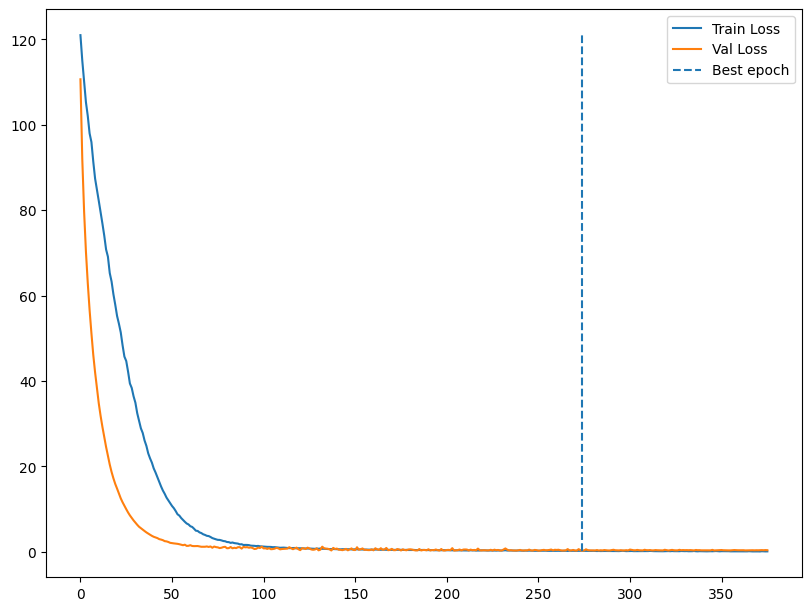

(20000, 556)
(20000,)
Train - f1=0.9794 recall=0.9794 precision=0.9794 log-loss=0.0603 opt-log-loss=0.0458
(20000, 61)
(20000,)
Test  - f1=0.8333 recall=0.9091 precision=0.7692 log-loss=0.3396 opt-log-loss=0.2850

-- Fold # 9/10 -Repeat #1/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.4855 - Val: 0.3980 at epoch 174.
Restore the best model.


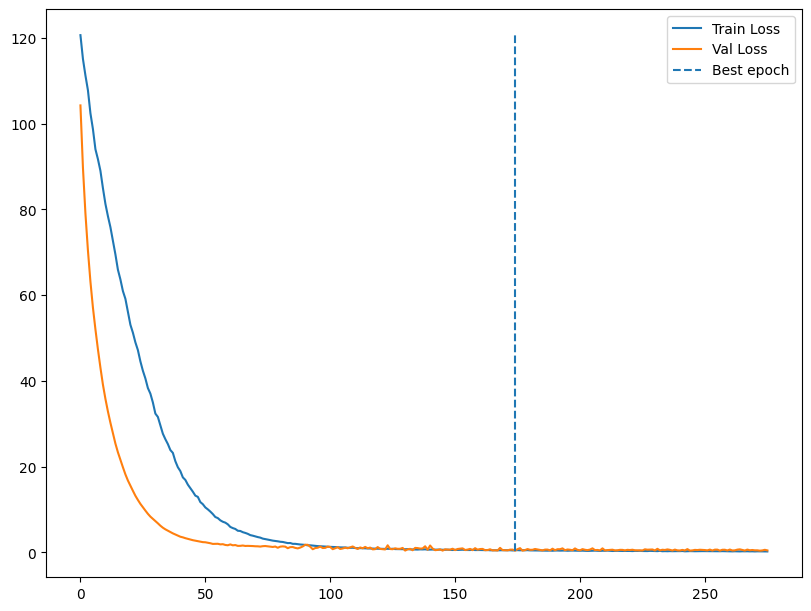

(20000, 556)
(20000,)
Train - f1=0.7602 recall=0.6633 precision=0.8904 log-loss=0.3329 opt-log-loss=0.1763
(20000, 61)
(20000,)
Test  - f1=0.7000 recall=0.7000 precision=0.7000 log-loss=0.6603 opt-log-loss=0.5322

-- Fold # 9/10 -Repeat #2/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3047 - Val: 0.3075 at epoch 247.
Restore the best model.


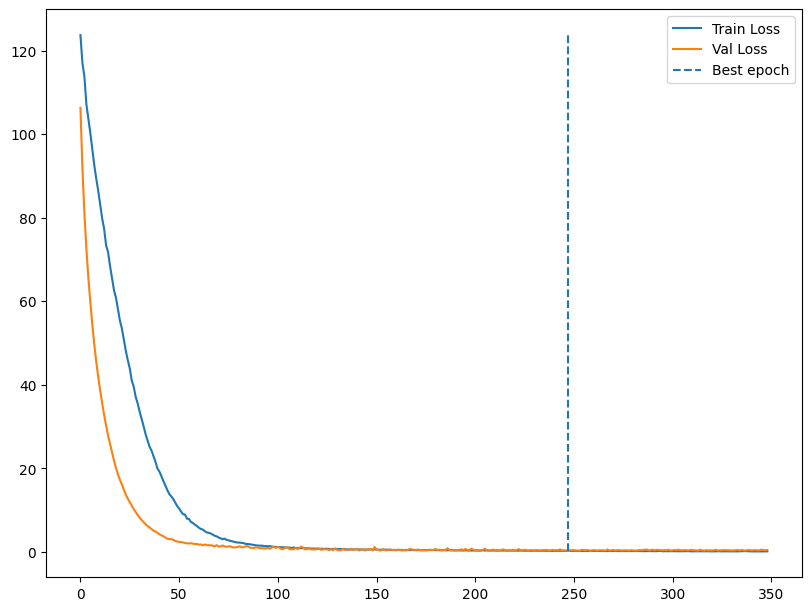

(20000, 556)
(20000,)
Train - f1=0.8876 recall=0.8061 precision=0.9875 log-loss=0.2227 opt-log-loss=0.0789
(20000, 61)
(20000,)
Test  - f1=0.8889 recall=0.8000 precision=1.0000 log-loss=0.5966 opt-log-loss=0.4455

-- Fold # 9/10 -Repeat #3/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.4820 - Val: 0.4260 at epoch 170.
Restore the best model.


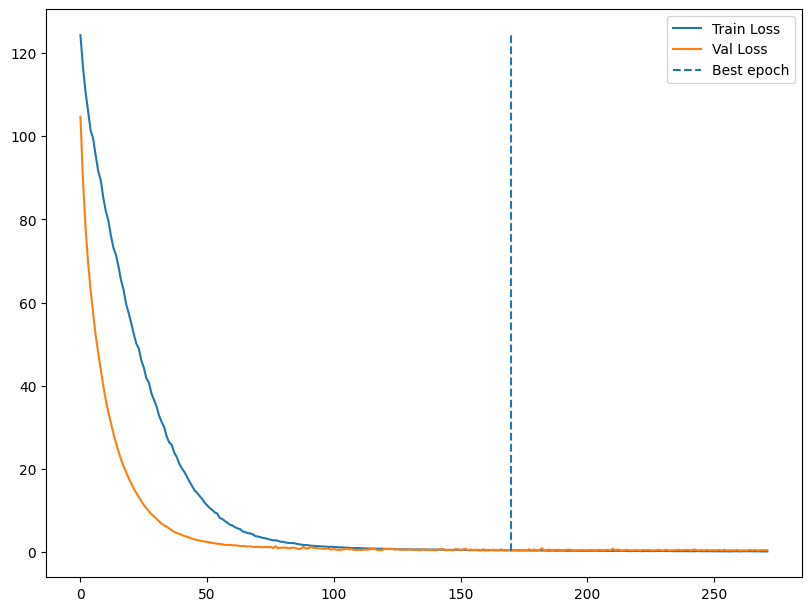

(20000, 556)
(20000,)
Train - f1=0.6829 recall=0.5714 precision=0.8485 log-loss=0.4018 opt-log-loss=0.1860
(20000, 61)
(20000,)
Test  - f1=0.6667 recall=0.6000 precision=0.7500 log-loss=0.7627 opt-log-loss=0.5564

-- Fold # 9/10 -Repeat #4/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.0966 - Val: 0.2853 at epoch 384.
Restore the best model.


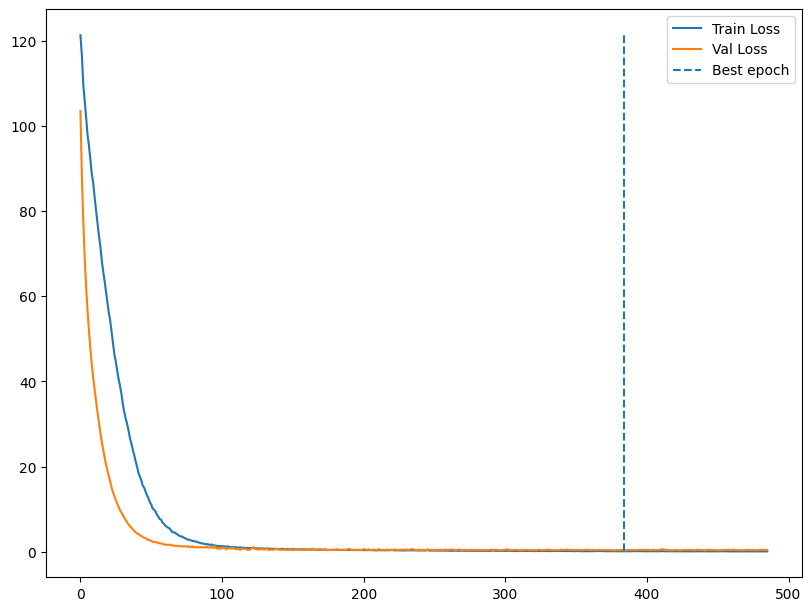

(20000, 556)
(20000,)
Train - f1=0.9949 recall=0.9898 precision=1.0000 log-loss=0.0754 opt-log-loss=0.0203
(20000, 61)
(20000,)
Test  - f1=0.8421 recall=0.8000 precision=0.8889 log-loss=0.5595 opt-log-loss=0.4078

-- Fold # 9/10 -Repeat #5/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3056 - Val: 0.3413 at epoch 248.
Restore the best model.


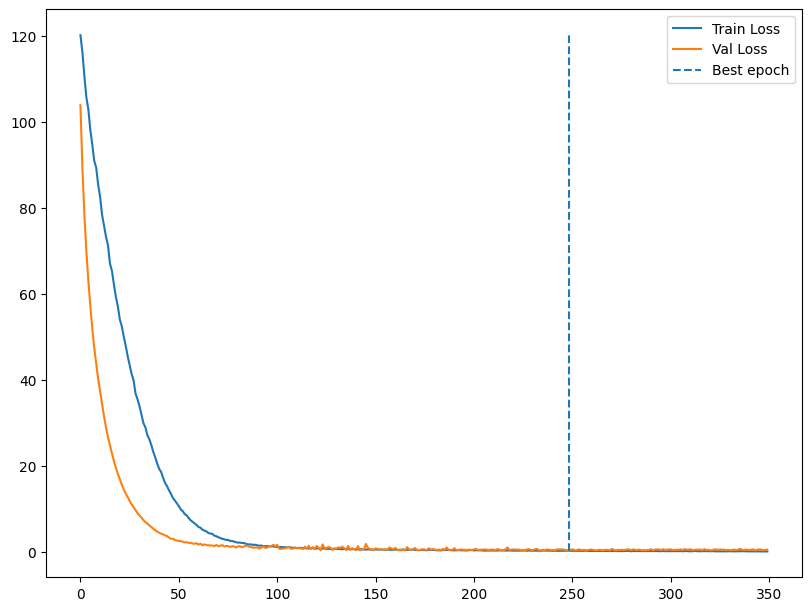

(20000, 556)
(20000,)
Train - f1=0.9688 recall=0.9490 precision=0.9894 log-loss=0.0931 opt-log-loss=0.0544
(20000, 61)
(20000,)
Test  - f1=0.7619 recall=0.8000 precision=0.7273 log-loss=0.6196 opt-log-loss=0.5366

-- Fold # 9/10 -Repeat #6/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1210 - Val: 0.3226 at epoch 365.
Restore the best model.


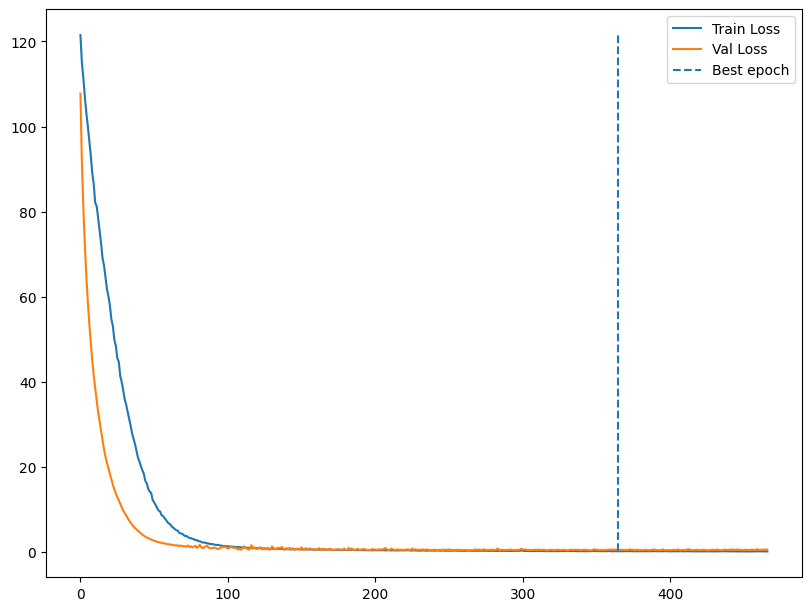

(20000, 556)
(20000,)
Train - f1=0.9897 recall=0.9796 precision=1.0000 log-loss=0.0509 opt-log-loss=0.0162
(20000, 61)
(20000,)
Test  - f1=0.8000 recall=0.8000 precision=0.8000 log-loss=0.5830 opt-log-loss=0.4961

-- Fold # 9/10 -Repeat #7/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.0221 - Val: 0.2243 at epoch 706.
Restore the best model.


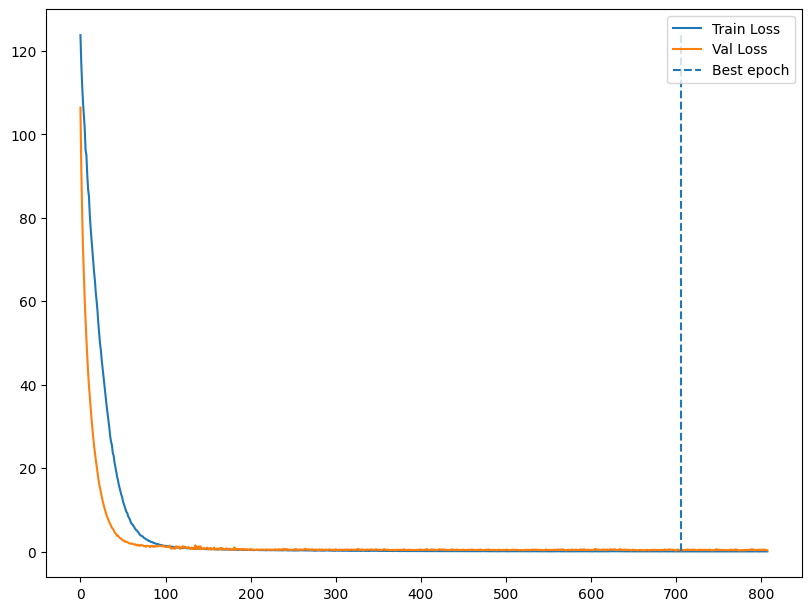

(20000, 556)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.0025 opt-log-loss=0.0030
(20000, 61)
(20000,)
Test  - f1=0.8421 recall=0.8000 precision=0.8889 log-loss=0.4882 opt-log-loss=0.3774

-- Fold # 9/10 -Repeat #8/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3739 - Val: 0.3425 at epoch 192.
Restore the best model.


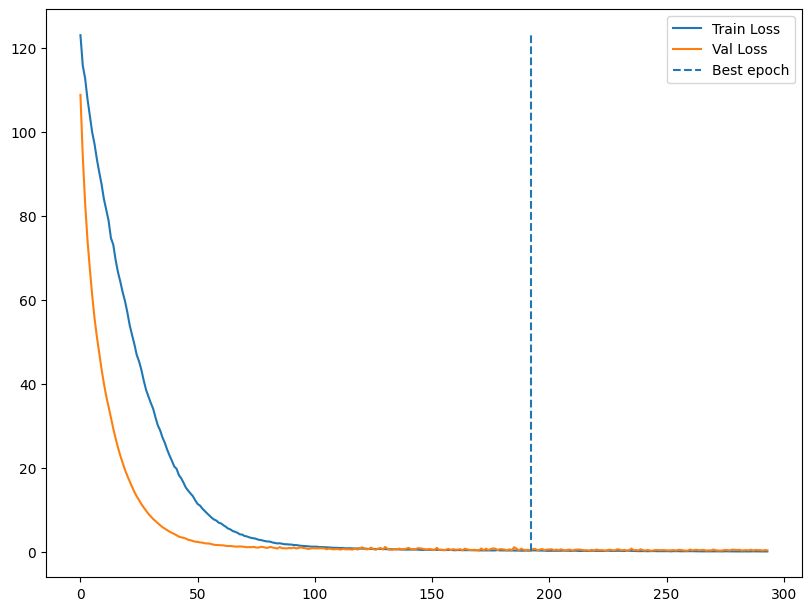

(20000, 556)
(20000,)
Train - f1=0.7927 recall=0.6633 precision=0.9848 log-loss=0.3611 opt-log-loss=0.1423
(20000, 61)
(20000,)
Test  - f1=0.8889 recall=0.8000 precision=1.0000 log-loss=0.6723 opt-log-loss=0.5197

-- Fold # 9/10 -Repeat #9/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.4455 - Val: 0.3706 at epoch 183.
Restore the best model.


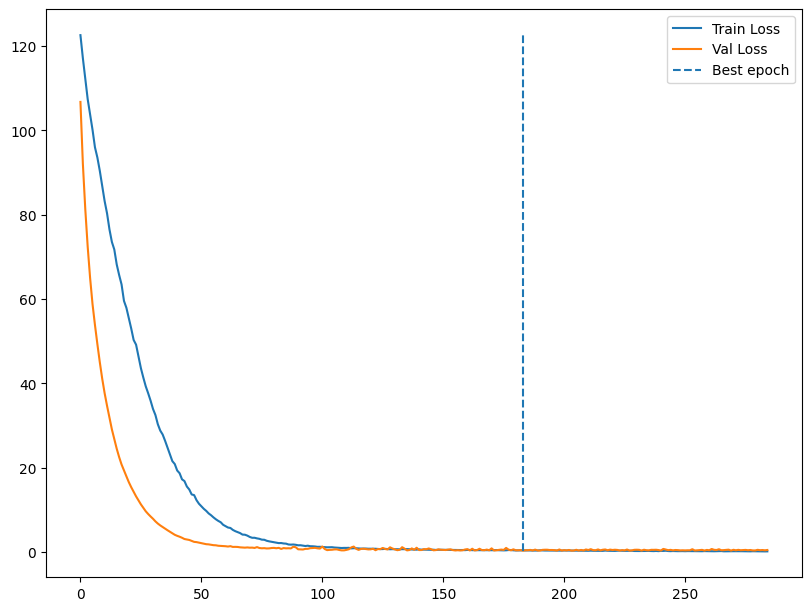

(20000, 556)
(20000,)
Train - f1=0.7514 recall=0.6633 precision=0.8667 log-loss=0.3763 opt-log-loss=0.1843
(20000, 61)
(20000,)
Test  - f1=0.7000 recall=0.7000 precision=0.7000 log-loss=0.7041 opt-log-loss=0.4998

-- Fold # 9/10 -Repeat #10/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1631 - Val: 0.3515 at epoch 318.
Restore the best model.


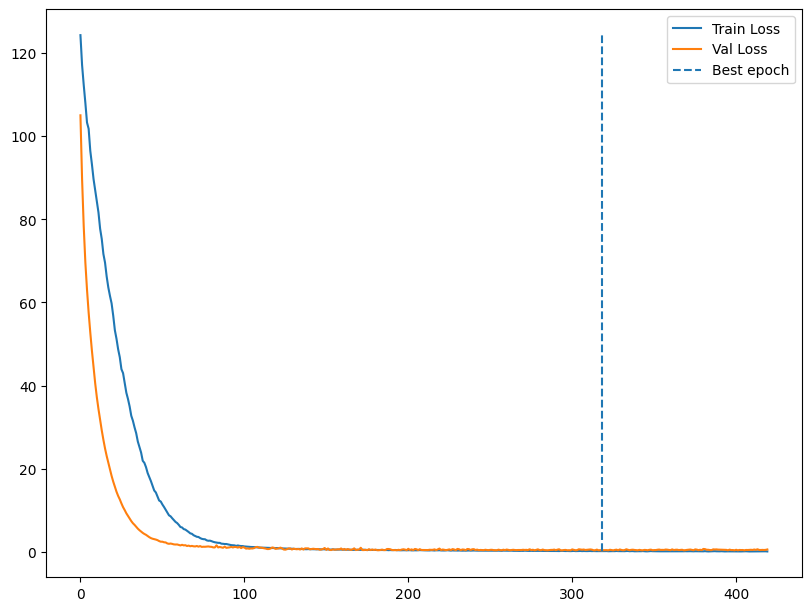

(20000, 556)
(20000,)
Train - f1=0.9949 recall=1.0000 precision=0.9899 log-loss=0.0675 opt-log-loss=0.0269
(20000, 61)
(20000,)
Test  - f1=0.8421 recall=0.8000 precision=0.8889 log-loss=0.6439 opt-log-loss=0.5376

-- Fold # 10/10 -Repeat #1/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3136 - Val: 0.2586 at epoch 242.
Restore the best model.


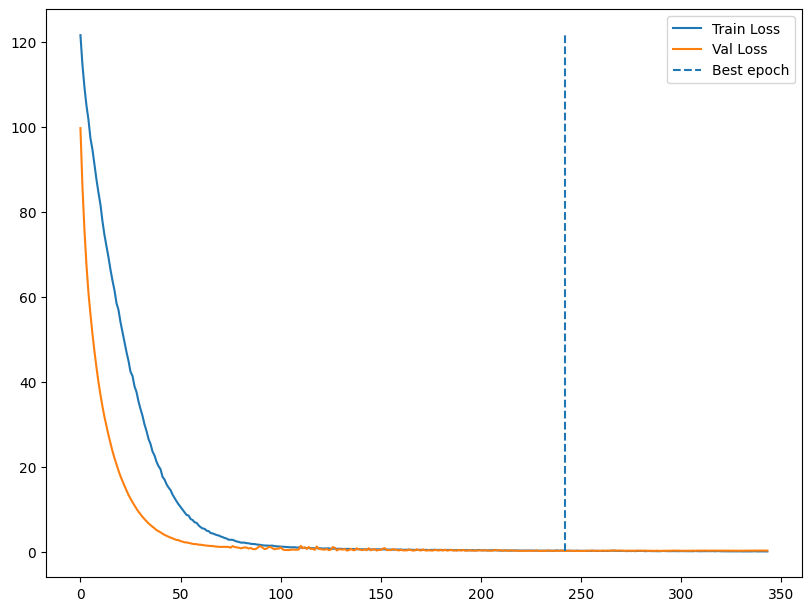

(20000, 556)
(20000,)
Train - f1=0.8739 recall=0.9898 precision=0.7823 log-loss=0.0904 opt-log-loss=0.1288
(20000, 61)
(20000,)
Test  - f1=0.8000 recall=0.8000 precision=0.8000 log-loss=0.3563 opt-log-loss=0.3050

-- Fold # 10/10 -Repeat #2/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2013 - Val: 0.2588 at epoch 288.
Restore the best model.


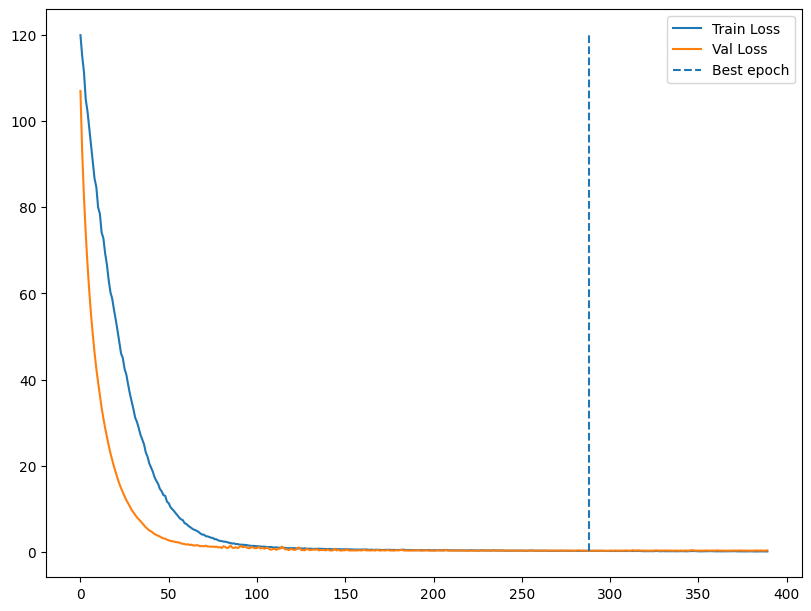

(20000, 556)
(20000,)
Train - f1=0.9848 recall=0.9898 precision=0.9798 log-loss=0.0255 opt-log-loss=0.0389
(20000, 61)
(20000,)
Test  - f1=0.8421 recall=0.8000 precision=0.8889 log-loss=0.3486 opt-log-loss=0.2516

-- Fold # 10/10 -Repeat #3/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3272 - Val: 0.2593 at epoch 229.
Restore the best model.


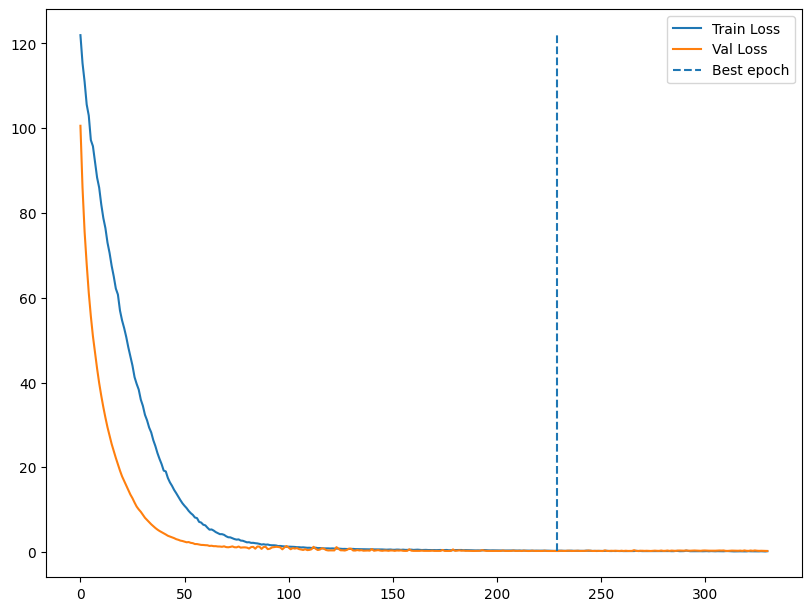

(20000, 556)
(20000,)
Train - f1=0.8807 recall=0.9796 precision=0.8000 log-loss=0.1117 opt-log-loss=0.1402
(20000, 61)
(20000,)
Test  - f1=0.8421 recall=0.8000 precision=0.8889 log-loss=0.3598 opt-log-loss=0.2573

-- Fold # 10/10 -Repeat #4/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3902 - Val: 0.2532 at epoch 201.
Restore the best model.


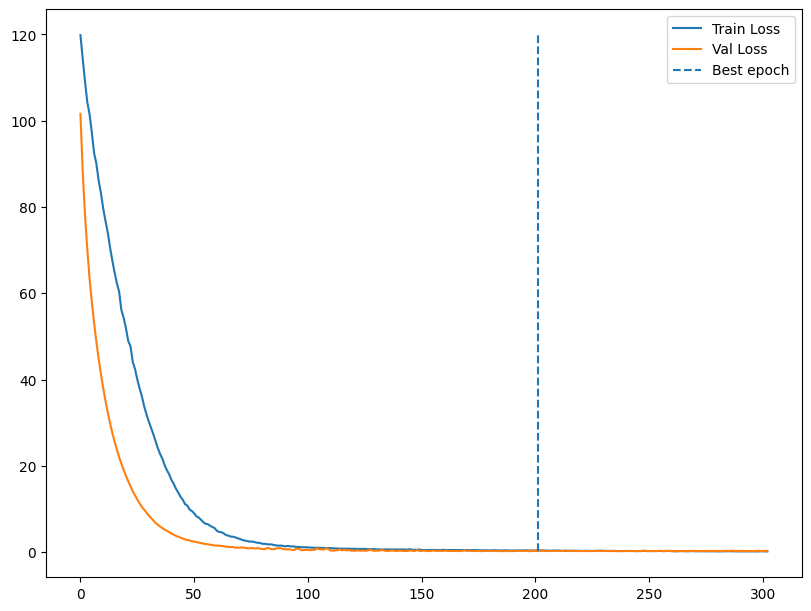

(20000, 556)
(20000,)
Train - f1=0.9005 recall=0.9694 precision=0.8407 log-loss=0.1297 opt-log-loss=0.1378
(20000, 61)
(20000,)
Test  - f1=0.8421 recall=0.8000 precision=0.8889 log-loss=0.3403 opt-log-loss=0.2483

-- Fold # 10/10 -Repeat #5/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2704 - Val: 0.3358 at epoch 270.
Restore the best model.


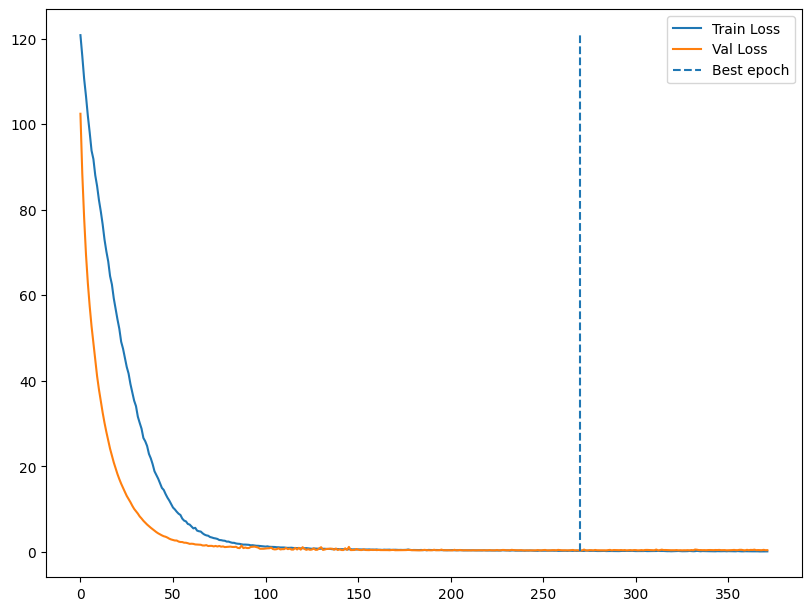

(20000, 556)
(20000,)
Train - f1=0.9417 recall=0.9898 precision=0.8981 log-loss=0.0602 opt-log-loss=0.0713
(20000, 61)
(20000,)
Test  - f1=0.7368 recall=0.7000 precision=0.7778 log-loss=0.5392 opt-log-loss=0.3825

-- Fold # 10/10 -Repeat #6/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2466 - Val: 0.2514 at epoch 284.
Restore the best model.


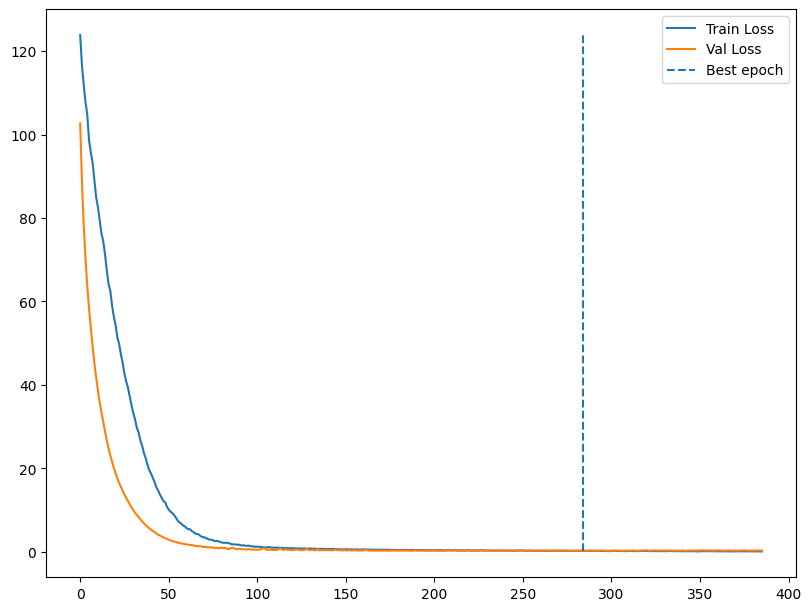

(20000, 556)
(20000,)
Train - f1=0.9608 recall=1.0000 precision=0.9245 log-loss=0.0443 opt-log-loss=0.0604
(20000, 61)
(20000,)
Test  - f1=0.8000 recall=0.8000 precision=0.8000 log-loss=0.4128 opt-log-loss=0.2838

-- Fold # 10/10 -Repeat #7/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3813 - Val: 0.2868 at epoch 203.
Restore the best model.


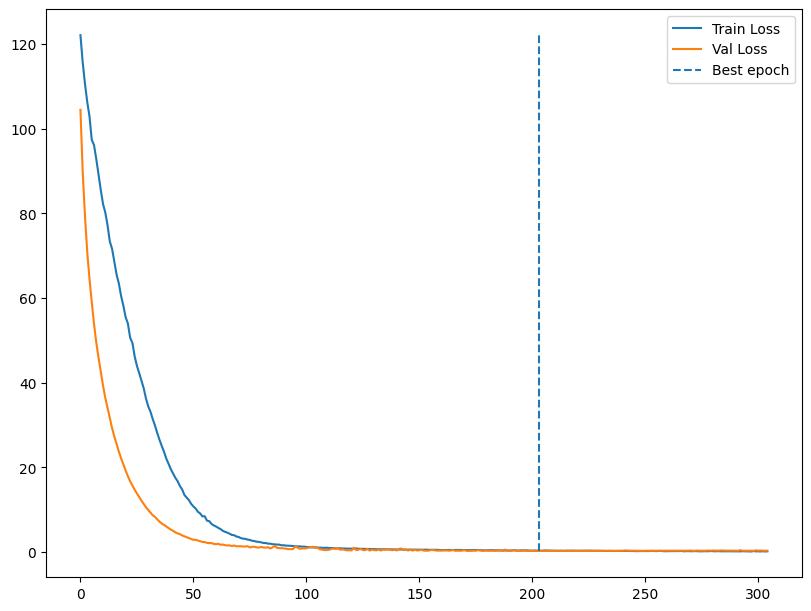

(20000, 556)
(20000,)
Train - f1=0.8962 recall=0.9694 precision=0.8333 log-loss=0.1204 opt-log-loss=0.1320
(20000, 61)
(20000,)
Test  - f1=0.8571 recall=0.9000 precision=0.8182 log-loss=0.4099 opt-log-loss=0.3187

-- Fold # 10/10 -Repeat #8/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.4001 - Val: 0.2836 at epoch 195.
Restore the best model.


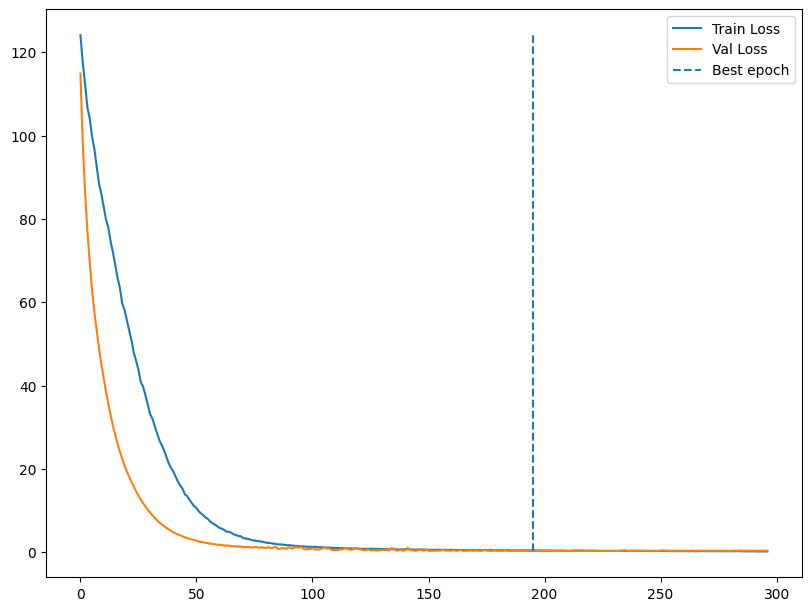

(20000, 556)
(20000,)
Train - f1=0.8664 recall=0.9592 precision=0.7899 log-loss=0.1669 opt-log-loss=0.1809
(20000, 61)
(20000,)
Test  - f1=0.7059 recall=0.6000 precision=0.8571 log-loss=0.4174 opt-log-loss=0.3062

-- Fold # 10/10 -Repeat #9/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2205 - Val: 0.3290 at epoch 298.
Restore the best model.


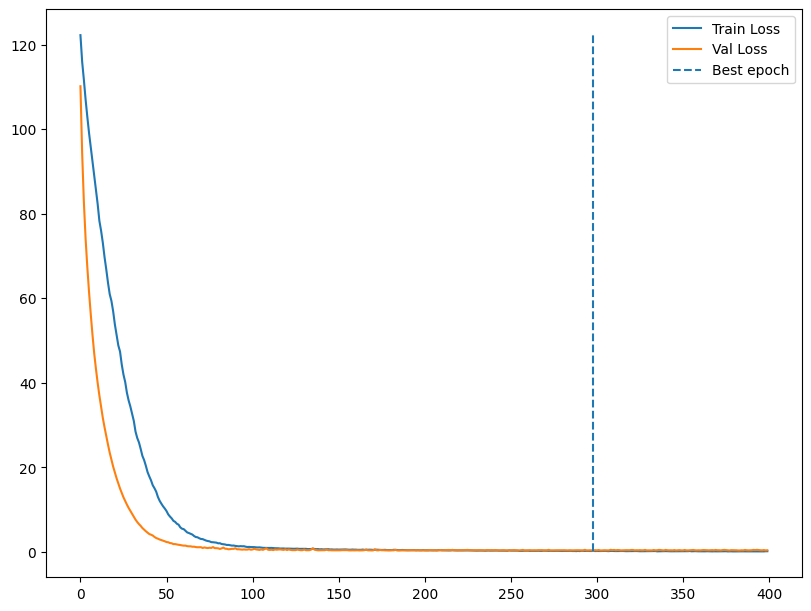

(20000, 556)
(20000,)
Train - f1=0.9749 recall=0.9898 precision=0.9604 log-loss=0.0359 opt-log-loss=0.0442
(20000, 61)
(20000,)
Test  - f1=0.8000 recall=0.8000 precision=0.8000 log-loss=0.5356 opt-log-loss=0.3948

-- Fold # 10/10 -Repeat #10/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1549 - Val: 0.3029 at epoch 353.
Restore the best model.


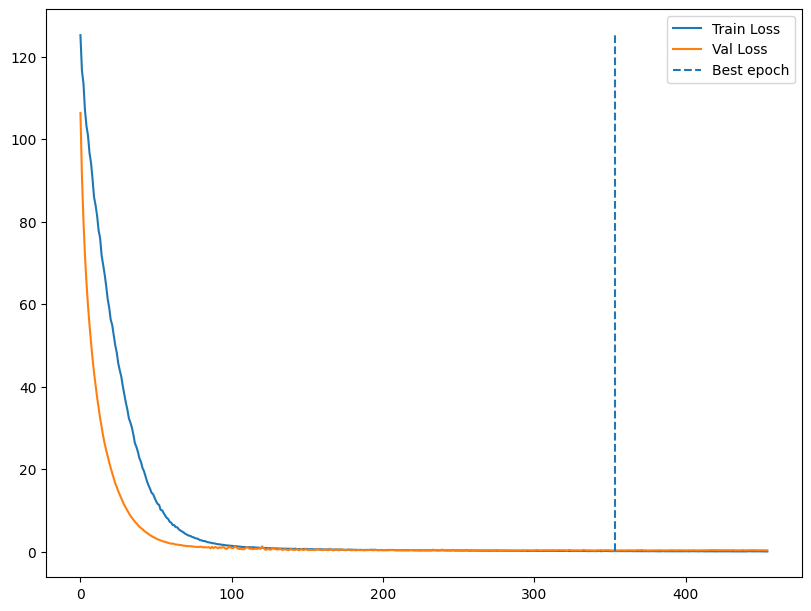

(20000, 556)
(20000,)
Train - f1=0.9949 recall=1.0000 precision=0.9899 log-loss=0.0162 opt-log-loss=0.0272
(20000, 61)
(20000,)
Test  - f1=0.8000 recall=0.8000 precision=0.8000 log-loss=0.4873 opt-log-loss=0.3576


In [18]:
def balanced_log_loss(y_true, pred_prob):
    nb_class_0 = np.sum(1 - y_true)
    nb_class_1 = np.sum(y_true)

    prob_0 = np.clip(1. - pred_prob, 1e-10, 1. - 1e-10)
    prob_1 = np.clip(pred_prob, 1e-10, 1. - 1e-10)
    return (-np.sum((1 - y_true) * np.log(prob_0)) / nb_class_0
            - np.sum(y_true * np.log(prob_1)) / nb_class_1) / 2.


def calculate_optimal_prob_prediction(y_preds):
    """
    Calculate the best probability prediction based on the formula
    (in experiment 04_logistics_bayesian_v4*).

    y_preds: numpy array of shape (nb_draws, nb_data_points).
    """
    assert y_preds.ndim == 2, "Only accept 2d numpy array as input."
    _, nb_data = y_preds.shape
    print(y_preds.shape)

    # Calculate number of classes for each draw.
    nb_class_0 = np.sum(1 - y_preds, axis=1)
    print(nb_class_0.shape)
    nb_class_1 = np.sum(y_preds, axis=1)

    best_probs = []
    eps = 1e-15
    for j in range(nb_data):
        cj = np.sum(y_preds[:, j] / (nb_class_1 + eps))
        cj_1 = np.sum((1 - y_preds[:, j]) / (nb_class_0 + eps))

        prob = cj / (cj + cj_1)
        best_probs.append(prob)

    return np.asarray(best_probs)


def estimate_optimal_prob_pred(y_prob, nb_samples: int = 20000):
    ys = bernoulli.rvs(y_prob[:, None], size=(y_prob.shape[0], nb_samples))
    return calculate_optimal_prob_prediction(ys.T)


def f1_recall_precision(y_true, y_pred):
    return tuple(f(y_true, y_pred)
                 for f in [f1_score, recall_score, precision_score])


def plot_train_history(history: dict, epochs: int):
    fig, ax = plt.subplots(figsize=(8, 6), layout='constrained')

    train_loss = history['train_loss']
    val_loss = history['val_loss']

    epochs = list(range(len(train_loss)))
    ax.plot(epochs, train_loss, label='Train Loss')
    ax.plot(epochs, val_loss, label='Val Loss')
    ax.vlines(
        history['best_epoch'],
        ymin=min(min(train_loss), min(val_loss)),
        ymax=max(max(train_loss), max(val_loss)),
        label='Best epoch',
        linestyles='dashed')
    ax.legend()

    return fig


def train_and_evaluate(*,
                       Xtr, gtr, ytr,
                       Xte, gte, yte,
                       epochs: int = 100,
                       device: str = 'cpu',
                       lr: float = 1e-3,
                       train_noise: float = 0.0,
                       early_stopping_patience: int = 100,
                       correlation_threshold: float = 0.3,
                       weight_decay: float = 1e-2,
                       regularization_weight: float = 1.0):
    # First, we will normalize the data.
    Xtr = pd.DataFrame(
        preprocessing.fit_transform(Xtr, ytr),
        columns=Xtr.columns)
    Xte = pd.DataFrame(
        preprocessing.transform(Xte),
        columns=Xte.columns)

    # Next, we'll filter out correlated features.
    Xtr = filter_in_uncorrelated_features(
        Xtr, correlation_threshold=correlation_threshold)
    Xte = Xte[Xtr.columns]

    # Store original training dataset.
    Xtr_orig = Xtr.copy()
    Xtr_orig['ej'] = gtr
    ytr_orig = ytr.copy()
    print(f'Before sampling, has {len(ytr_orig)} sammples,\n'
          f'in which there are {ytr_orig.sum()} positive samples.')

    # Next, we'll perform sampling.
    Xtr['ej'] = gtr
    Xte['ej'] = gte

    Xtr, ytr = sampling(Xtr, ytr)
    print(f'After sampling, has {len(ytr)} sammples,\n'
          f'in which there are {ytr.sum()} positive samples.')

    # Then, we use tree-based model to select important features.
    # Xtr = select_important_features(
    #     Xtr, ytr,
    #     n_estimators=1000,
    #     important_thresholds='5*median')
    # Xte = Xte[Xtr.columns]
    nb_features = len(Xtr.columns)
    print('Number of important features: ', nb_features)

    # Training neural network model.
    # print(Xtr.values, ytr[:, None])
    X_train_ds = TensorDataset(
        torch.tensor(Xtr.values, dtype=torch.float32),
        torch.tensor(ytr[:, None], dtype=torch.float32))
    X_val_ds = TensorDataset(
        torch.tensor(Xte.values, dtype=torch.float32),
        torch.tensor(yte[:, None], dtype=torch.float32))

    Xtr_dataloader = DataLoader(X_train_ds, batch_size=64, shuffle=True)
    Xva_dataloader = DataLoader(X_val_ds, batch_size=64)

    model, history = train(NNClassifier(nb_features),
                           train_ds=Xtr_dataloader,
                           val_ds=Xva_dataloader,
                           epochs=epochs,
                           early_stopping_patience=early_stopping_patience,
                           device=device,
                           lr=lr,
                           weight_decay=weight_decay,
                           regularization_weight=regularization_weight,
                           train_noise=train_noise)

    # Plot training history.
    fig = plot_train_history(history, epochs=epochs)
    plt.show()
    plt.close(fig)

    # Evaluate the model.
    ytr_prob = (model(
        torch.tensor(Xtr_orig.values, dtype=torch.float32).to(device))
        .cpu().detach().numpy().squeeze())
    ytr_opt_prob = estimate_optimal_prob_pred(ytr_prob)
    ytr_pred = np.where(ytr_prob > 0.5, 1., 0.)
    (f1_train,
     recall_train,
     precision_train) = f1_recall_precision(ytr_orig, ytr_pred)
    log_loss_train = balanced_log_loss(ytr_orig, ytr_prob)
    opt_log_loss_train = balanced_log_loss(ytr_orig, ytr_opt_prob)
    print(f'Train - f1={f1_train:.4f} recall={recall_train:.4f} '
          f'precision={precision_train:.4f} log-loss={log_loss_train:.4f} '
          f'opt-log-loss={opt_log_loss_train:.4f}')

    yte_prob = (model(
        torch.tensor(Xte.values, dtype=torch.float32).to(device))
        .cpu().detach().numpy().squeeze())
    yte_opt_prob = estimate_optimal_prob_pred(yte_prob)
    yte_pred = np.where(yte_prob > 0.5, 1., 0.)
    (f1_test,
     recall_test,
     precision_test) = f1_recall_precision(yte, yte_pred)
    log_loss_test = balanced_log_loss(yte, yte_prob)
    opt_log_loss_test = balanced_log_loss(yte, yte_opt_prob)
    print(f'Test  - f1={f1_test:.4f} recall={recall_test:.4f} '
          f'precision={precision_test:.4f} log-loss={log_loss_test:.4f} '
          f'opt-log-loss={opt_log_loss_test:.4f}')

    return dict(
        f1_train=f1_train,
        f1_test=f1_test,
        log_loss_train=log_loss_train,
        opt_log_loss_train=opt_log_loss_train,
        log_loss_test=log_loss_test,
        opt_log_loss_test=opt_log_loss_test,
    )


def cross_validations(*, X, grp, y,
                      n_folds: int = 10,
                      repeats_per_fold: int = 1,
                      **kwargs):
    results = []

    kfolds = StratifiedKFold(n_splits=n_folds)
    for fold, (train_idx, test_idx) in enumerate(kfolds.split(X, y)):
        for repeat in range(repeats_per_fold):
            print(f'\n-- Fold # {fold + 1}/{n_folds} - '
                  f'Repeat #{repeat + 1}/{repeats_per_fold}:')

            Xtr, Xte = X.iloc[train_idx], X.iloc[test_idx]
            gtr, gte = grp[train_idx], grp[test_idx]
            ytr, yte = y[train_idx], y[test_idx]

            result = train_and_evaluate(
                Xtr=Xtr, gtr=gtr, ytr=ytr,
                Xte=Xte, gte=gte, yte=yte,
                **kwargs)

            result['fold'] = fold + 1
            result['repeat'] = repeat + 1
            results.append(result)

    return pd.DataFrame(results)


cv_results = cross_validations(
    X=Xtrain_df,
    grp=ej.cat.codes.values,
    y=y,
    n_folds=10,
    repeats_per_fold=10,
    epochs=2000,
    correlation_threshold=0.3,
    lr=1e-4,
    early_stopping_patience=100,
    weight_decay=1e-2,
    regularization_weight=1.0,
    train_noise=0.00)

In [19]:
cv_results

f1_train   f1_test  log_loss_train  opt_log_loss_train  log_loss_test  \
0   0.989691  0.727273        0.025319            0.024921       0.396531   
1   0.974619  0.909091        0.041240            0.036317       0.201296   
2   0.964824  0.818182        0.045133            0.049372       0.224679   
3   1.000000  0.761905        0.016979            0.014254       0.423971   
4   0.974619  0.666667        0.051851            0.060151       0.281522   
..       ...       ...             ...                 ...            ...   
95  0.960784  0.800000        0.044277            0.060411       0.412771   
96  0.896226  0.857143        0.120437            0.131958       0.409879   
97  0.866359  0.705882        0.166866            0.180902       0.417439   
98  0.974874  0.800000        0.035937            0.044179       0.535555   
99  0.994924  0.800000        0.016189            0.027249       0.487285   

    opt_log_loss_test  fold  repeat  
0            0.267891     1       1  
1            0.158063     1       2  
2            0.186369     1       3  
3            0.295798     1       4  
4            0.214737     1       5  
..                ...   ...     ...  
95           0.283795    10       6  
96           0.318671    10       7  
97           0.306230    10       8  
98           0.394777    10       9  
99           0.357562    10      10  

[100 rows x 8 columns]

In [27]:
def get_optimal_cv_results_each_fold(results: pd.DataFrame,
                                     by: str,
                                     method: Literal['max', 'min'] = 'max'):
    folds = results.groupby('fold')

    optimal_results = []
    for fold, fold_results in folds:
        best_idx = (fold_results[by].argmax()
                    if method == 'max'
                    else fold_results[by].argmin())
        optimal_result = fold_results.iloc[best_idx].to_dict()
        optimal_results.append(optimal_result)

    return pd.DataFrame(optimal_results)

f1_train   f1_test  log_loss_train  opt_log_loss_train  log_loss_test  \
0  0.974619  0.909091        0.041240            0.036317       0.201296   
1  0.974874  0.909091        0.023712            0.044400       0.327825   
2  0.989583  0.800000        0.050555            0.019981       0.435935   
3  0.844444  0.869565        0.331229            0.198084       0.320878   
4  0.960000  0.909091        0.040886            0.063568       0.212688   
5  1.000000  0.727273        0.006359            0.015835       0.654230   
6  0.944162  0.666667        0.103502            0.103935       0.664285   
7  0.979381  0.833333        0.060254            0.045768       0.339584   
8  0.887640  0.888889        0.222739            0.078862       0.596604   
9  0.896226  0.857143        0.120437            0.131958       0.409879   

   opt_log_loss_test  fold  repeat  
0           0.158063   1.0     2.0  
1           0.275856   2.0     2.0  
2           0.271855   3.0     3.0  
3           0.249653   4.0     6.0  
4           0.168341   5.0     2.0  
5           0.545045   6.0     9.0  
6           0.521003   7.0     2.0  
7           0.285019   8.0    10.0  
8           0.445478   9.0     2.0  
9           0.318671  10.0     7.0

## Results
### Optimal F1 Test

In [29]:
# Optimal results per fold by f1_test.
cv_results_optimal_f1_test = get_optimal_cv_results_each_fold(
    cv_results, 'f1_test', 'max')
cv_results_optimal_f1_test

f1_train   f1_test  log_loss_train  opt_log_loss_train  log_loss_test  \
0  0.974619  0.909091        0.041240            0.036317       0.201296   
1  0.974874  0.909091        0.023712            0.044400       0.327825   
2  0.989583  0.800000        0.050555            0.019981       0.435935   
3  0.844444  0.869565        0.331229            0.198084       0.320878   
4  0.960000  0.909091        0.040886            0.063568       0.212688   
5  1.000000  0.727273        0.006359            0.015835       0.654230   
6  0.944162  0.666667        0.103502            0.103935       0.664285   
7  0.979381  0.833333        0.060254            0.045768       0.339584   
8  0.887640  0.888889        0.222739            0.078862       0.596604   
9  0.896226  0.857143        0.120437            0.131958       0.409879   

   opt_log_loss_test  fold  repeat  
0           0.158063   1.0     2.0  
1           0.275856   2.0     2.0  
2           0.271855   3.0     3.0  
3           0.249653   4.0     6.0  
4           0.168341   5.0     2.0  
5           0.545045   6.0     9.0  
6           0.521003   7.0     2.0  
7           0.285019   8.0    10.0  
8           0.445478   9.0     2.0  
9           0.318671  10.0     7.0

In [30]:
cv_results_optimal_f1_test.describe()

f1_train    f1_test  log_loss_train  opt_log_loss_train  \
count  10.000000  10.000000       10.000000           10.000000   
mean    0.945093   0.837014        0.100091            0.073871   
std     0.051608   0.083124        0.102481            0.056939   
min     0.844444   0.666667        0.006359            0.015835   
25%     0.908210   0.808333        0.040975            0.038338   
50%     0.967310   0.863354        0.055405            0.054668   
75%     0.978255   0.904040        0.116203            0.097667   
max     1.000000   0.909091        0.331229            0.198084   

       log_loss_test  opt_log_loss_test      fold     repeat  
count      10.000000          10.000000  10.00000  10.000000  
mean        0.416320           0.323898   5.50000   4.500000  
std         0.170472           0.135935   3.02765   3.205897  
min         0.201296           0.158063   1.00000   2.000000  
25%         0.322614           0.255203   3.25000   2.000000  
50%         0.374732           0.280438   5.50000   2.500000  
75%         0.556437           0.413776   7.75000   6.750000  
max         0.664285           0.545045  10.00000  10.000000

### Optimal `opt_log_loss_test`

In [31]:
cv_results_optimal_log_loss_test = get_optimal_cv_results_each_fold(
    cv_results, 'opt_log_loss_test', 'min')
cv_results_optimal_log_loss_test

f1_train   f1_test  log_loss_train  opt_log_loss_train  log_loss_test  \
0  0.974619  0.909091        0.041240            0.036317       0.201296   
1  0.888889  0.833333        0.133806            0.137451       0.248448   
2  0.979381  0.750000        0.076842            0.059101       0.239606   
3  0.825581  0.818182        0.332678            0.161242       0.288706   
4  1.000000  0.857143        0.019148            0.026344       0.194044   
5  0.964467  0.666667        0.062237            0.068002       0.406210   
6  0.944162  0.666667        0.103502            0.103935       0.664285   
7  0.984615  0.761905        0.029128            0.024663       0.356876   
8  1.000000  0.842105        0.002548            0.003005       0.488188   
9  0.900474  0.842105        0.129729            0.137828       0.340270   

   opt_log_loss_test  fold  repeat  
0           0.158063   1.0     2.0  
1           0.194706   2.0     8.0  
2           0.195755   3.0     1.0  
3           0.188730   4.0     5.0  
4           0.110072   5.0     8.0  
5           0.324670   6.0     6.0  
6           0.521003   7.0     2.0  
7           0.234324   8.0     1.0  
8           0.377412   9.0     7.0  
9           0.248321  10.0     4.0

In [32]:
cv_results_optimal_log_loss_test.describe()

f1_train    f1_test  log_loss_train  opt_log_loss_train  \
count  10.000000  10.000000       10.000000           10.000000   
mean    0.946219   0.794720        0.093086            0.075789   
std     0.057189   0.081228        0.095552            0.055776   
min     0.825581   0.666667        0.002548            0.003005   
25%     0.911396   0.752976        0.032156            0.028838   
50%     0.969543   0.825758        0.069540            0.063551   
75%     0.983307   0.842105        0.123172            0.129072   
max     1.000000   0.909091        0.332678            0.161242   

       log_loss_test  opt_log_loss_test      fold     repeat  
count      10.000000          10.000000  10.00000  10.000000  
mean        0.342793           0.255306   5.50000   4.400000  
std         0.146570           0.121566   3.02765   2.796824  
min         0.194044           0.110072   1.00000   1.000000  
25%         0.241816           0.190224   3.25000   2.000000  
50%         0.314488           0.215040   5.50000   4.500000  
75%         0.393876           0.305583   7.75000   6.750000  
max         0.664285           0.521003  10.00000   8.000000

# Results Overview

---
* Architecture: 1024 (ReLu, Dropout, LayerNorm) -> 512 (ReLu, Dropout, LayerNorm) -> 64 (LayerNorm) -> 1
* Correlation Threshold: 0.3
* LR: 1-4
* Weight Decay: 1e-2
* Regularization weight: 1.0
* Train noise: 0.0